In [1]:
library(repr)
options(repr.plot.width=12, repr.plot.height=7, repr.plot.res = 180)

In [3]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [4]:
library(RColorBrewer)

In [5]:
flatui = c("#9b59b6", "#3498db", "#004F99", "#250352", "#95a5a6", "#e74c3c", "#ECE59A", "#34495e", "#2ecc71", "#5B9E00", "#A71812")

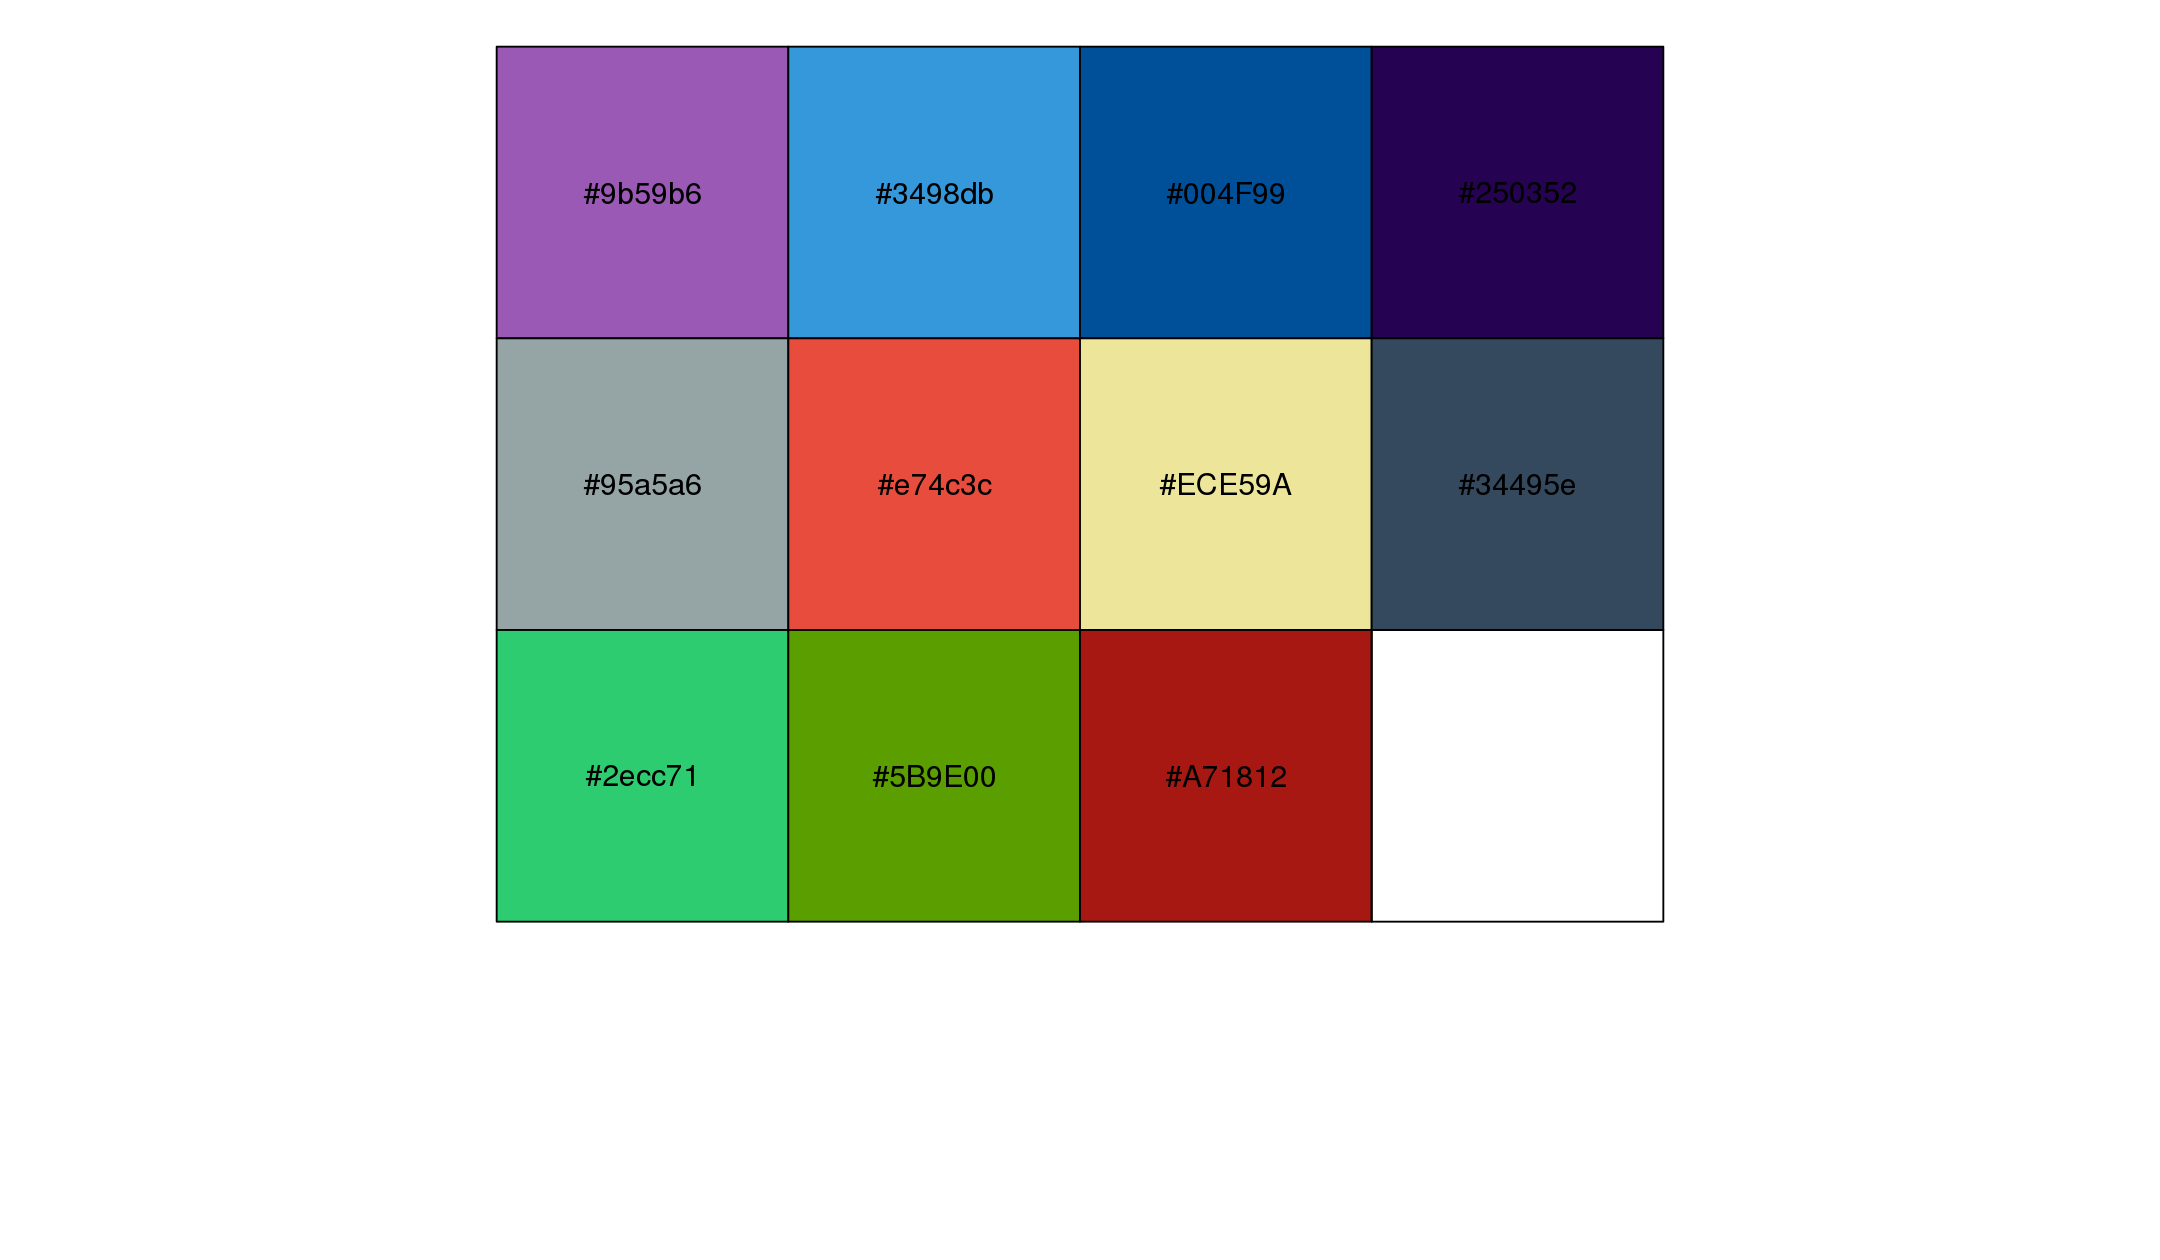

In [8]:
scales::show_col(flatui)

# Figure 1B - WT RNA seq `DESeq` result

**WANT:** 
- heatmap that shows all significant genes, clustered differently. (TF vs. non TF, or expression patterns)
- heatmap should only display the log2 fold change of significant genes, not readcounts

In [9]:
setwd("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen")

Excel file that houses RNAseq DESeq2 result

```
WriteXLS(list("rawCounts" = rawCounts.dds3, "H15_vs_ES"=res3a.df, "D1_vs_ES"=res3b.df, 
              "D2_vs_ES"=res3c.df, "D4_vs_ES"=res3d.df, "D7_vs_ES"=res3e.df), 
         ExcelFileName = "RNA-seq_timepoint_deseq_result_20200102.xlsx")
```

In [10]:
sheets <- c("rawCounts", "H15_vs_ES", "D1_vs_ES", "D2_vs_ES", "D4_vs_ES", "D7_vs_ES")

In [11]:
rna_data <- map(sheets, ~ readxl::read_excel("RNA-seq_timepoint_deseq_result_20200102.xlsx", .x))

In [12]:
names(rna_data) <- sheets

In [13]:
# list of TF gene names
tflist <- read.csv('TFlist_20191230.csv', stringsAsFactors = F) %>% pull(hgnc_symbol)

In [14]:
# list hit TF
hitlist <- read.csv('Hitlist_20191230.csv', stringsAsFactors = F) %>% pull(hgnc_symbol)

In [15]:
rna_data$D7_vs_ES %>% head

gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000000003.14,1093.2455416,-1.2998652,0.1841414,-7.059060,1.676324e-12,2.500888e-11,TSPAN6
ENSG00000000005.6,4.2712569,-5.4619627,2.2687624,-2.407464,1.606377e-02,4.193408e-02,TNMD
ENSG00000000419.12,562.8246277,-0.4335166,0.3066240,-1.413838,1.574096e-01,2.662829e-01,DPM1
ENSG00000000457.14,66.6639588,0.9733724,0.8216719,1.184624,2.361660e-01,3.629106e-01,SCYL3
ENSG00000000460.17,134.9026604,-3.0439906,0.7900719,-3.852802,1.167738e-04,5.509179e-04,C1orf112
ENSG00000000938.13,0.3862281,0.0000000,4.8388833,0.000000,1.000000e+00,NA,FGR


In [16]:
# log2(CPM) normalize counts
rna_normCounts <- select(rna_data$rawCounts, S01_B1:S22_B2) %>% 
                    apply(2, function(x) log2(1e6 * (x + 1e-6) / sum(x))) %>% 
                    as_tibble

In [17]:
# add gene id and gene names
rna_normCounts <- cbind(rna_data$rawCounts[, 1:2], rna_normCounts)

In [18]:
rna_normCounts %>% head

,gene_id,gene_name,S01_B1,S01_B2,S02_B1,S02_B2,S07_B1,S07_B2,S08_B1,S08_B2,⋯,S18_B1,S18_B2,S19_B1,S19_B2,S20_B1,S20_B2,S21_B1,S21_B2,S22_B1,S22_B2
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000003.14,TSPAN6,7.183075,7.363589,7.112355,7.4048619,7.116553,7.503570,7.145620,7.417884,⋯,7.975758,8.138377,8.131095,8.355854,7.547006,8.163743,5.563412,6.568980,6.139528,6.458649
2,ENSG00000000005.6,TNMD,1.756810,-22.483859,-22.443095,0.6045504,-22.344447,-20.915839,-22.748844,-2.866360,⋯,-22.257307,-1.974713,-22.447932,-22.595305,-22.439845,-3.004301,-21.819368,-22.198639,-21.991713,-22.662744
3,ENSG00000000419.12,DPM1,7.082530,6.961438,7.031505,6.9716671,6.194452,6.892247,6.185539,6.729828,⋯,7.410664,6.840670,7.122073,6.963797,5.922176,7.159347,6.674443,6.376785,5.934209,6.416030
4,ENSG00000000457.14,SCYL3,1.830811,3.513799,3.103183,3.2744017,4.695646,3.873711,4.575042,2.559903,⋯,-22.257307,2.883267,4.494864,2.859825,3.849276,3.317626,3.635763,2.687126,4.734271,4.223021
5,ENSG00000000460.17,C1orf112,4.341772,5.168809,4.810402,5.2004011,-22.344447,2.823085,3.312007,2.381566,⋯,4.864086,4.391608,4.316527,4.883158,4.374367,3.972978,3.867088,-22.198639,-21.991713,-2.731174
6,ENSG00000000938.13,FGR,-22.422686,-22.483859,-22.443095,-22.7864499,-22.344447,-20.915839,-22.748844,-22.797930,⋯,-22.257307,-22.906282,-22.447932,-22.595305,-22.439845,-2.004302,-21.819368,-22.198639,-21.991713,-22.662744


#### Remove some gene_id

In [19]:
remove_gene_ids <- filter(rna_data$rawCounts, str_detect(gene_id, "_") | gene_id %in% c("ENSG00000269226.7") |
                          str_detect(gene_name, "^RF0")) %>% pull(gene_id)

#### Sample annotations

In [20]:
# sample name annotations
all.sample.annotation <- read.csv('RNASeqSampleNames.csv', stringsAsFactors=F)

In [21]:
all.sample.annotation %>% t

sample,S01_B1,S01_B2,S02_B1,S02_B2,S03_B1,S03_B2,S04_B1,S04_B2,S05_B1,S05_B2,⋯,S18_B1,S18_B2,S19_B1,S19_B2,S20_B1,S20_B2,S21_B1,S21_B2,S22_B1,S22_B2
condition,WT.ES,WT.ES,WT.ES,WT.ES,K108.ES,K108.ES,K108.ES,K108.ES,K112.ES,K112.ES,⋯,WT.D1,WT.D1,WT.D2,WT.D2,WT.D2,WT.D2,WT.D7,WT.D7,WT.D7,WT.D7
group,ES,ES,ES,ES,KO.ES,KO.ES,KO.ES,KO.ES,KO.ES,KO.ES,⋯,D1,D1,D2,D2,D2,D2,D7,D7,D7,D7


In [22]:
# log2(CPM) normalized read counts for wild types only
rna_normCounts_wt <- select(rna_normCounts, gene_id:S02_B2, S15_B1:S20_B2, S07_B1:S08_B2, S21_B1:S22_B2) %>% filter(!gene_id %in% remove_gene_ids)

### Construct DF to indicate whether significant or not and whether TF or not
criteria: 
- padj value < 0.05

In [23]:
rna_data[2:6] %>% names

[1] "H15_vs_ES" "D1_vs_ES"  "D2_vs_ES"  "D4_vs_ES"  "D7_vs_ES"

In [24]:
# add column to indicate significance for each time point
ge <- map(rna_data[2:6], ~ mutate(.x, sig = if_else(is.na(padj), F, padj < .05)) %>%
                            mutate(isTF = gene_name %in% tflist) %>%
                            mutate(isHit = gene_name %in% hitlist))

In [25]:
set1 <- c("ZBTB18", "JUND", "RCOR2", "NEUROG2", "FOXN2", "SNAI2", "VAX2", "TSC22D3", "INSM1", "EBF1")

In [26]:
# example
ge$D7_vs_ES %>% filter(gene_name %in% set1)

gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name,sig,isTF,isHit
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>
ENSG00000019549.13,455.17399,5.292902,0.6514628,8.124642,4.486848e-16,9.563660e-15,SNAI2,TRUE,TRUE,TRUE
ENSG00000116035.4,29.61198,7.718415,1.4769313,5.225981,1.732341e-07,1.364210e-06,VAX2,TRUE,TRUE,TRUE
ENSG00000130522.5,509.88324,1.751619,0.3189557,5.491731,3.980135e-08,3.425058e-07,JUND,TRUE,TRUE,TRUE
ENSG00000157514.16,891.29267,3.561977,0.2612859,13.632486,2.566842e-42,2.778339e-40,TSC22D3,TRUE,TRUE,TRUE
ENSG00000164330.17,1053.47802,10.653690,0.4911347,21.691992,2.441791e-104,2.206318e-101,EBF1,TRUE,TRUE,TRUE
ENSG00000167771.6,1426.46611,1.432271,0.4234640,3.382274,7.188834e-04,2.838115e-03,RCOR2,TRUE,TRUE,TRUE
ENSG00000170802.16,233.78366,1.171793,0.3626543,3.231156,1.232906e-03,4.582766e-03,FOXN2,TRUE,TRUE,TRUE
ENSG00000173404.5,1657.27746,9.388061,0.3630253,25.860623,1.847978e-147,4.800586e-144,INSM1,TRUE,TRUE,TRUE
ENSG00000178403.4,48.30813,8.939847,1.0683463,8.367931,5.863890e-17,1.337688e-15,NEUROG2,TRUE,TRUE,TRUE


### Number of genes up or down regulated at each time point

In [27]:
# up regulated genes
UP_GENES <- map(ge, ~ filter(.x, sig & log2FoldChange > 0 & !gene_id %in% remove_gene_ids) %>% pull(gene_name))
# down regulated genes
DN_GENES <- map(ge, ~ filter(.x, sig & log2FoldChange < 0 & !gene_id %in% remove_gene_ids) %>% pull(gene_name))
# Up regulated TF
UP_TF_GENES <- map(ge, ~ filter(.x, sig & isTF & log2FoldChange > 0 & !gene_id %in% remove_gene_ids) %>% pull(gene_name))
# Down regulated TF
DN_TF_GENES <- map(ge, ~ filter(.x, sig & isTF & log2FoldChange < 0 & !gene_id %in% remove_gene_ids) %>% pull(gene_name))

In [28]:
ge_trend_data <- tibble(time = c("H15", "D1", "D2", "D4","D7"), 
       up_genes = map_int(UP_GENES, length), 
       dn_genes = map_int(DN_GENES, length),
       up_tf_genes = map_int(UP_TF_GENES, length), 
       dn_tf_genes = map_int(DN_TF_GENES, length))

In [29]:
ge_trend_data

time,up_genes,dn_genes,up_tf_genes,dn_tf_genes
<chr>,<int>,<int>,<int>,<int>
H15,802,741,102,73
D1,1335,921,139,91
D2,2249,2583,239,220
D4,2892,3201,307,297
D7,4189,4018,434,346


In [30]:
ge_trend_data <- mutate(ge_trend_data, up_ntf_genes = up_genes - up_tf_genes) %>%
                    mutate(dn_ntf_genes = dn_genes - dn_tf_genes)

In [31]:
ge_trend_plot <- ge_trend_data %>% select(time, up_tf_genes:dn_ntf_genes) %>% 
                    pivot_longer(c("up_tf_genes", "up_ntf_genes"), names_to = "col1", values_to = "up") %>%
                    pivot_longer(c("dn_tf_genes", "dn_ntf_genes"), names_to = "col2",values_to = "dn") %>%
                    mutate(col3 = str_replace(col1, "(up_|dn_)", "")) %>%
                    mutate(col4 = str_replace(col2, "(up_|dn_)", "")) %>%
                    filter(col3 == col4) %>%
                    rename(type=col3) %>%
                    select(time, type, up, dn) %>%
                    pivot_longer(cols = c("up", 'dn'), names_to = "direction", values_to = "num")

In [32]:
ge_trend_plot <- mutate_at(ge_trend_plot, "time", ~ factor(.x, levels = as.factor(c("H15", "D1", "D2", "D4", "D7"))))

In [33]:
ge_trend_plot %>% head

time,type,direction,num
<fct>,<chr>,<chr>,<int>
H15,tf_genes,up,102
H15,tf_genes,dn,73
H15,ntf_genes,up,700
H15,ntf_genes,dn,668
D1,tf_genes,up,139
D1,tf_genes,dn,91


In [34]:
color_scheme1 <- c("up" = flatui[6], "dn"= flatui[2])

##### There are consistently more *up* regulated genes then *down* regulated genes in TF, while it is arbitrary in the non-TF genes.

In [35]:
my.theme <- theme_classic() + 
            theme(axis.text=element_text(size=12), 
                  axis.title=element_text(size=12,face="bold"),
                  legend.text=element_text(size=12),
                  legend.title=element_text(size=12), 
                  strip.text = element_text(size = 12, face = "bold"),
                  strip.background = element_rect(fill = alpha("grey", .3), size = 0, ),
                  panel.grid.minor = element_line(size = .2),
                  panel.grid.major = element_line(size = .2))

In [36]:
mb <- as.numeric(1:10 %o% 10^(2:3))

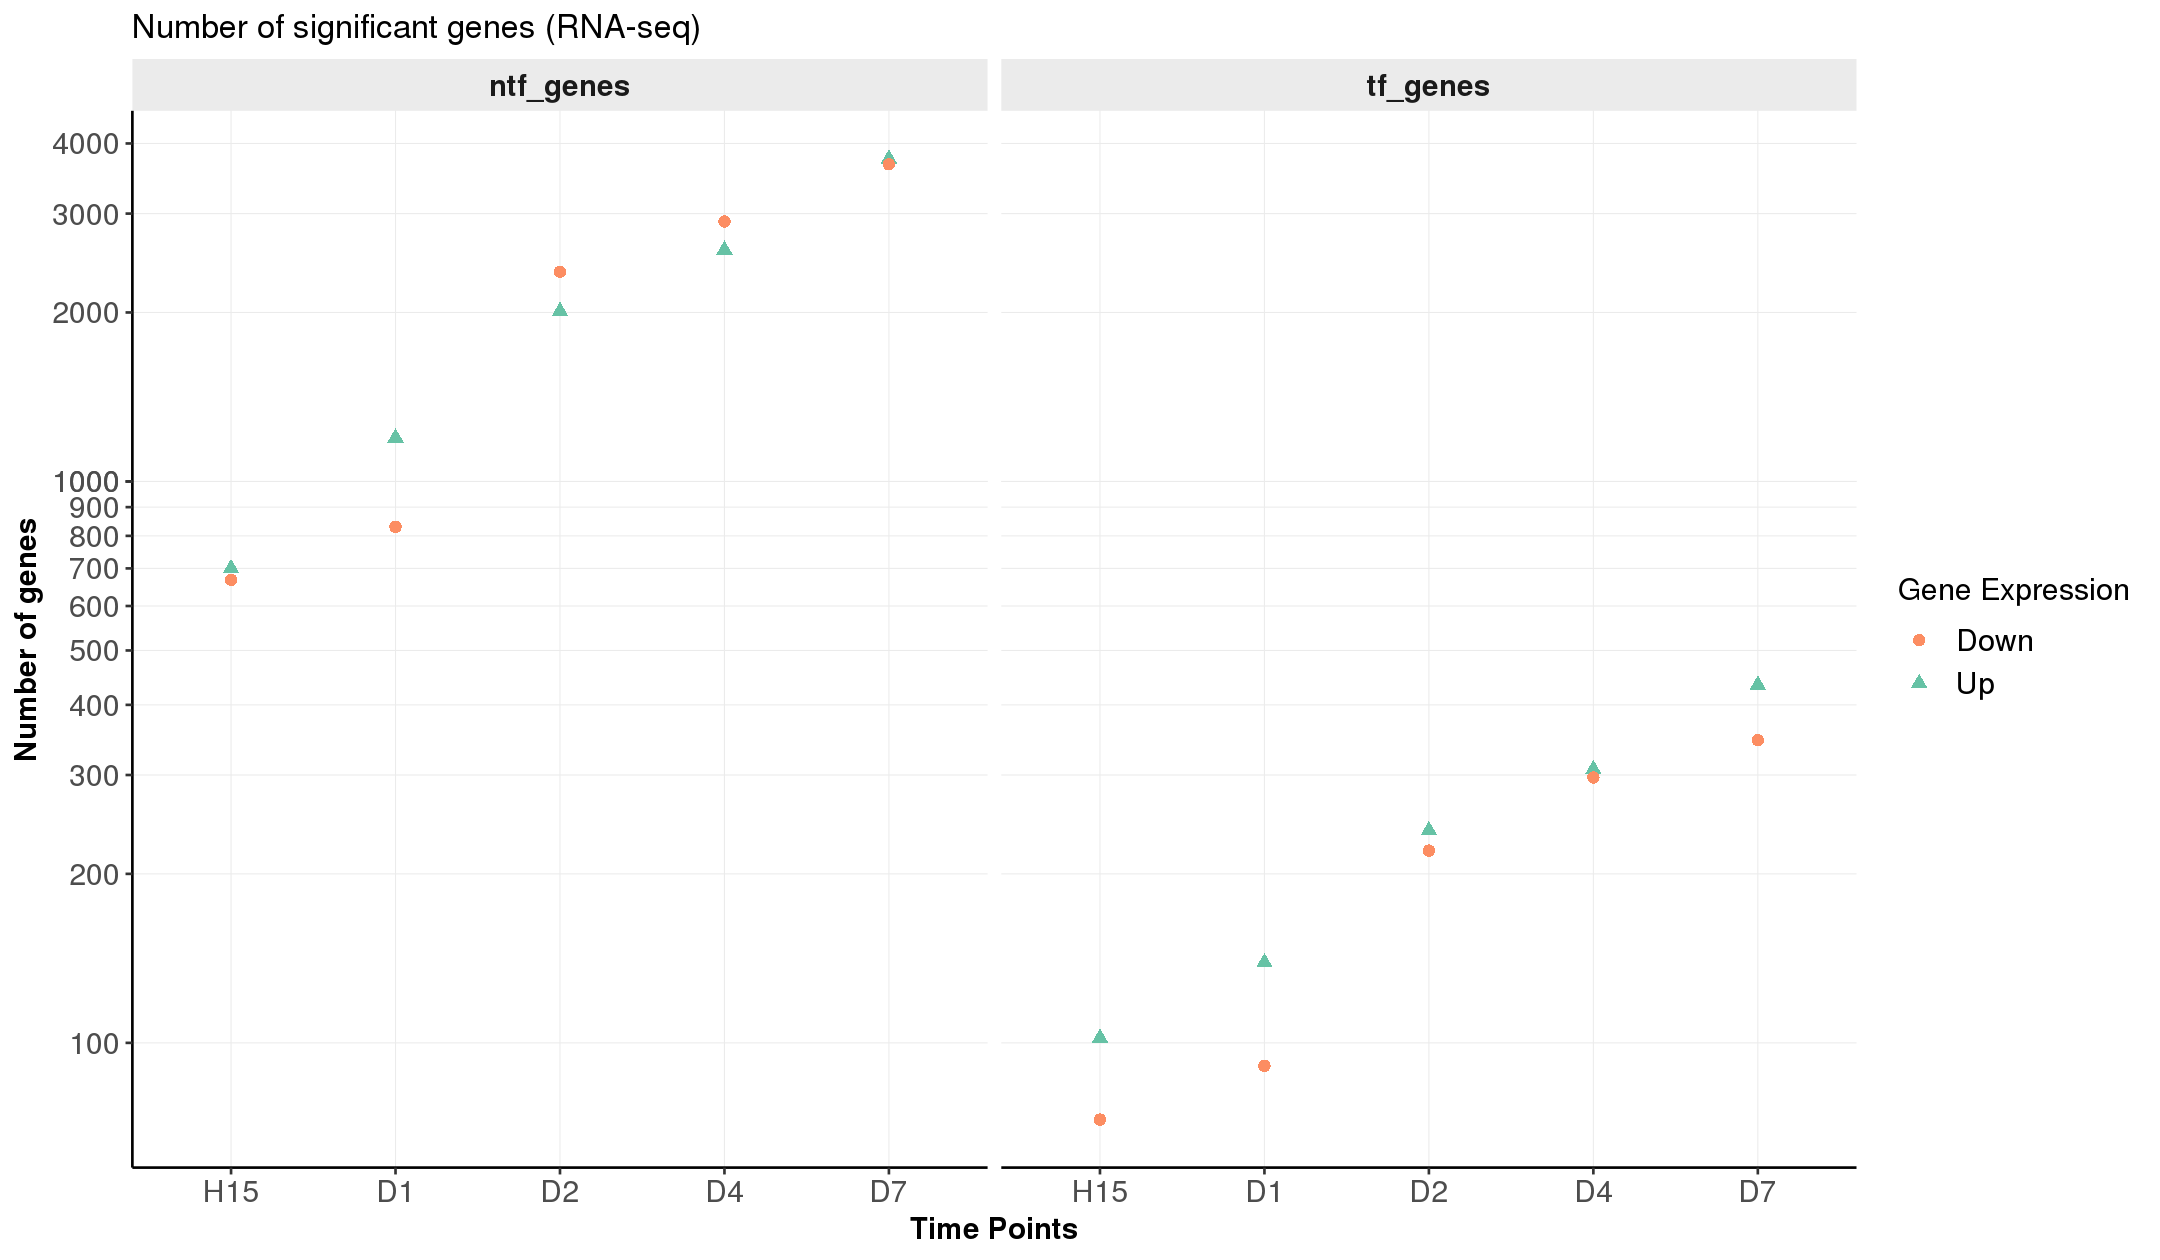

In [37]:
ggplot(ge_trend_plot) + geom_point(aes(time, num, color=direction, shape = direction), size=2) +
            labs(title = "Number of significant genes (RNA-seq)",
                 x = "Time Points", 
                 y = "Number of genes") +
            scale_color_brewer(name = "Gene Expression", 
                               type = "qual", 
                               palette = "Set2", 
                               direction = -1,
                               label = c(dn = "Down", up = "Up")) +
            scale_shape_discrete(name = "Gene Expression", 
                                 label = c(dn = "Down", up = "Up")) +
            scale_y_log10(minor_breaks = mb, breaks = mb) +
            facet_wrap(~ type) +
            my.theme

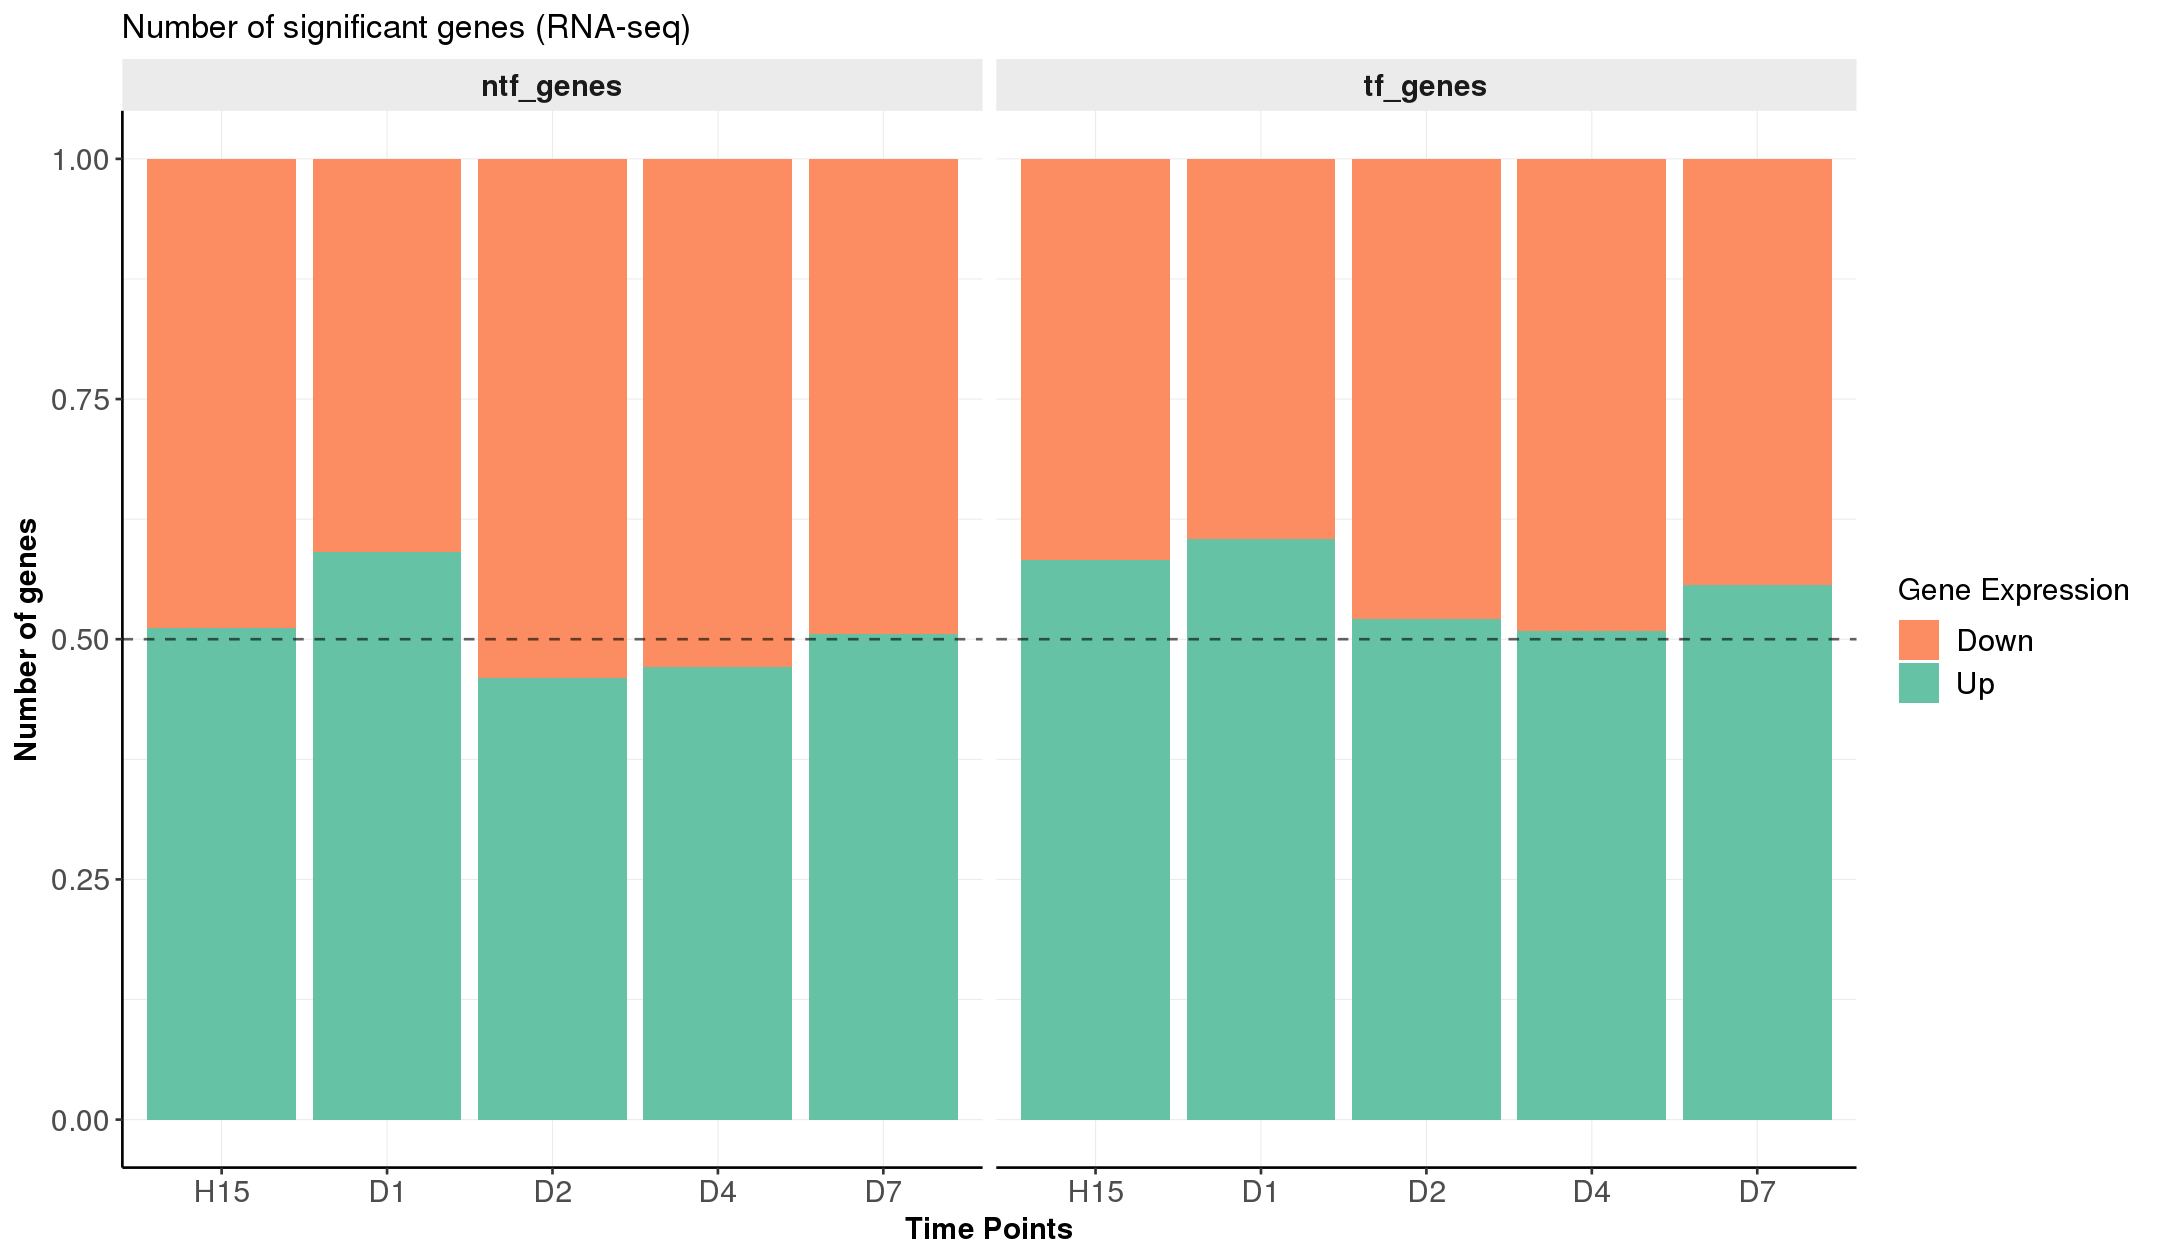

In [38]:
ggplot(ge_trend_plot) + geom_bar(aes(time, num, fill=direction), stat = "identity", position="fill") +
            geom_hline(yintercept = .5, alpha = .6, linetype = "dashed") +
            labs(title = "Number of significant genes (RNA-seq)") + 
            xlab("Time Points") + ylab("Number of genes") +
            scale_fill_brewer(name = "Gene Expression", type = "qual", palette = "Set2", direction = -1,
                              label = c(dn = "Down", up="Up")) +
            facet_wrap(~ type) +
            my.theme

#### Heatmap

In [39]:
library(pheatmap)

In [40]:
ge$D1_vs_ES %>% head
ge$D1_vs_ES %>% dim

gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name,sig,isTF,isHit
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>
ENSG00000000003.14,1093.2455416,0.3900457,0.1809497,2.1555480,0.03111898,0.1524748,TSPAN6,FALSE,FALSE,FALSE
ENSG00000000005.6,4.2712569,-2.0927229,2.0771538,-1.0074954,0.31369677,0.5836887,TNMD,FALSE,FALSE,FALSE
ENSG00000000419.12,562.8246277,-0.1751776,0.3057749,-0.5728974,0.56671416,0.7837188,DPM1,FALSE,FALSE,FALSE
ENSG00000000457.14,66.6639588,0.7868351,0.8209982,0.9583883,0.33786700,0.6072858,SCYL3,FALSE,FALSE,FALSE
ENSG00000000460.17,134.9026604,-0.1684901,0.7727668,-0.2180348,0.82740197,0.9271829,C1orf112,FALSE,FALSE,FALSE
ENSG00000000938.13,0.3862281,3.4345270,4.7586914,0.7217377,0.47045575,NA,FGR,FALSE,FALSE,FALSE


[1] 29757    11

In [41]:
heatmap_df <- map(ge, ~ pull(.x, log2FoldChange))
heatmap_df <- do.call(cbind, heatmap_df) %>% as_tibble

In [42]:
colnames(heatmap_df) <- c("H15", "D1", "D2", "D4", "D7")

In [43]:
heatmap_df <- cbind(select(ge$H15_vs_ES, gene_id, gene_name), heatmap_df)

In [44]:
significance <- map(ge, ~ pull(.x, sig))
significance <- do.call(cbind, significance) %>% as_tibble

In [45]:
heatmap_df <- cbind(heatmap_df, significance)

In [46]:
# first mutate: count number of significant time points
# second mutate: construct a code that represents significance pattern over 5 time points
# third mutate: calculate average l2fc for significant time points
# fourth mutate: indicate whether it is TF or not
# fifth mutate: indicate whether it is Hit TF or not
heatmap_df <- mutate(heatmap_df, sigCounts = H15_vs_ES+D1_vs_ES+D2_vs_ES+D4_vs_ES+D7_vs_ES) %>% 
                mutate(pattern = H15_vs_ES + D1_vs_ES*2 + D2_vs_ES*2^2 + D4_vs_ES*2^3 + D7_vs_ES*2^4) %>%
                mutate(max.abs.l2fc = pmax(abs(H15)*H15_vs_ES, abs(D1)*D1_vs_ES, abs(D2)*D2_vs_ES, abs(D4)*D4_vs_ES, abs(D7)*D7_vs_ES)) %>%
                mutate(isTF = if_else(gene_name %in% tflist, T, F)) %>%
                mutate(isHIT = if_else(gene_name %in% hitlist, T, F))

In [47]:
# remove gene_ids that cause one gene name having multiple gene_ids
heatmap_df <- filter(heatmap_df, !gene_id %in% remove_gene_ids)

In [48]:
pattern.codes <- heatmap_df %>% ungroup %>% select(pattern,  H15_vs_ES:D7_vs_ES) %>% 
                    filter(pattern > 0) %>%
                    distinct %>% arrange(pattern) %>%
                    column_to_rownames("pattern") %>%
                    apply(1, function(x) {map_chr(x * c(15, 1, 2, 4, 7), 
                                                  ~ if_else(.x == 0, "", if_else(.x == 15, paste0("H", .x), paste0("D", .x)))) %>% 
                                          .[. != ""] %>% paste0(., collapse = ".")}) %>%
                    as.data.frame %>% rownames_to_column("pattern") %>% rename("pattern2"=".")

In [49]:
heatmap_df <- mutate_at(heatmap_df, "pattern", ~ as.character(.x)) %>%
                left_join(pattern.codes, by = "pattern") %>%
                mutate_at("pattern", as.integer)

In [50]:
heatmap_df %>% head(5)
dim(heatmap_df)

,gene_id,gene_name,H15,D1,D2,D4,D7,H15_vs_ES,D1_vs_ES,D2_vs_ES,D4_vs_ES,D7_vs_ES,sigCounts,pattern,max.abs.l2fc,isTF,isHIT,pattern2
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<dbl>,<lgl>,<lgl>,<fct>
1,ENSG00000000003.14,TSPAN6,0.4627771,0.3900457,0.44617805,-0.2887279,-1.2998652,FALSE,FALSE,FALSE,FALSE,TRUE,1,16,1.299865,FALSE,FALSE,D7
2,ENSG00000000005.6,TNMD,-0.3569464,-2.0927229,-5.28160385,-4.8403918,-5.4619627,FALSE,FALSE,FALSE,FALSE,TRUE,1,16,5.461963,FALSE,FALSE,D7
3,ENSG00000000419.12,DPM1,-0.3726923,-0.1751776,-0.04997689,-0.3424355,-0.4335166,FALSE,FALSE,FALSE,FALSE,FALSE,0,0,0.000000,FALSE,FALSE,NA
4,ENSG00000000457.14,SCYL3,-0.5357799,0.7868351,0.61865521,1.0405193,0.9733724,FALSE,FALSE,FALSE,FALSE,FALSE,0,0,0.000000,FALSE,FALSE,NA
5,ENSG00000000460.17,C1orf112,0.5850347,-0.1684901,-0.63501390,-2.5606942,-3.0439906,FALSE,FALSE,FALSE,TRUE,TRUE,2,24,3.043991,FALSE,FALSE,D4.D7


[1] 29543    18

In [51]:
# note some of the genes still have multiple gene_ids. This is problematic for pheatmap using gene_name as row names
heatmap_df %>% select(gene_id, gene_name) %>% add_count(gene_name) %>% filter(n>1) %>% arrange(gene_name) %>% head

gene_id,gene_name,n
<chr>,<chr>,<int>
ENSG00000271147.8,ARMCX5-GPRASP2,2
ENSG00000286237.1,ARMCX5-GPRASP2,2
ENSG00000163635.18,ATXN7,2
ENSG00000285258.1,ATXN7,2
ENSG00000197927.13,C2orf27A,2
ENSG00000287151.1,C2orf27A,2


In [52]:
# to address this problem, create a rank within each group, and select only rows with rank=1
heatmap_df <- group_by(heatmap_df, gene_name) %>% 
                    mutate(rank = rank(-max.abs.l2fc, ties.method = "first")) %>% 
                    filter(rank == 1)

### `max.abs.l2fc` cutoff analysis

In [53]:
df0 <- filter(heatmap_df, sigCounts > 1)

In [54]:
df0 %>% head

gene_id,gene_name,H15,D1,D2,D4,D7,H15_vs_ES,D1_vs_ES,D2_vs_ES,D4_vs_ES,D7_vs_ES,sigCounts,pattern,max.abs.l2fc,isTF,isHIT,pattern2,rank
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<dbl>,<lgl>,<lgl>,<fct>,<int>
ENSG00000000460.17,C1orf112,0.5850347,-0.1684901,-0.6350139,-2.5606942,-3.0439906,FALSE,FALSE,FALSE,TRUE,TRUE,2,24,3.043991,FALSE,FALSE,D4.D7,1
ENSG00000001461.17,NIPAL3,0.7798943,1.7114340,1.3023046,0.6141820,0.7415282,FALSE,TRUE,TRUE,FALSE,FALSE,2,6,1.711434,FALSE,FALSE,D1.D2,1
ENSG00000001617.12,SEMA3F,-1.8348933,-0.7635346,-6.3123599,-3.9732193,-1.6982634,FALSE,FALSE,TRUE,TRUE,TRUE,3,28,6.312360,FALSE,FALSE,D2.D4.D7,1
ENSG00000001630.17,CYP51A1,1.7327958,1.2488794,0.4263824,0.5360152,1.6020563,TRUE,TRUE,FALSE,FALSE,TRUE,3,19,1.732796,FALSE,FALSE,H15.D1.D7,1
ENSG00000002586.20,CD99,1.2853105,0.9205293,1.1420945,0.9041245,-0.6101863,TRUE,TRUE,TRUE,TRUE,FALSE,4,15,1.285311,FALSE,FALSE,H15.D1.D2.D4,1
ENSG00000002587.10,HS3ST1,-0.1704085,0.8428847,-0.6788173,2.6757314,3.7827695,FALSE,FALSE,FALSE,TRUE,TRUE,2,24,3.782770,FALSE,FALSE,D4.D7,1


In [55]:
df0s <- map(1:5, ~ filter(heatmap_df, sigCounts >= .x))

In [56]:
num.of.genes.per.l2fc.cutoff <- list()
num.of.TFs.per.l2fc.cutoff <- list()
num.of.HITs.per.l2fc.cutoff <- list()
for (f in df0s) {
    num <- map_int(seq(0,10,0.5), ~ filter(f, max.abs.l2fc > .x) %>% nrow)
    num.tf <- map_int(seq(0,10,0.5), ~ filter(f, max.abs.l2fc > .x & isTF) %>% nrow)
    num.hits <- map_int(seq(0,10,0.5), ~ filter(f, max.abs.l2fc > .x & isHIT) %>% nrow)
    num.of.genes.per.l2fc.cutoff <- c(num.of.genes.per.l2fc.cutoff, list(num))
    num.of.TFs.per.l2fc.cutoff <- c(num.of.TFs.per.l2fc.cutoff, list(num.tf))
    num.of.HITs.per.l2fc.cutoff <- c(num.of.HITs.per.l2fc.cutoff, list(num.hits))
}

In [57]:
names(num.of.genes.per.l2fc.cutoff) <- paste0(rep("sigCounts_ge_"), 1:5)
names(num.of.TFs.per.l2fc.cutoff) <- paste0(rep("sigCounts_ge_"), 1:5)
names(num.of.HITs.per.l2fc.cutoff) <- paste0(rep("sigCounts_ge_"), 1:5)

In [58]:
genes.tally <- imap_dfr(num.of.genes.per.l2fc.cutoff, ~ data.frame(sigCounts = rep(.y, length(.x)), 
                                                        num.genes = .x, 
                                                        max.abs.l2fc = seq(0, 10, .5)))
tfs.tally <- imap_dfr(num.of.TFs.per.l2fc.cutoff, ~ data.frame(sigCounts = rep(.y, length(.x)), 
                                                        num.genes = .x, 
                                                        max.abs.l2fc = seq(0, 10, .5)))
hits.tally <- imap_dfr(num.of.HITs.per.l2fc.cutoff, ~ data.frame(sigCounts = rep(.y, length(.x)), 
                                                        num.genes = .x, 
                                                        max.abs.l2fc = seq(0, 10, .5)))

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and fac

In [59]:
sigCounts.an <- paste0(rep("Num. sig. time points >= ", 5), 1:5)
names(sigCounts.an) <- paste0(rep("sigCounts_ge_", 5), 1:5)

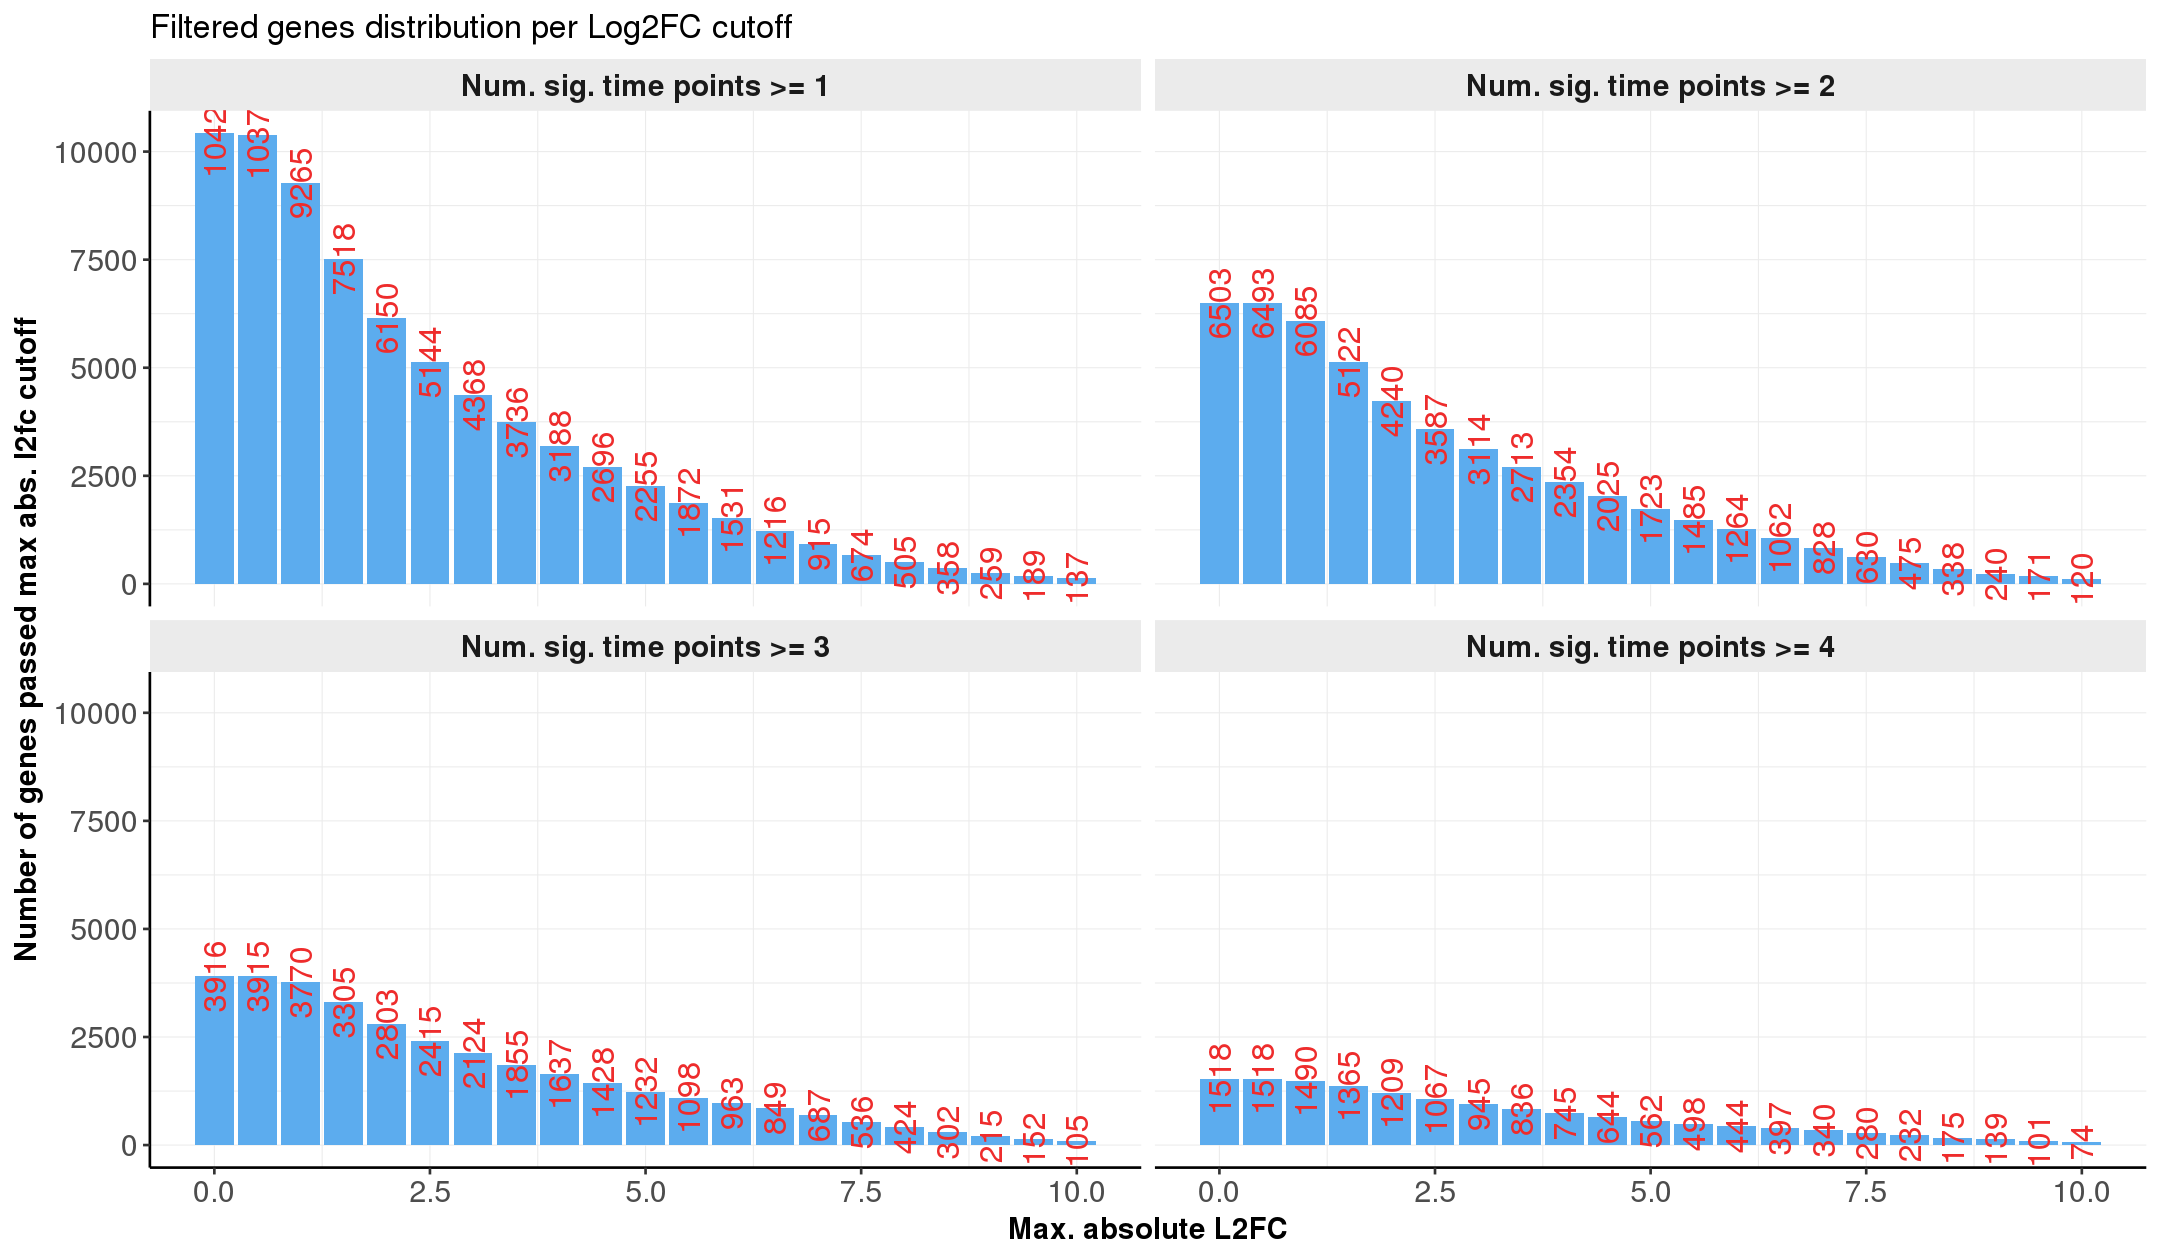

In [60]:
ggplot(filter(genes.tally, str_detect(sigCounts, "[1234]"))) + geom_col(aes(max.abs.l2fc, num.genes), fill = "steelblue2")  + 
    geom_text(aes(max.abs.l2fc, num.genes, label = num.genes), size = 4.5, angle = 90, color = "firebrick2") +
    labs(x = "Max. absolute L2FC", 
         y = "Number of genes passed max abs. l2fc cutoff", 
         title = "Filtered genes distribution per Log2FC cutoff") +
    facet_wrap(~sigCounts, nrow = 2, scales = "fixed", labeller = labeller( sigCounts = sigCounts.an)) +
    my.theme

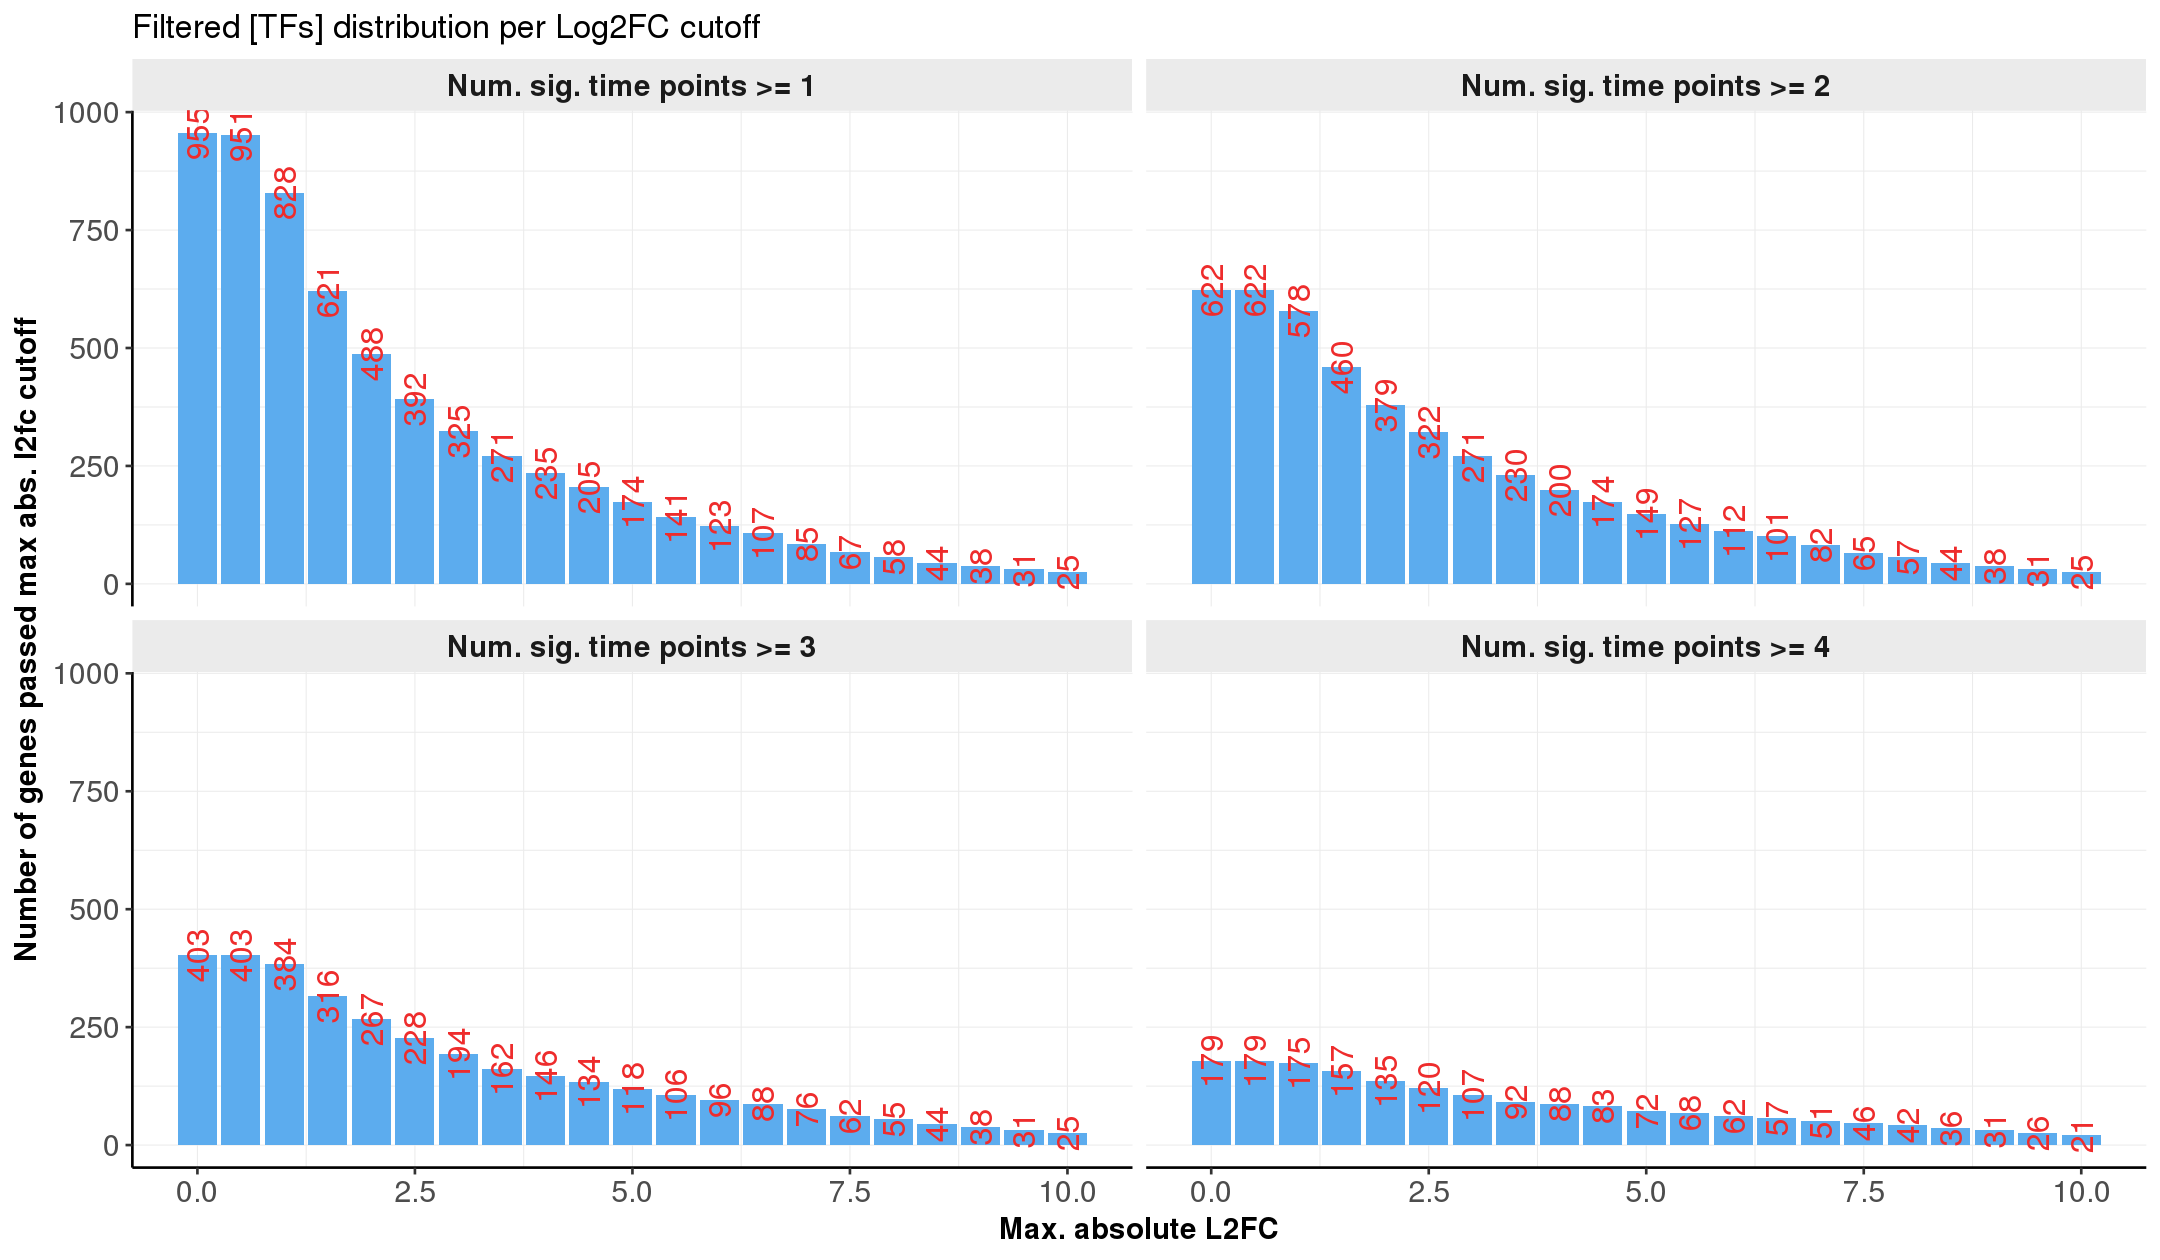

In [61]:
ggplot(filter(tfs.tally, str_detect(sigCounts, "[1234]"))) + geom_col(aes(max.abs.l2fc, num.genes), fill = "steelblue2")  + 
    geom_text(aes(max.abs.l2fc, num.genes, label = num.genes), size = 4.5, angle = 90, color = "firebrick2") +
    labs(x = "Max. absolute L2FC", 
         y = "Number of genes passed max abs. l2fc cutoff", 
         title = "Filtered [TFs] distribution per Log2FC cutoff") +
    facet_wrap(~sigCounts, nrow = 2, scales = "fixed", labeller = labeller( sigCounts = sigCounts.an)) +
    my.theme
    

In [62]:
genes.tally %>% str
tfs.tally %>% str
hits.tally %>% str

'data.frame':	105 obs. of  3 variables:
 $ sigCounts   : chr  "sigCounts_ge_1" "sigCounts_ge_1" "sigCounts_ge_1" "sigCounts_ge_1" ...
 $ num.genes   : int  10422 10375 9265 7518 6150 5144 4368 3736 3188 2696 ...
 $ max.abs.l2fc: num  0 0.5 1 1.5 2 2.5 3 3.5 4 4.5 ...
'data.frame':	105 obs. of  3 variables:
 $ sigCounts   : chr  "sigCounts_ge_1" "sigCounts_ge_1" "sigCounts_ge_1" "sigCounts_ge_1" ...
 $ num.genes   : int  955 951 828 621 488 392 325 271 235 205 ...
 $ max.abs.l2fc: num  0 0.5 1 1.5 2 2.5 3 3.5 4 4.5 ...
'data.frame':	105 obs. of  3 variables:
 $ sigCounts   : chr  "sigCounts_ge_1" "sigCounts_ge_1" "sigCounts_ge_1" "sigCounts_ge_1" ...
 $ num.genes   : int  55 55 51 44 35 32 26 25 21 21 ...
 $ max.abs.l2fc: num  0 0.5 1 1.5 2 2.5 3 3.5 4 4.5 ...


In [63]:
tf.ratio.tally <- inner_join(genes.tally, tfs.tally, by = c("sigCounts", "max.abs.l2fc")) %>% 
                    mutate(tf.ratio = num.genes.y / num.genes.x)

In [84]:
head(genes.tally)
head(hits.tally)

,sigCounts,num.genes,max.abs.l2fc
,<chr>,<int>,<dbl>
1,sigCounts_ge_1,10422,0.0
2,sigCounts_ge_1,10375,0.5
3,sigCounts_ge_1,9265,1.0
4,sigCounts_ge_1,7518,1.5
5,sigCounts_ge_1,6150,2.0
6,sigCounts_ge_1,5144,2.5


,sigCounts,num.genes,max.abs.l2fc
,<chr>,<int>,<dbl>
1,sigCounts_ge_1,55,0.0
2,sigCounts_ge_1,55,0.5
3,sigCounts_ge_1,51,1.0
4,sigCounts_ge_1,44,1.5
5,sigCounts_ge_1,35,2.0
6,sigCounts_ge_1,32,2.5


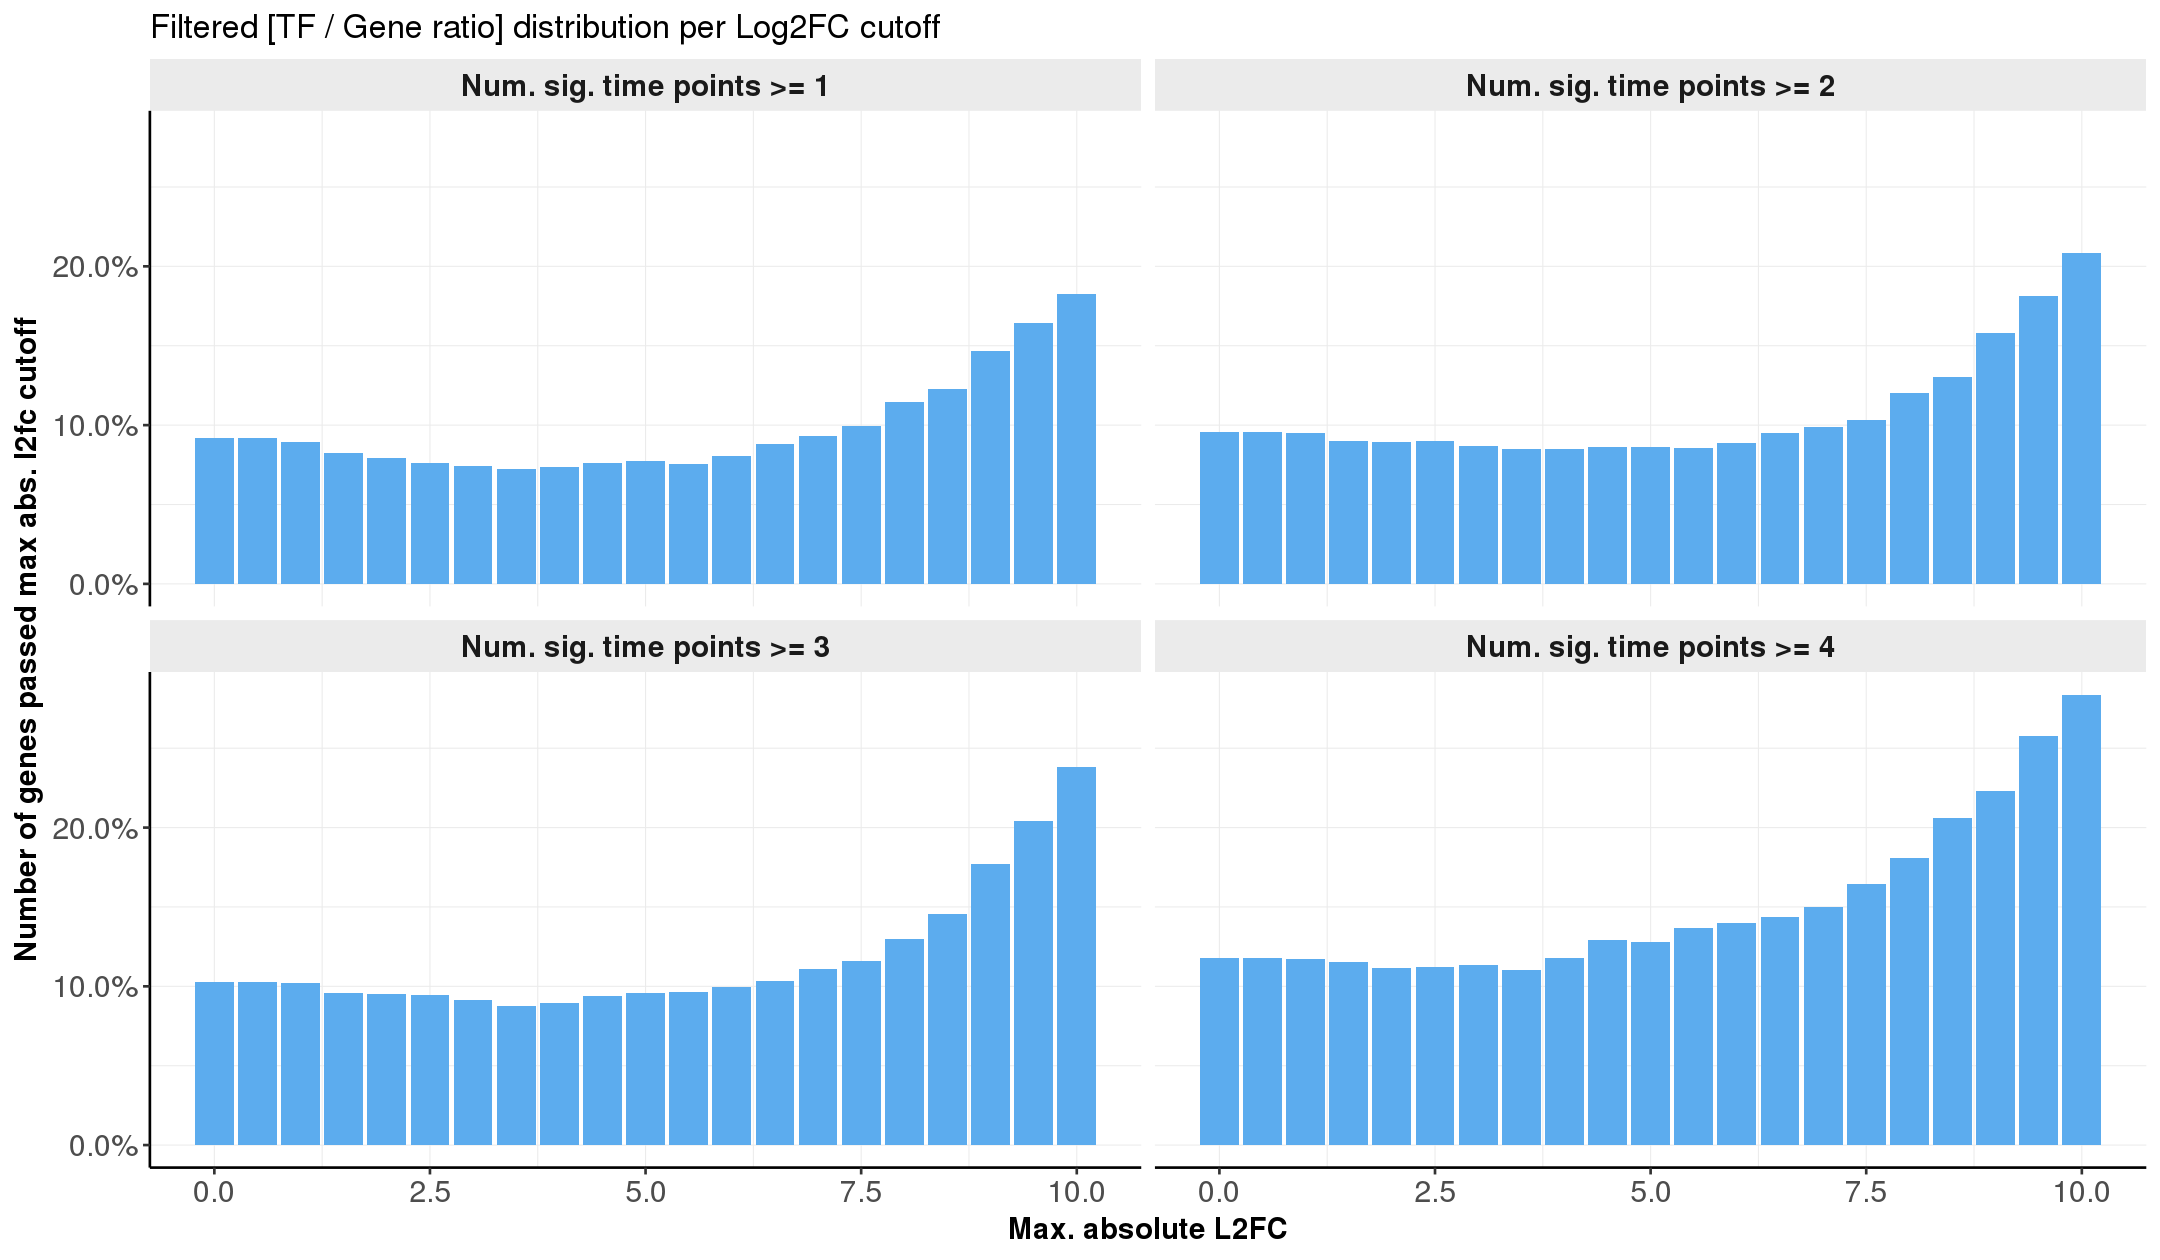

In [64]:
ggplot(filter(tf.ratio.tally, str_detect(sigCounts, "[1234]"))) + geom_col(aes(max.abs.l2fc, tf.ratio), fill = "steelblue2")  +
    labs(x = "Max. absolute L2FC", 
         y = "Number of genes passed max abs. l2fc cutoff", 
         title = "Filtered [TF / Gene ratio] distribution per Log2FC cutoff") +
    facet_wrap(~sigCounts, nrow = 2, scales = "fixed", labeller = labeller( sigCounts = sigCounts.an)) +
    my.theme +
    scale_y_continuous(labels = scales::percent)
    

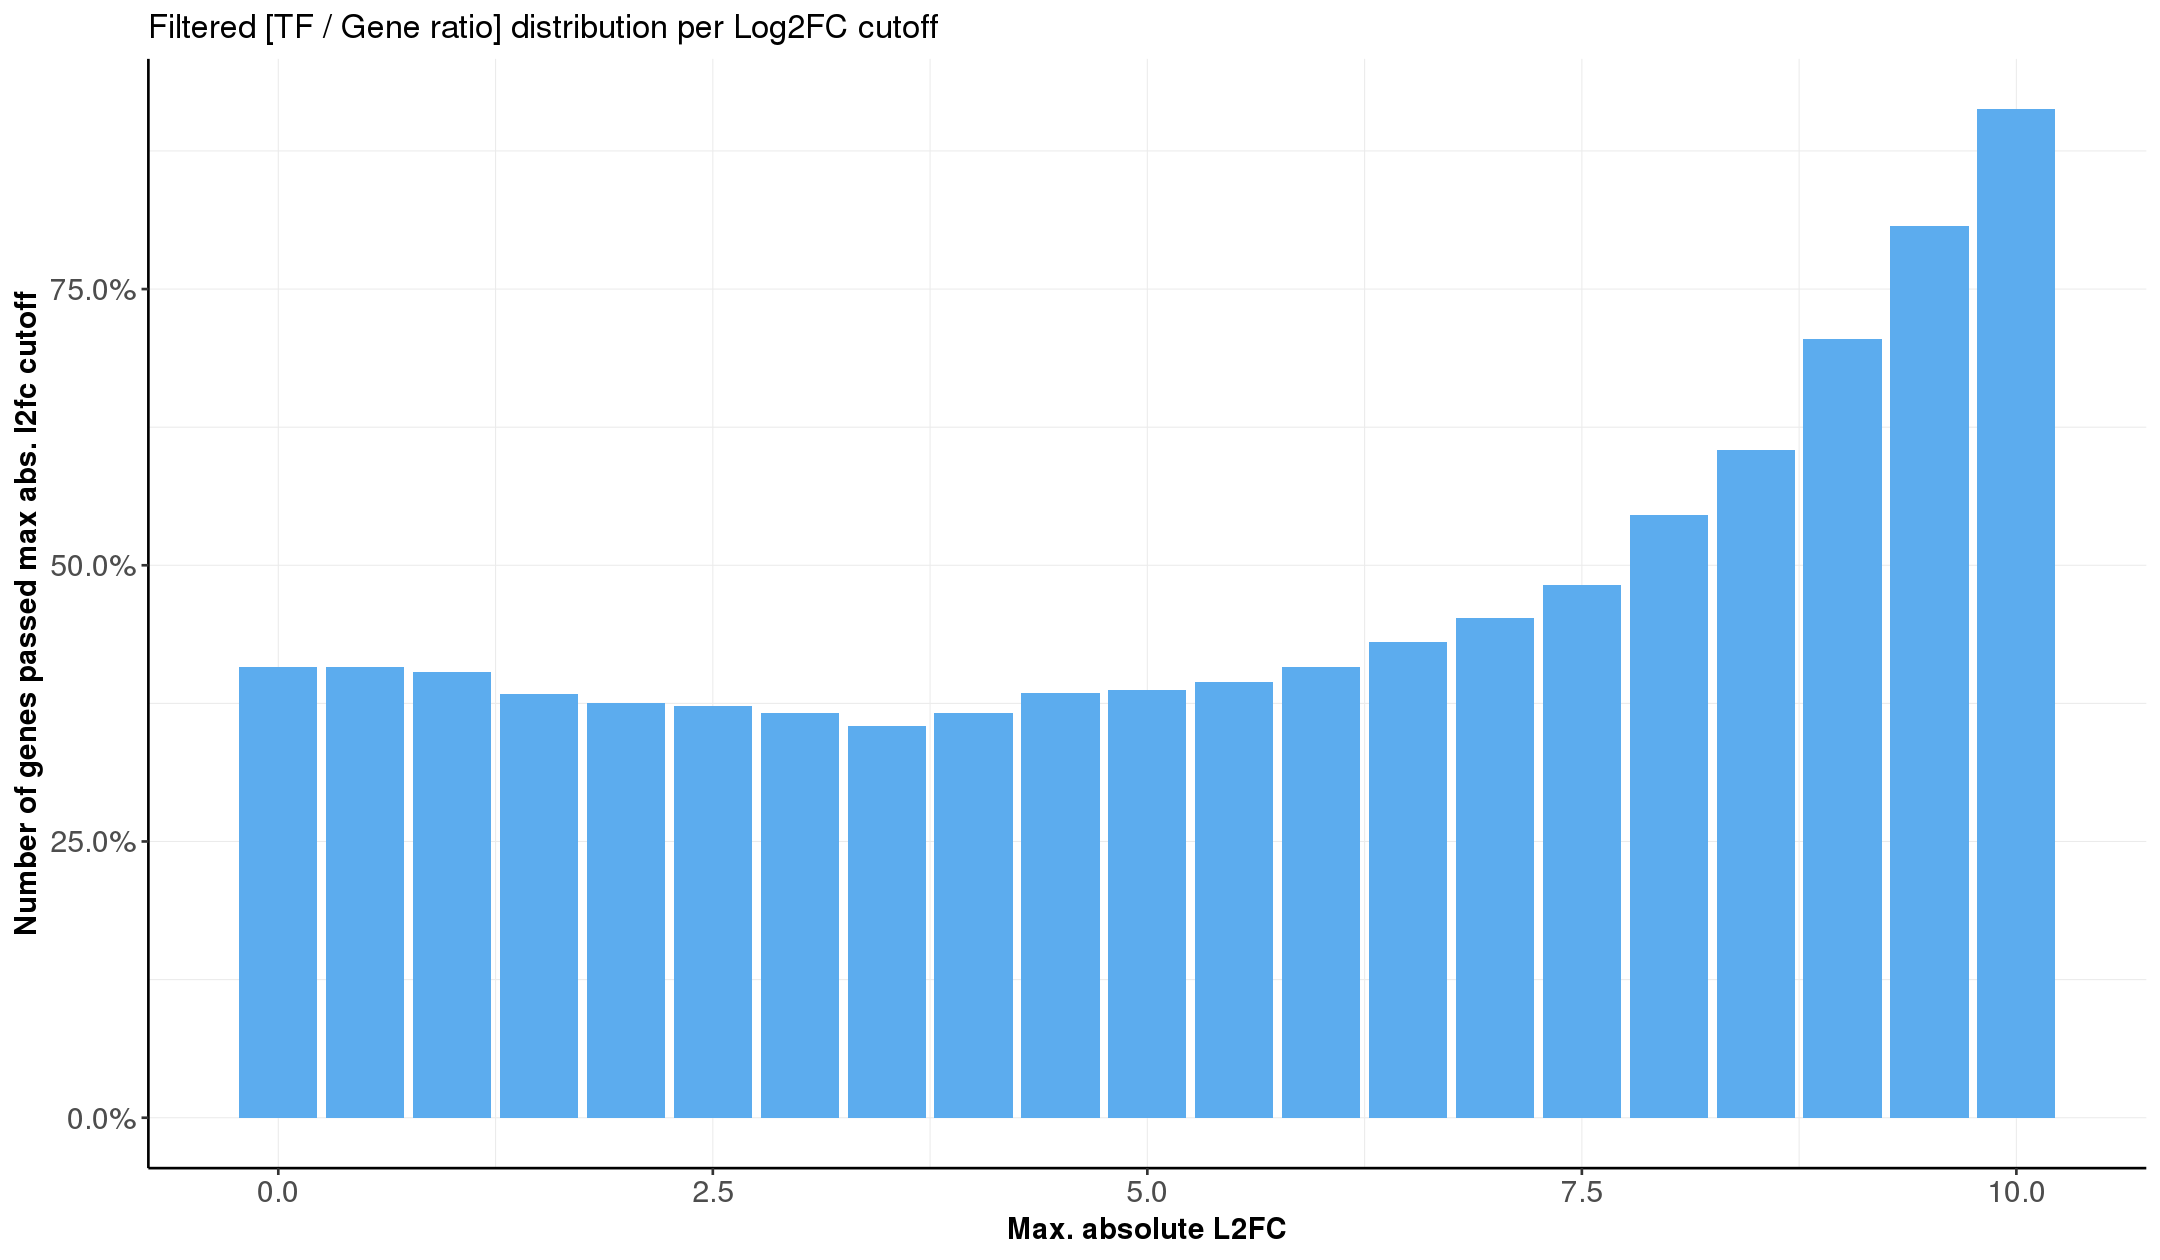

In [80]:
ggplot(filter(tf.ratio.tally, str_detect(sigCounts, "[1234]"))) + geom_col(aes(max.abs.l2fc, tf.ratio), fill = "steelblue2")  +
    labs(x = "Max. absolute L2FC", 
         y = "Number of genes passed max abs. l2fc cutoff", 
         title = "Filtered [TF / Gene ratio] distribution per Log2FC cutoff") +
    my.theme +
    scale_y_continuous(labels = scales::percent)
    

In [65]:
hits.tally %>% t
tfs.tally %>% t

sigCounts,sigCounts_ge_1,sigCounts_ge_1,sigCounts_ge_1,sigCounts_ge_1,sigCounts_ge_1,sigCounts_ge_1,sigCounts_ge_1,sigCounts_ge_1,sigCounts_ge_1,sigCounts_ge_1,⋯,sigCounts_ge_5,sigCounts_ge_5,sigCounts_ge_5,sigCounts_ge_5,sigCounts_ge_5,sigCounts_ge_5,sigCounts_ge_5,sigCounts_ge_5,sigCounts_ge_5,sigCounts_ge_5
num.genes,55,55,51,44,35,32,26,25,21,21,⋯,7,7,7,7,7,6,6,6,6,3
max.abs.l2fc,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,⋯,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0


sigCounts,sigCounts_ge_1,sigCounts_ge_1,sigCounts_ge_1,sigCounts_ge_1,sigCounts_ge_1,sigCounts_ge_1,sigCounts_ge_1,sigCounts_ge_1,sigCounts_ge_1,sigCounts_ge_1,⋯,sigCounts_ge_5,sigCounts_ge_5,sigCounts_ge_5,sigCounts_ge_5,sigCounts_ge_5,sigCounts_ge_5,sigCounts_ge_5,sigCounts_ge_5,sigCounts_ge_5,sigCounts_ge_5
num.genes,955,951,828,621,488,392,325,271,235,205,⋯,39,35,34,32,29,27,25,22,21,16
max.abs.l2fc,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,⋯,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0


#### Distributions

In [97]:
plot_df1 <- mutate_at(heatmap_df, "isHIT", ~ if_else(.x, "Hit", "Non-hit")) %>%
               mutate_at("isTF", ~ if_else(.x, "TF", "Non-TF")) %>%
               mutate_at("pattern2", ~ factor(.x, levels = as.character(pattern.codes$pattern2)))

##### Distributions of sigCounts

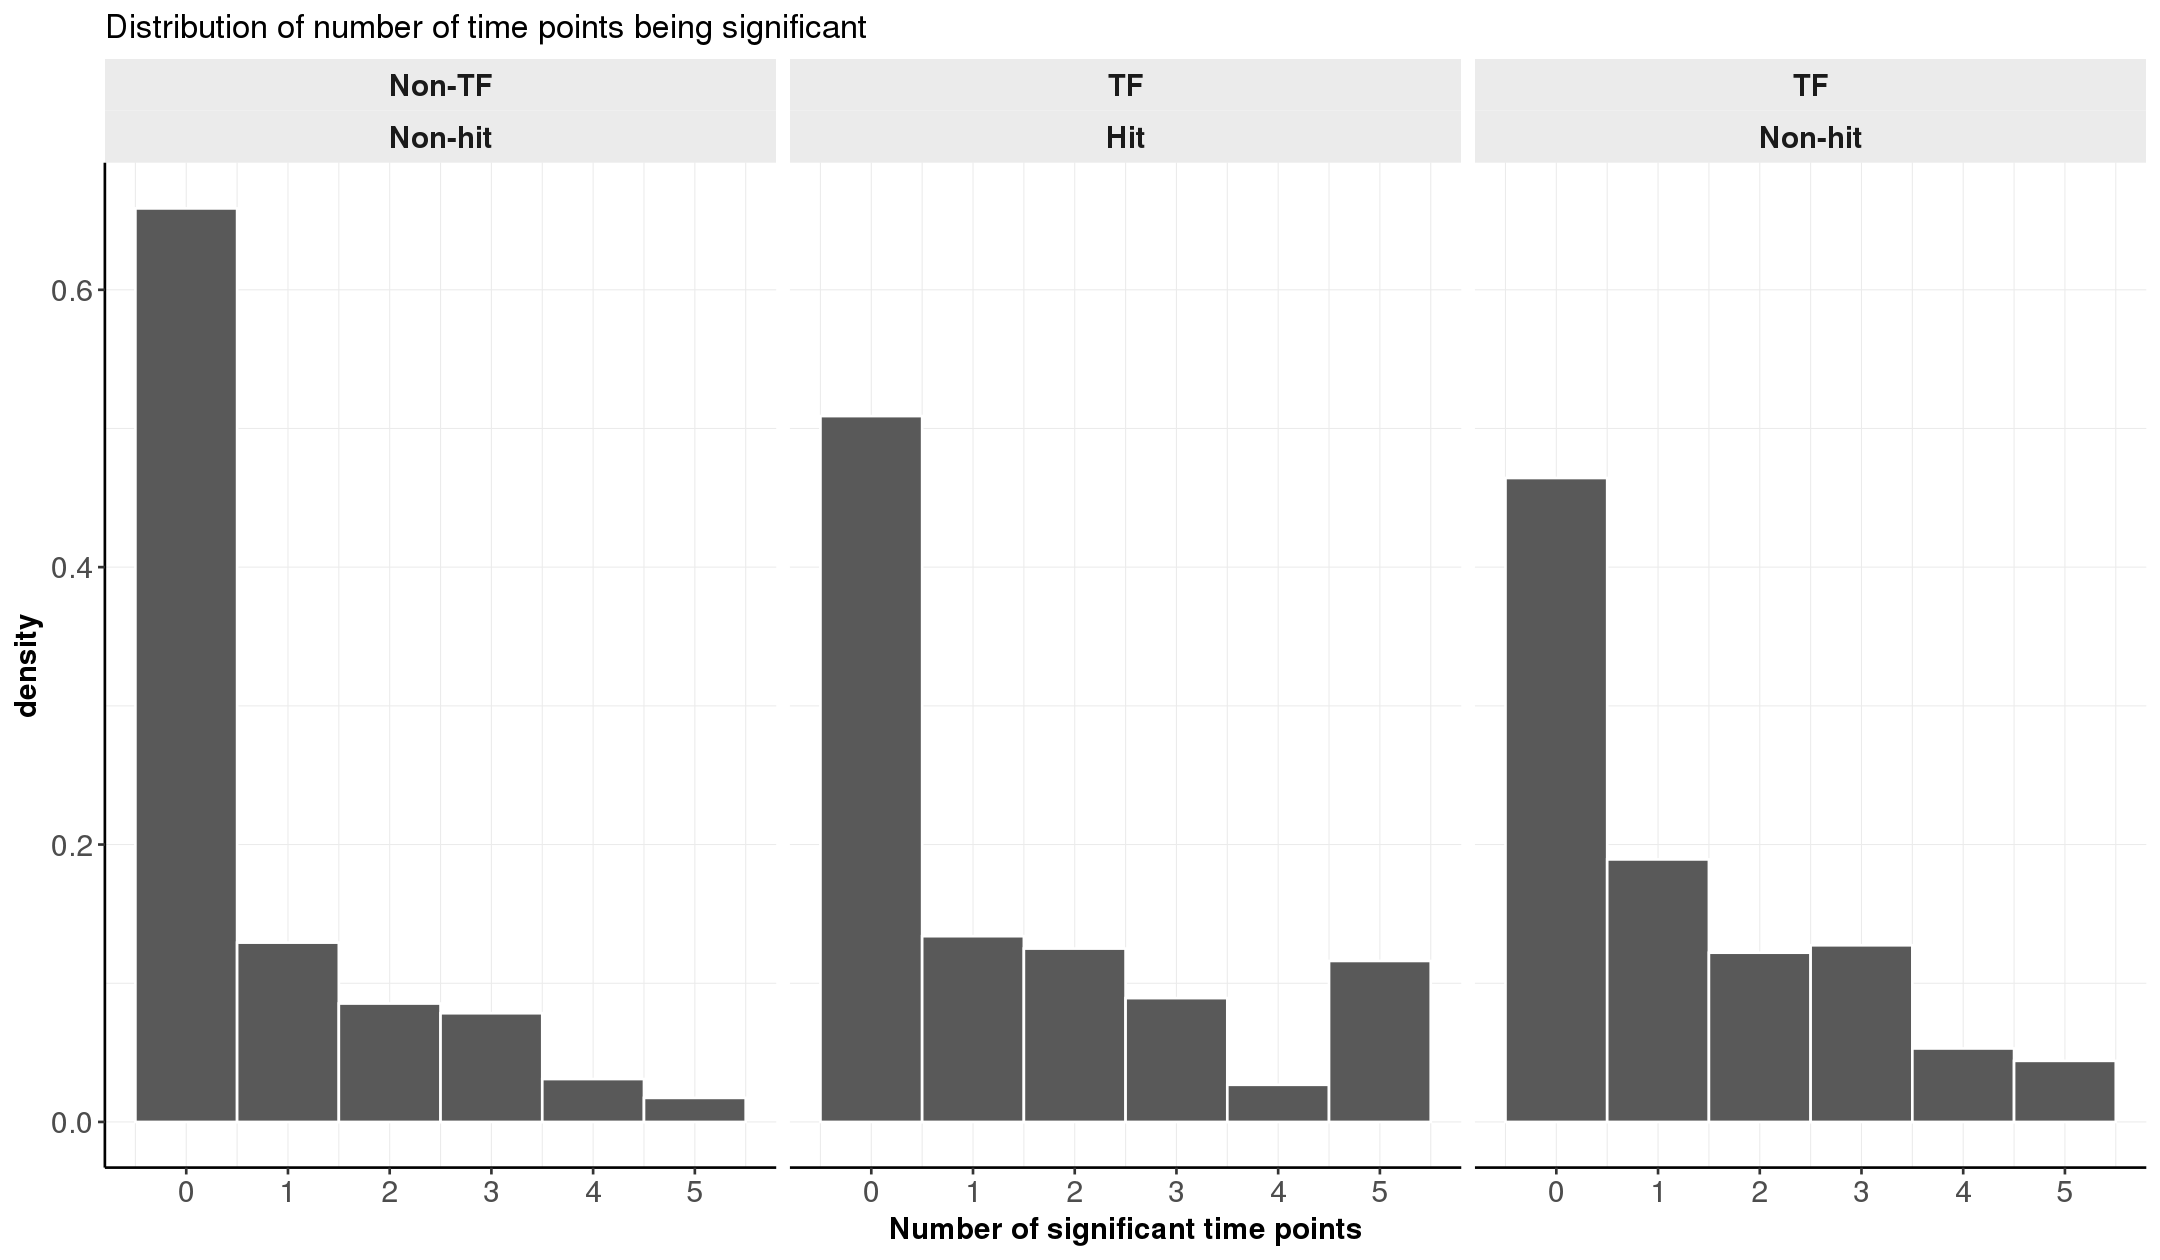

In [98]:
ggplot(plot_df1) + geom_histogram(aes(x = sigCounts, y = ..density..), binwidth = 1, color = 'white') +
        labs(title = "Distribution of number of time points being significant",
             x = "Number of significant time points") +
        scale_x_continuous(breaks = 0:5) + 
        facet_wrap(~ isTF + isHIT) +
        my.theme

#### Distribution of time point patterns

In [99]:
pattern.labels <- pattern.codes$pattern2
names(pattern.labels) <- pattern.codes$pattern

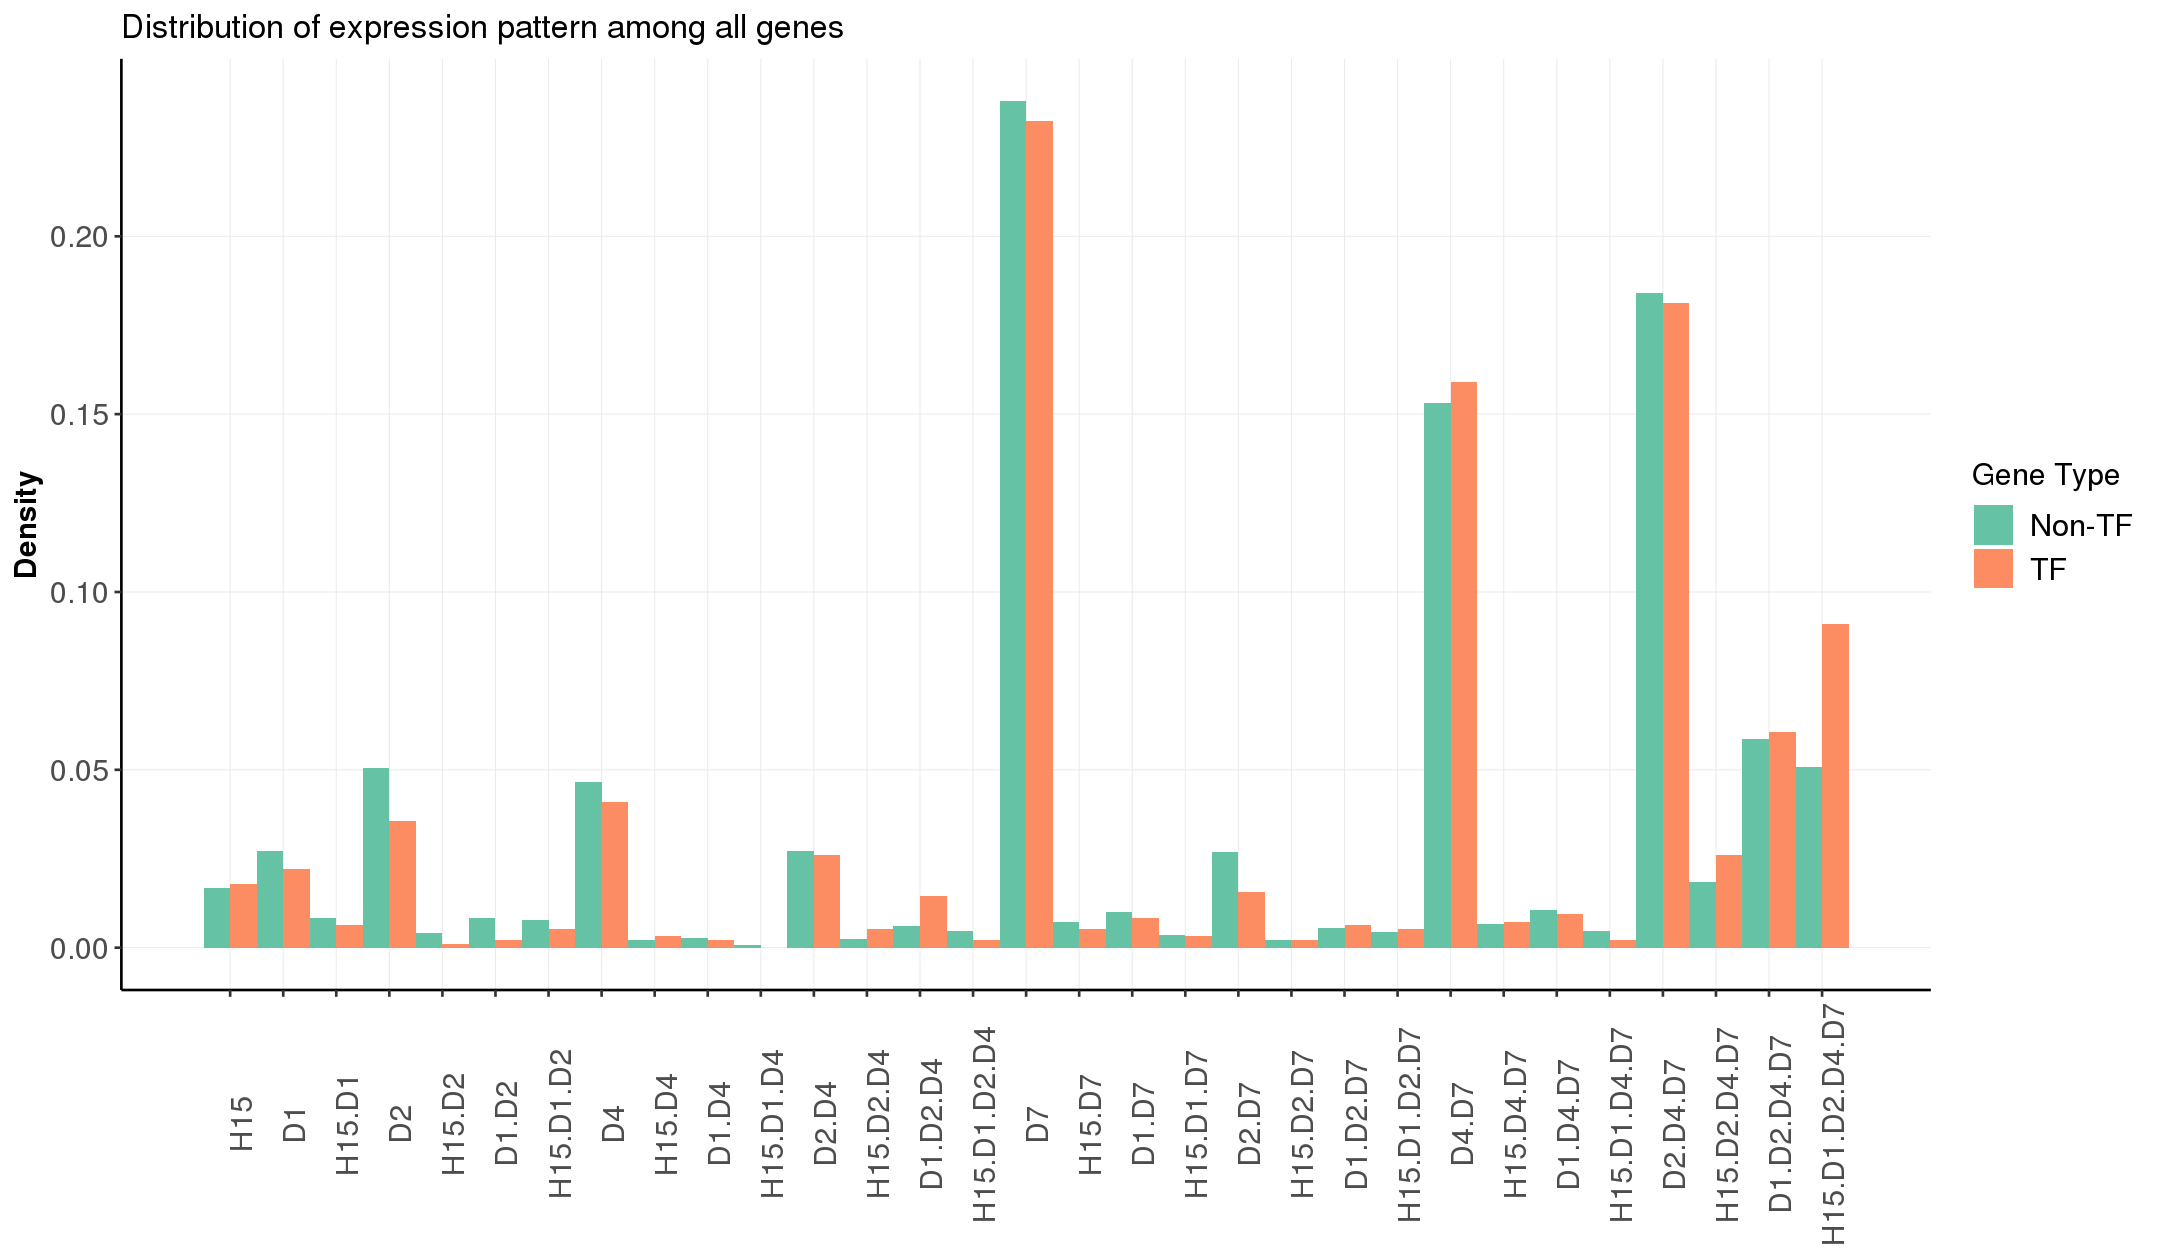

In [100]:
filter(plot_df1, sigCounts > 0) %>%
ggplot() +
        geom_histogram(aes(x = pattern, y = ..density.., fill = isTF), binwidth = 1, position = "dodge") +
        labs(title = "Distribution of expression pattern among all genes", x = NULL, y = "Density") +
        scale_x_continuous(breaks = 1:31, labels = pattern.labels) + 
        scale_fill_brewer(name = "Gene Type", type = "qual", palette = "Set2") +
        my.theme +
        theme(panel.grid.minor = element_line(size = 0), axis.text.x = element_text(angle = 90))

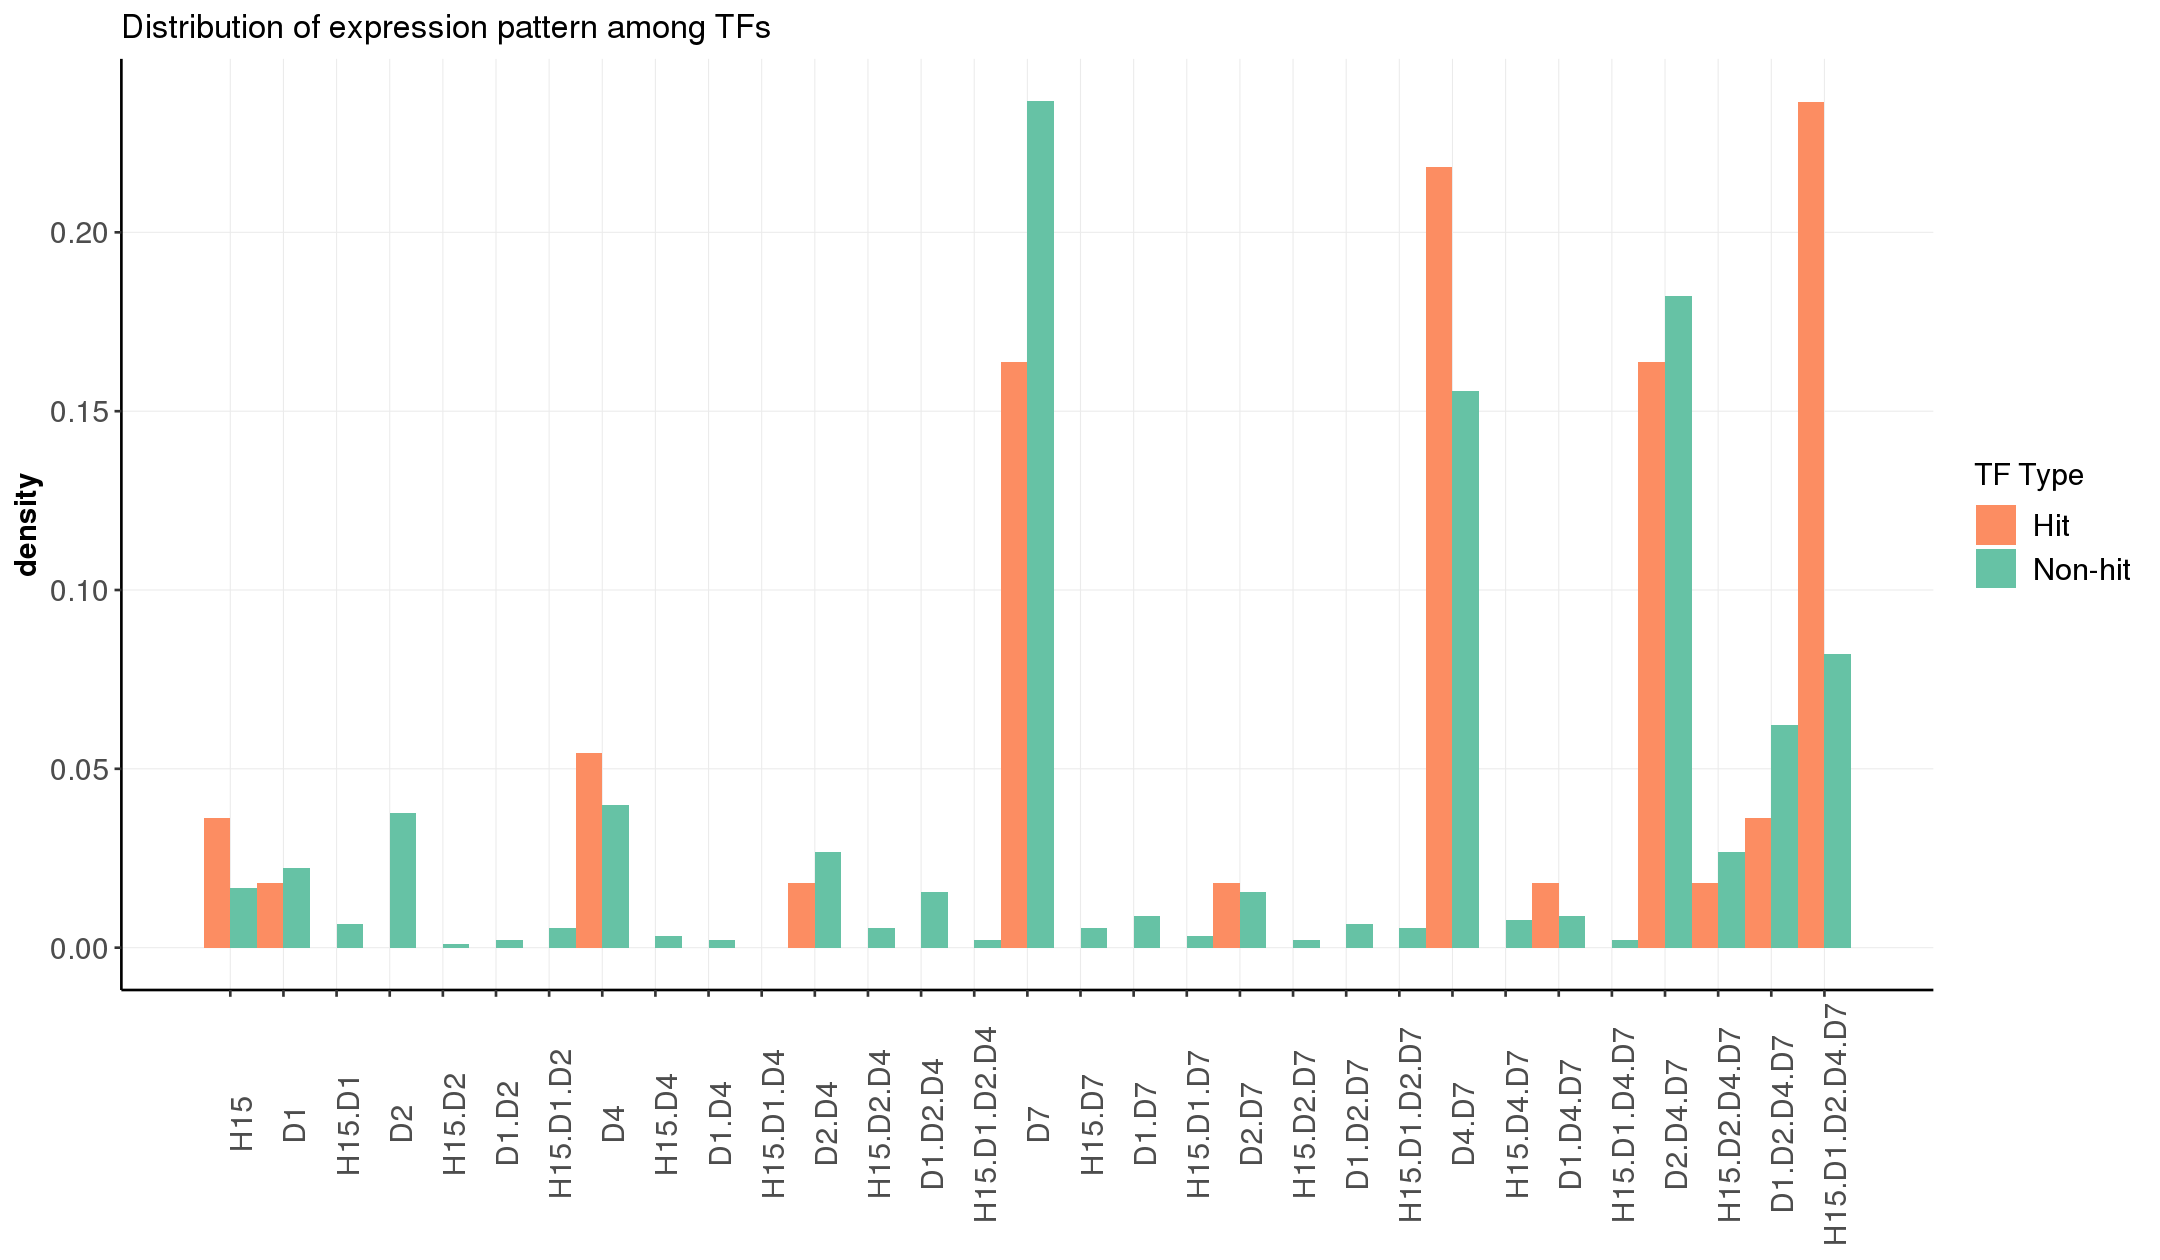

In [101]:
filter(plot_df1, sigCounts > 0 & isTF == "TF") %>%
ggplot() +
        geom_histogram(aes(x = pattern, y = ..density.., fill = isHIT), binwidth = 1, position = "dodge") +
        labs(title = "Distribution of expression pattern among TFs", x = NULL) +
        scale_x_continuous(breaks = 1:31, labels = pattern.labels) + 
        scale_fill_brewer(name = "TF Type", type = "qual", palette = "Set2", direction = -1) +
        my.theme +
        theme(panel.grid.minor = element_line(size = 0), axis.text.x = element_text(angle = 90))

In [72]:
heatmap_df %>% select(gene_name, sigCounts:isHIT) %>% head

gene_name,sigCounts,pattern,max.abs.l2fc,isTF,isHIT
<chr>,<int>,<int>,<dbl>,<lgl>,<lgl>
TSPAN6,1,16,1.299865,FALSE,FALSE
TNMD,1,16,5.461963,FALSE,FALSE
DPM1,0,0,0.000000,FALSE,FALSE
SCYL3,0,0,0.000000,FALSE,FALSE
C1orf112,2,24,3.043991,FALSE,FALSE
FGR,0,0,0.000000,FALSE,FALSE


##### Distributions of `maximum Log2FC`

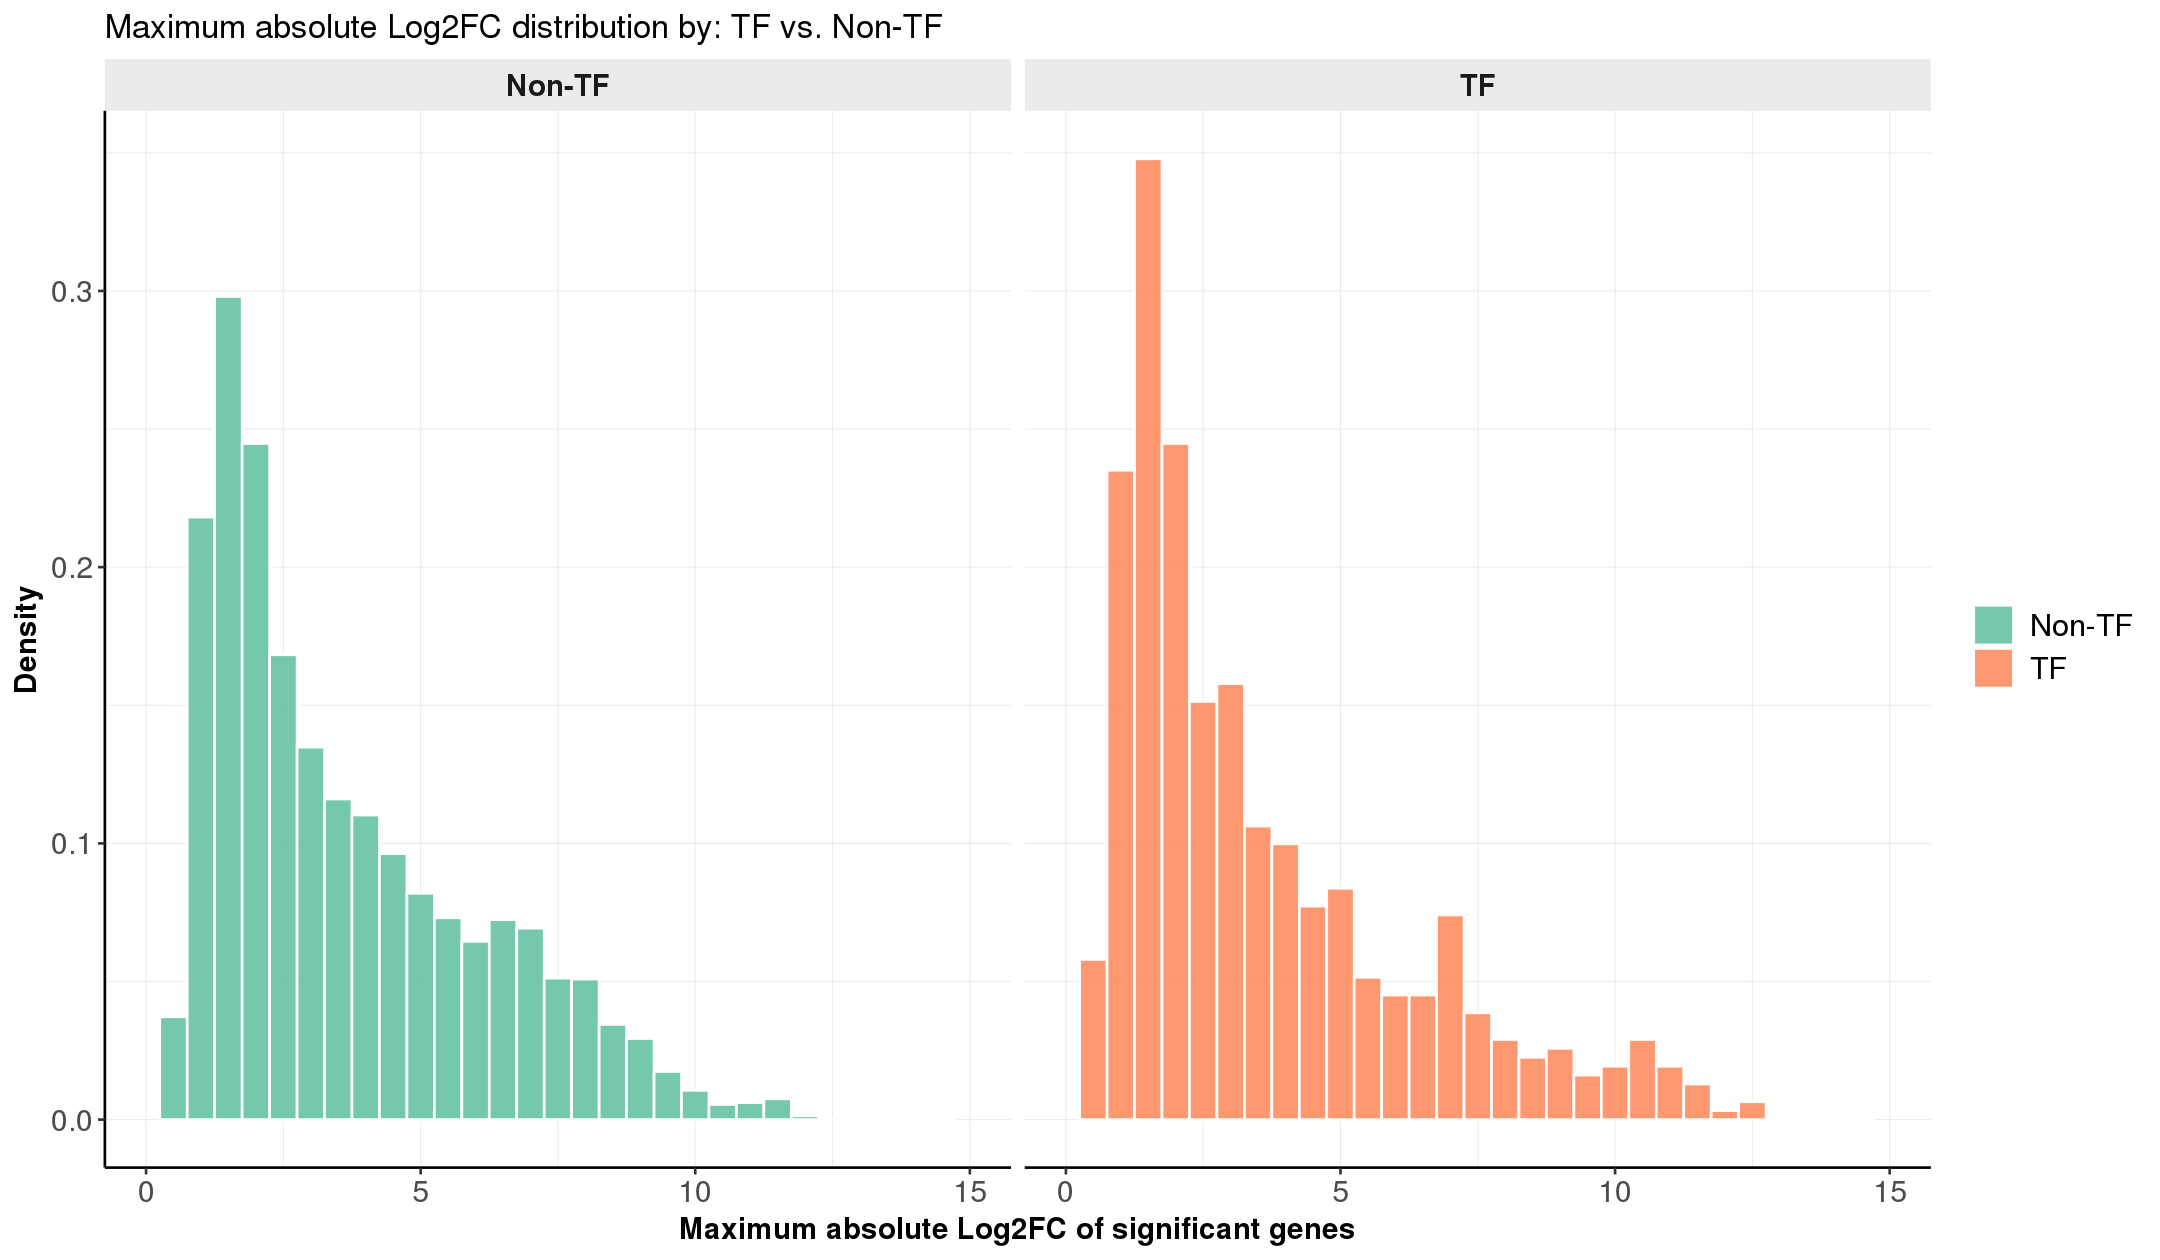

In [73]:
plot_df1 %>% filter(sigCounts > 1) %>%
    ggplot() +
        geom_histogram(aes(x = max.abs.l2fc, y = ..density.., fill = isTF), 
                       binwidth = .5, na.rm = T, alpha = .9, color = "white") +
        lims(x = c(0,15)) +
        my.theme +
        facet_grid( ~isTF) +
        labs(title = "Maximum absolute Log2FC distribution by: TF vs. Non-TF",
             x = "Maximum absolute Log2FC of significant genes",
             y = "Density") +
        scale_fill_brewer(name = NULL, type = "qual", palette = "Set2")

In [85]:
head(plot_df1)

gene_id,gene_name,H15,D1,D2,D4,D7,H15_vs_ES,D1_vs_ES,D2_vs_ES,D4_vs_ES,D7_vs_ES,sigCounts,pattern,max.abs.l2fc,isTF,isHIT,pattern2,rank
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<dbl>,<chr>,<chr>,<fct>,<int>
ENSG00000000003.14,TSPAN6,0.4627771,0.3900457,0.44617805,-0.2887279,-1.2998652,FALSE,FALSE,FALSE,FALSE,TRUE,1,16,1.299865,Non-TF,Non-hit,D7,1
ENSG00000000005.6,TNMD,-0.3569464,-2.0927229,-5.28160385,-4.8403918,-5.4619627,FALSE,FALSE,FALSE,FALSE,TRUE,1,16,5.461963,Non-TF,Non-hit,D7,1
ENSG00000000419.12,DPM1,-0.3726923,-0.1751776,-0.04997689,-0.3424355,-0.4335166,FALSE,FALSE,FALSE,FALSE,FALSE,0,0,0.000000,Non-TF,Non-hit,NA,1
ENSG00000000457.14,SCYL3,-0.5357799,0.7868351,0.61865521,1.0405193,0.9733724,FALSE,FALSE,FALSE,FALSE,FALSE,0,0,0.000000,Non-TF,Non-hit,NA,1
ENSG00000000460.17,C1orf112,0.5850347,-0.1684901,-0.63501390,-2.5606942,-3.0439906,FALSE,FALSE,FALSE,TRUE,TRUE,2,24,3.043991,Non-TF,Non-hit,D4.D7,1
ENSG00000000938.13,FGR,1.9566390,3.4345270,1.21960062,0.0000000,0.0000000,FALSE,FALSE,FALSE,FALSE,FALSE,0,0,0.000000,Non-TF,Non-hit,NA,1


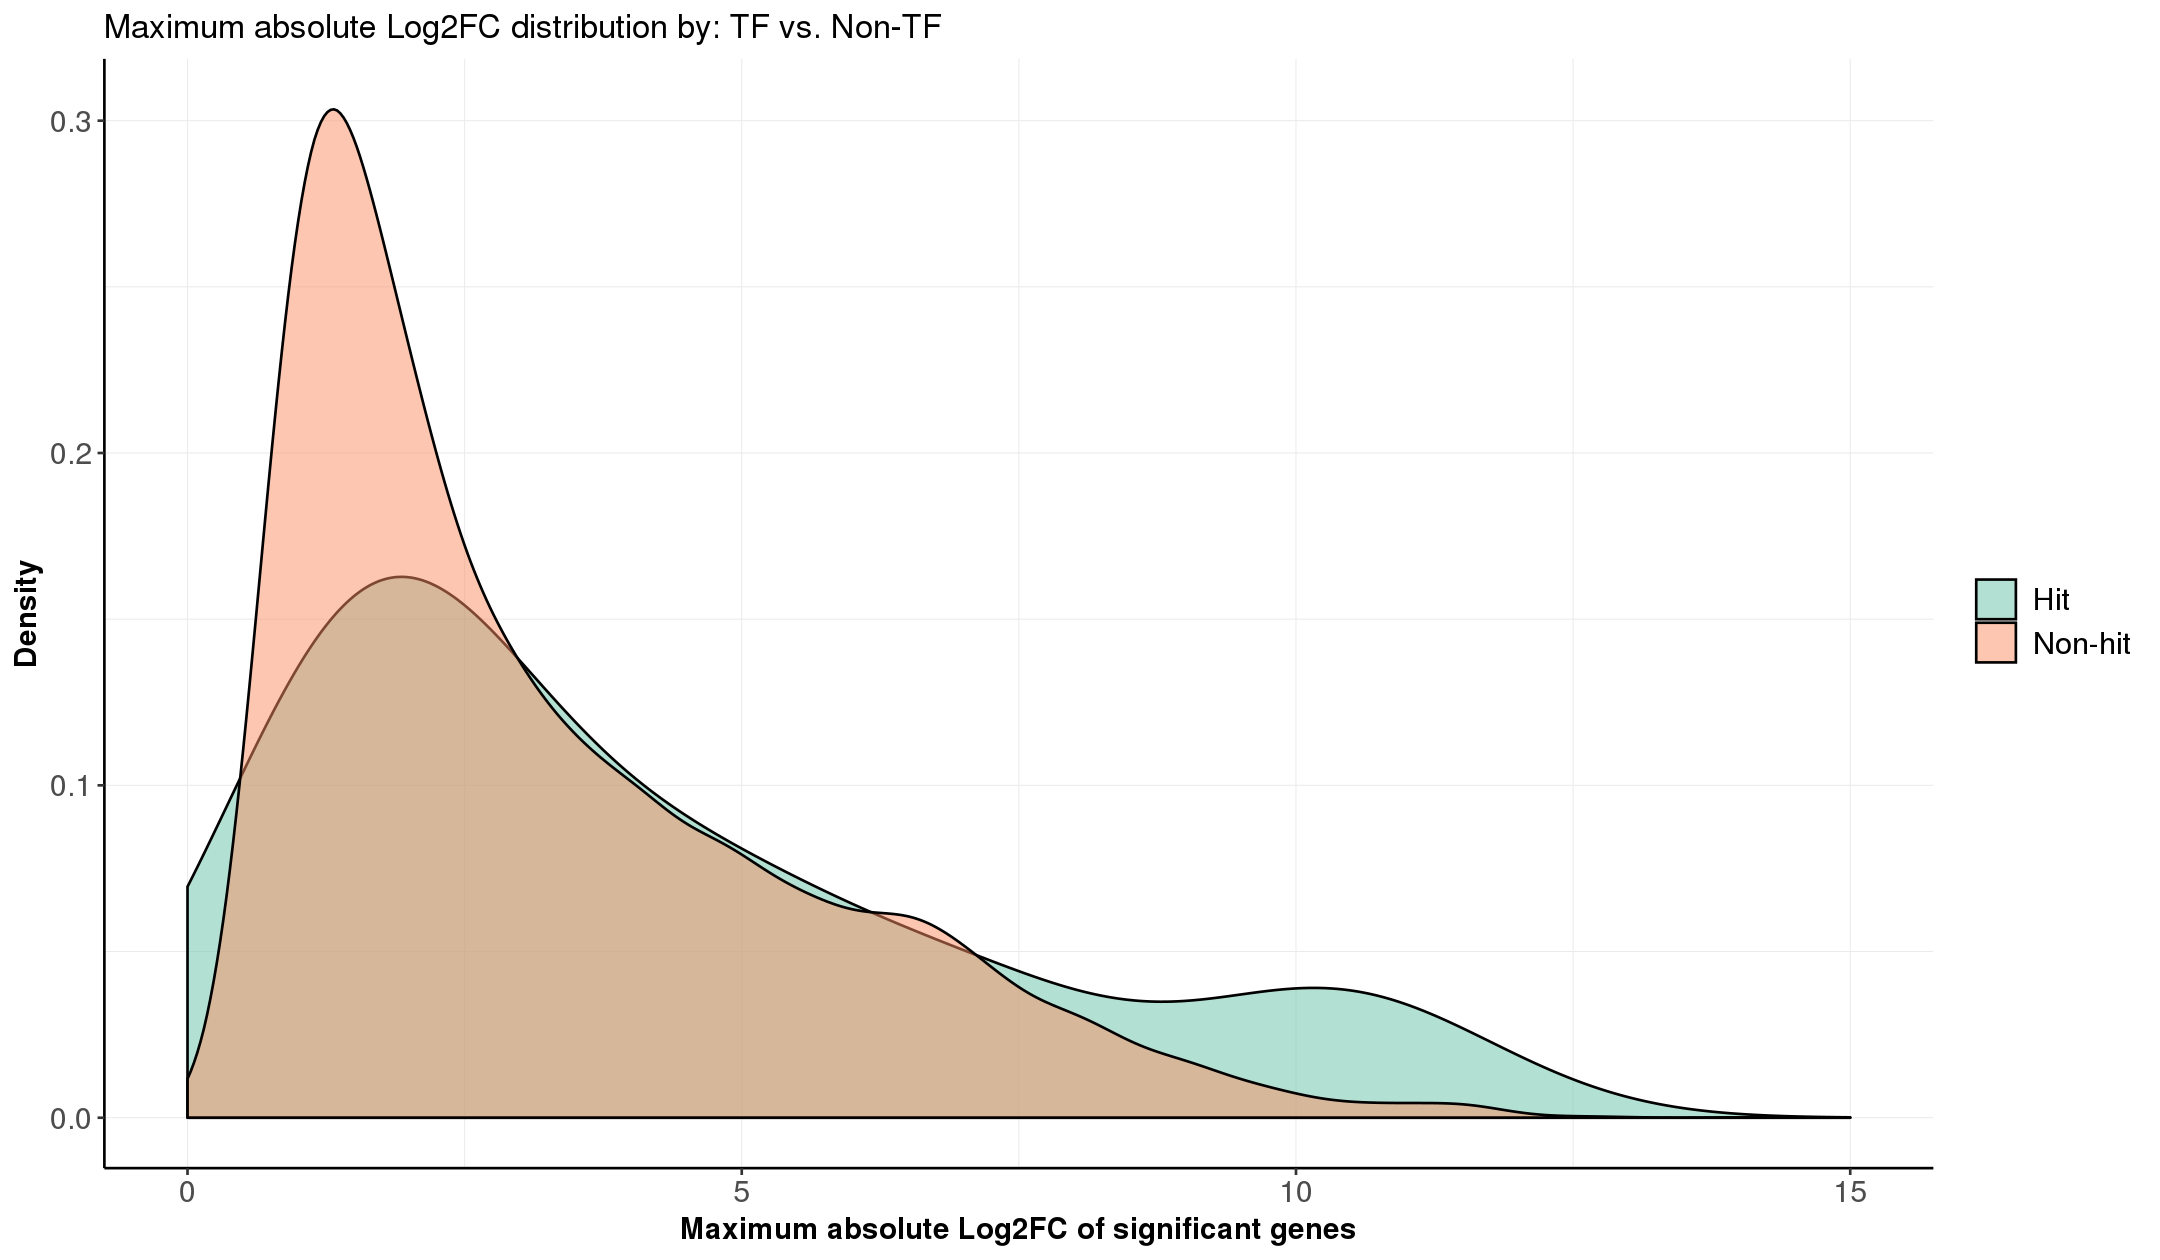

In [93]:
plot_df1 %>% filter(sigCounts > 0) %>%
    ggplot() +
        geom_density(aes(x = max.abs.l2fc, fill = isHIT), na.rm = T, alpha = .5) +
        lims(x = c(0,15)) +
        my.theme +
        labs(title = "Maximum absolute Log2FC distribution by: TF vs. Non-TF",
             x = "Maximum absolute Log2FC of significant genes",
             y = "Density") +
        scale_fill_brewer(name = NULL, type = "qual", palette = "Set2")

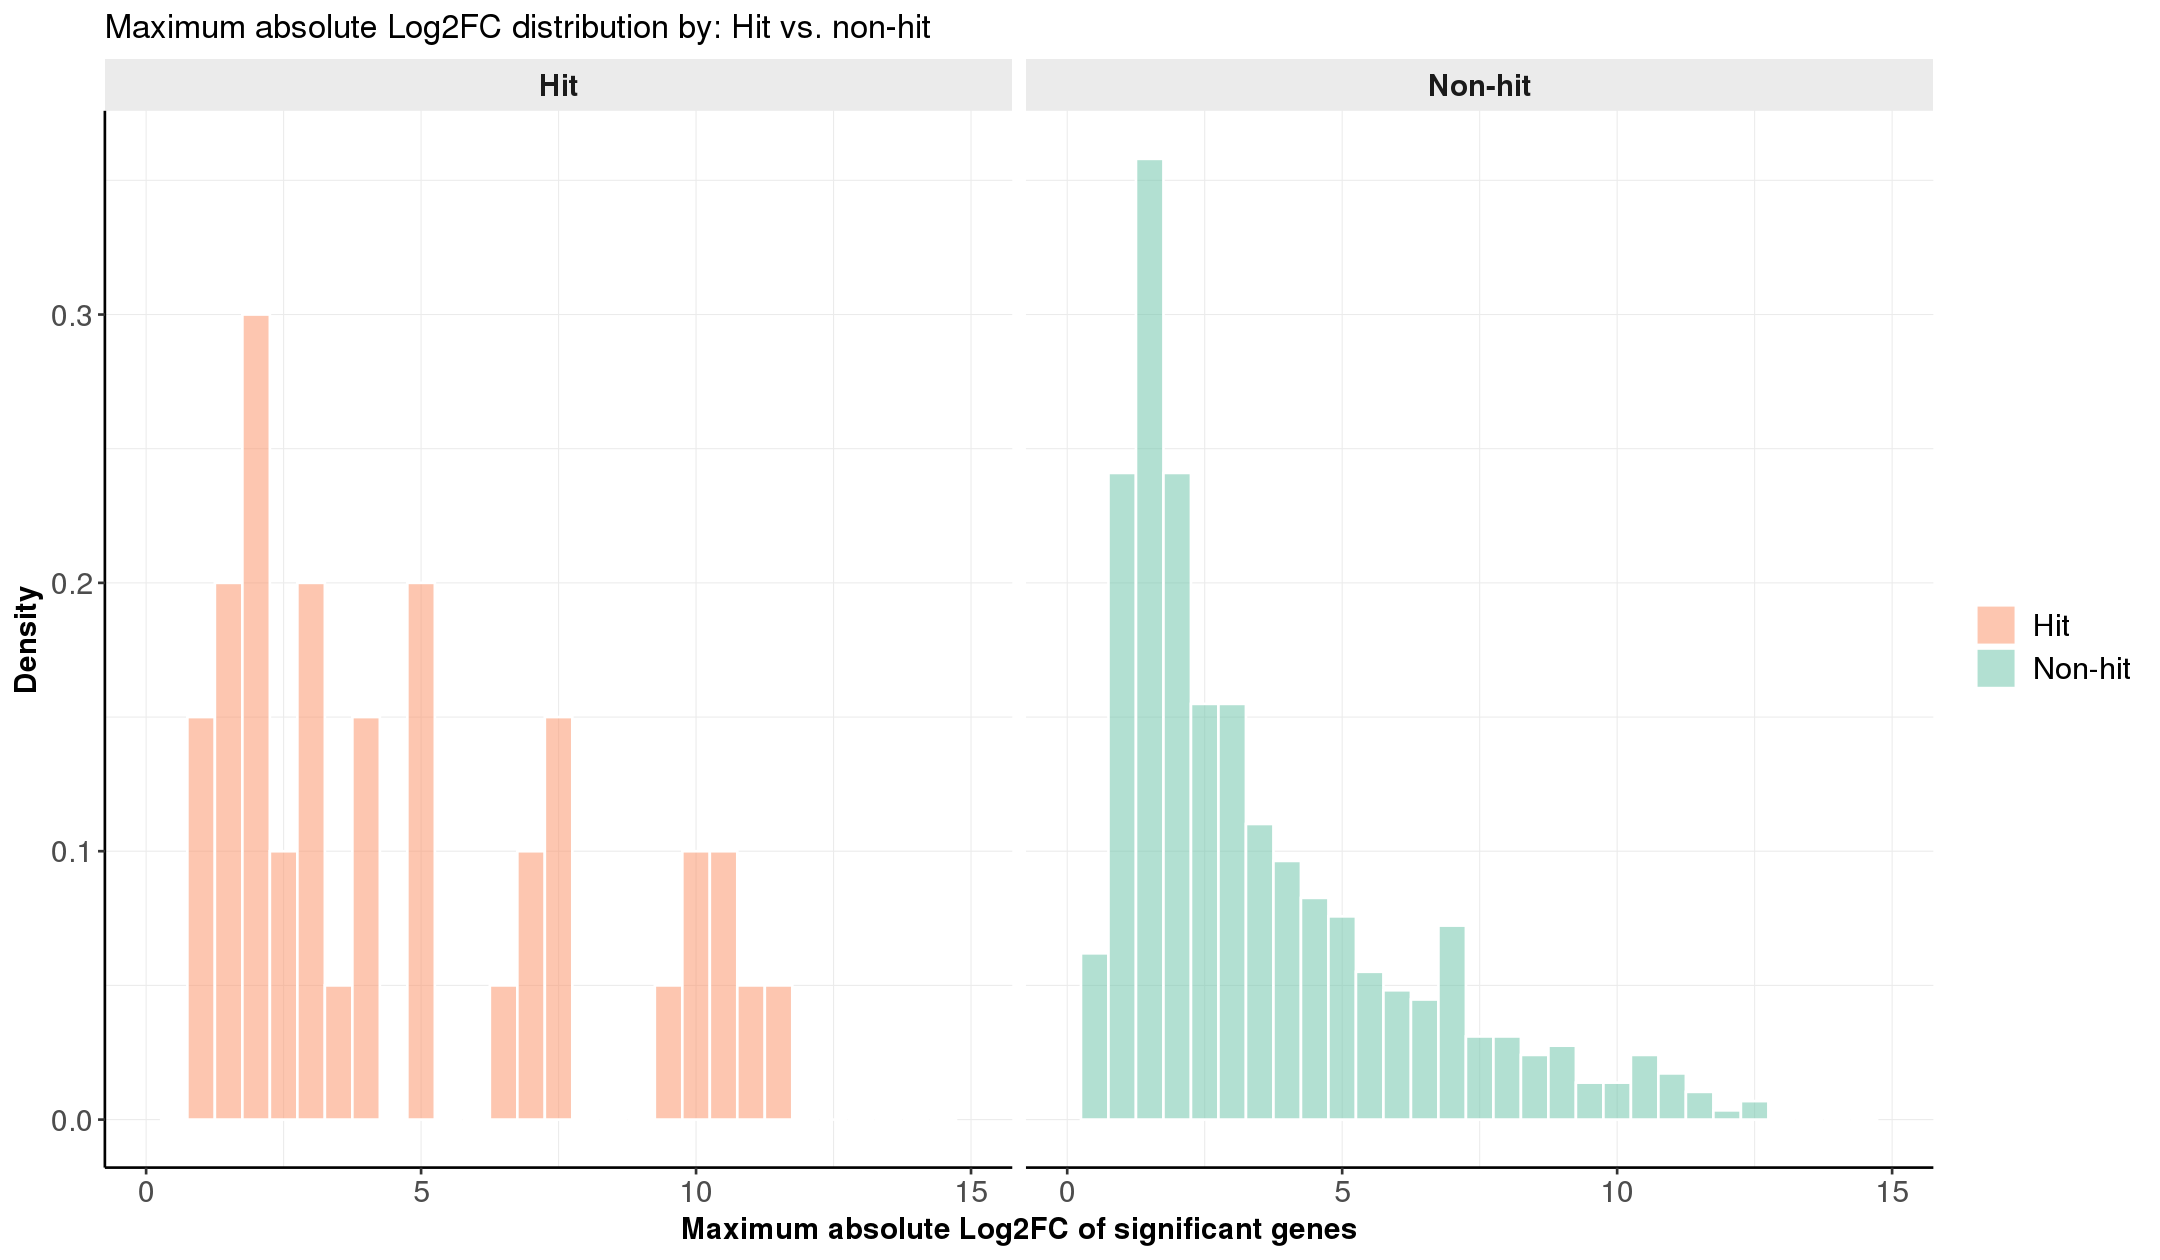

In [74]:
plot_df1 %>% filter(sigCounts > 1 & isTF == "TF") %>%
    ggplot() +
        geom_histogram(aes(x = max.abs.l2fc, y = ..density.., fill = isHIT), 
                       binwidth = .5, na.rm = T, alpha = .5, color = "white") +
        lims(x = c(0,15)) +
        my.theme +
        facet_grid( ~isHIT) +
        labs(title = "Maximum absolute Log2FC distribution by: Hit vs. non-hit",
             x = "Maximum absolute Log2FC of significant genes",
             y = "Density") +
        scale_fill_brewer(name = NULL, type = "qual", palette = "Set2", direction = -1)

### Heatmaps

In [153]:
c(seq(-10, -5, 5), seq(-3, 3, 1), seq(5, 10, 5))

[1] -10  -5  -3  -2  -1   0   1   2   3   5  10

In [159]:
breaksList <- c(seq(-12, -4, 3), seq(-3, 3, 1), seq(4, 12, 3))

In [132]:
filter(plot_df1, pattern == 31 & isHIT == "Hit")

gene_id,gene_name,H15,D1,D2,D4,D7,H15_vs_ES,D1_vs_ES,D2_vs_ES,D4_vs_ES,D7_vs_ES,sigCounts,pattern,max.abs.l2fc,isTF,isHIT,pattern2,rank
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<dbl>,<chr>,<chr>,<fct>,<int>
ENSG00000019549.13,SNAI2,7.7239589,6.617487,5.645859,5.3030251,5.2929020,TRUE,TRUE,TRUE,TRUE,TRUE,5,31,7.723959,TF,Hit,H15.D1.D2.D4.D7,1
ENSG00000028839.10,TBPL1,0.7512193,1.161518,1.463896,1.2202972,0.6623585,TRUE,TRUE,TRUE,TRUE,TRUE,5,31,1.463896,TF,Hit,H15.D1.D2.D4.D7,1
ENSG00000101412.13,E2F1,1.2084972,2.198265,2.192108,1.2818753,-1.2132720,TRUE,TRUE,TRUE,TRUE,TRUE,5,31,2.198265,TF,Hit,H15.D1.D2.D4.D7,1
ENSG00000157514.16,TSC22D3,1.7617409,1.087361,3.011077,3.5658963,3.5619767,TRUE,TRUE,TRUE,TRUE,TRUE,5,31,3.565896,TF,Hit,H15.D1.D2.D4.D7,1
ENSG00000159556.10,ISL2,4.9374712,6.608031,7.941280,9.9405699,9.6894419,TRUE,TRUE,TRUE,TRUE,TRUE,5,31,9.940570,TF,Hit,H15.D1.D2.D4.D7,1
ENSG00000164330.17,EBF1,2.5145465,5.049158,8.064695,9.7264083,10.6536900,TRUE,TRUE,TRUE,TRUE,TRUE,5,31,10.653690,TF,Hit,H15.D1.D2.D4.D7,1
ENSG00000167771.6,RCOR2,1.9771171,2.199487,2.444991,1.7224559,1.4322713,TRUE,TRUE,TRUE,TRUE,TRUE,5,31,2.444991,TF,Hit,H15.D1.D2.D4.D7,1
ENSG00000170802.16,FOXN2,1.5273694,1.293012,1.575904,0.9735236,1.1717927,TRUE,TRUE,TRUE,TRUE,TRUE,5,31,1.575904,TF,Hit,H15.D1.D2.D4.D7,1
ENSG00000173404.5,INSM1,9.4975972,9.466459,9.598266,9.1685219,9.3880612,TRUE,TRUE,TRUE,TRUE,TRUE,5,31,9.598266,TF,Hit,H15.D1.D2.D4.D7,1


In [102]:
head(plot_df1)

gene_id,gene_name,H15,D1,D2,D4,D7,H15_vs_ES,D1_vs_ES,D2_vs_ES,D4_vs_ES,D7_vs_ES,sigCounts,pattern,max.abs.l2fc,isTF,isHIT,pattern2,rank
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<dbl>,<chr>,<chr>,<fct>,<int>
ENSG00000000003.14,TSPAN6,0.4627771,0.3900457,0.44617805,-0.2887279,-1.2998652,FALSE,FALSE,FALSE,FALSE,TRUE,1,16,1.299865,Non-TF,Non-hit,D7,1
ENSG00000000005.6,TNMD,-0.3569464,-2.0927229,-5.28160385,-4.8403918,-5.4619627,FALSE,FALSE,FALSE,FALSE,TRUE,1,16,5.461963,Non-TF,Non-hit,D7,1
ENSG00000000419.12,DPM1,-0.3726923,-0.1751776,-0.04997689,-0.3424355,-0.4335166,FALSE,FALSE,FALSE,FALSE,FALSE,0,0,0.000000,Non-TF,Non-hit,NA,1
ENSG00000000457.14,SCYL3,-0.5357799,0.7868351,0.61865521,1.0405193,0.9733724,FALSE,FALSE,FALSE,FALSE,FALSE,0,0,0.000000,Non-TF,Non-hit,NA,1
ENSG00000000460.17,C1orf112,0.5850347,-0.1684901,-0.63501390,-2.5606942,-3.0439906,FALSE,FALSE,FALSE,TRUE,TRUE,2,24,3.043991,Non-TF,Non-hit,D4.D7,1
ENSG00000000938.13,FGR,1.9566390,3.4345270,1.21960062,0.0000000,0.0000000,FALSE,FALSE,FALSE,FALSE,FALSE,0,0,0.000000,Non-TF,Non-hit,NA,1


In [128]:
df1 <- filter(plot_df1, sigCounts > 1 & max.abs.l2fc > 5 & pattern == 31)

In [129]:
df1.an <- select(df1, gene_name, isTF, isHIT, pattern2) %>% column_to_rownames("gene_name")

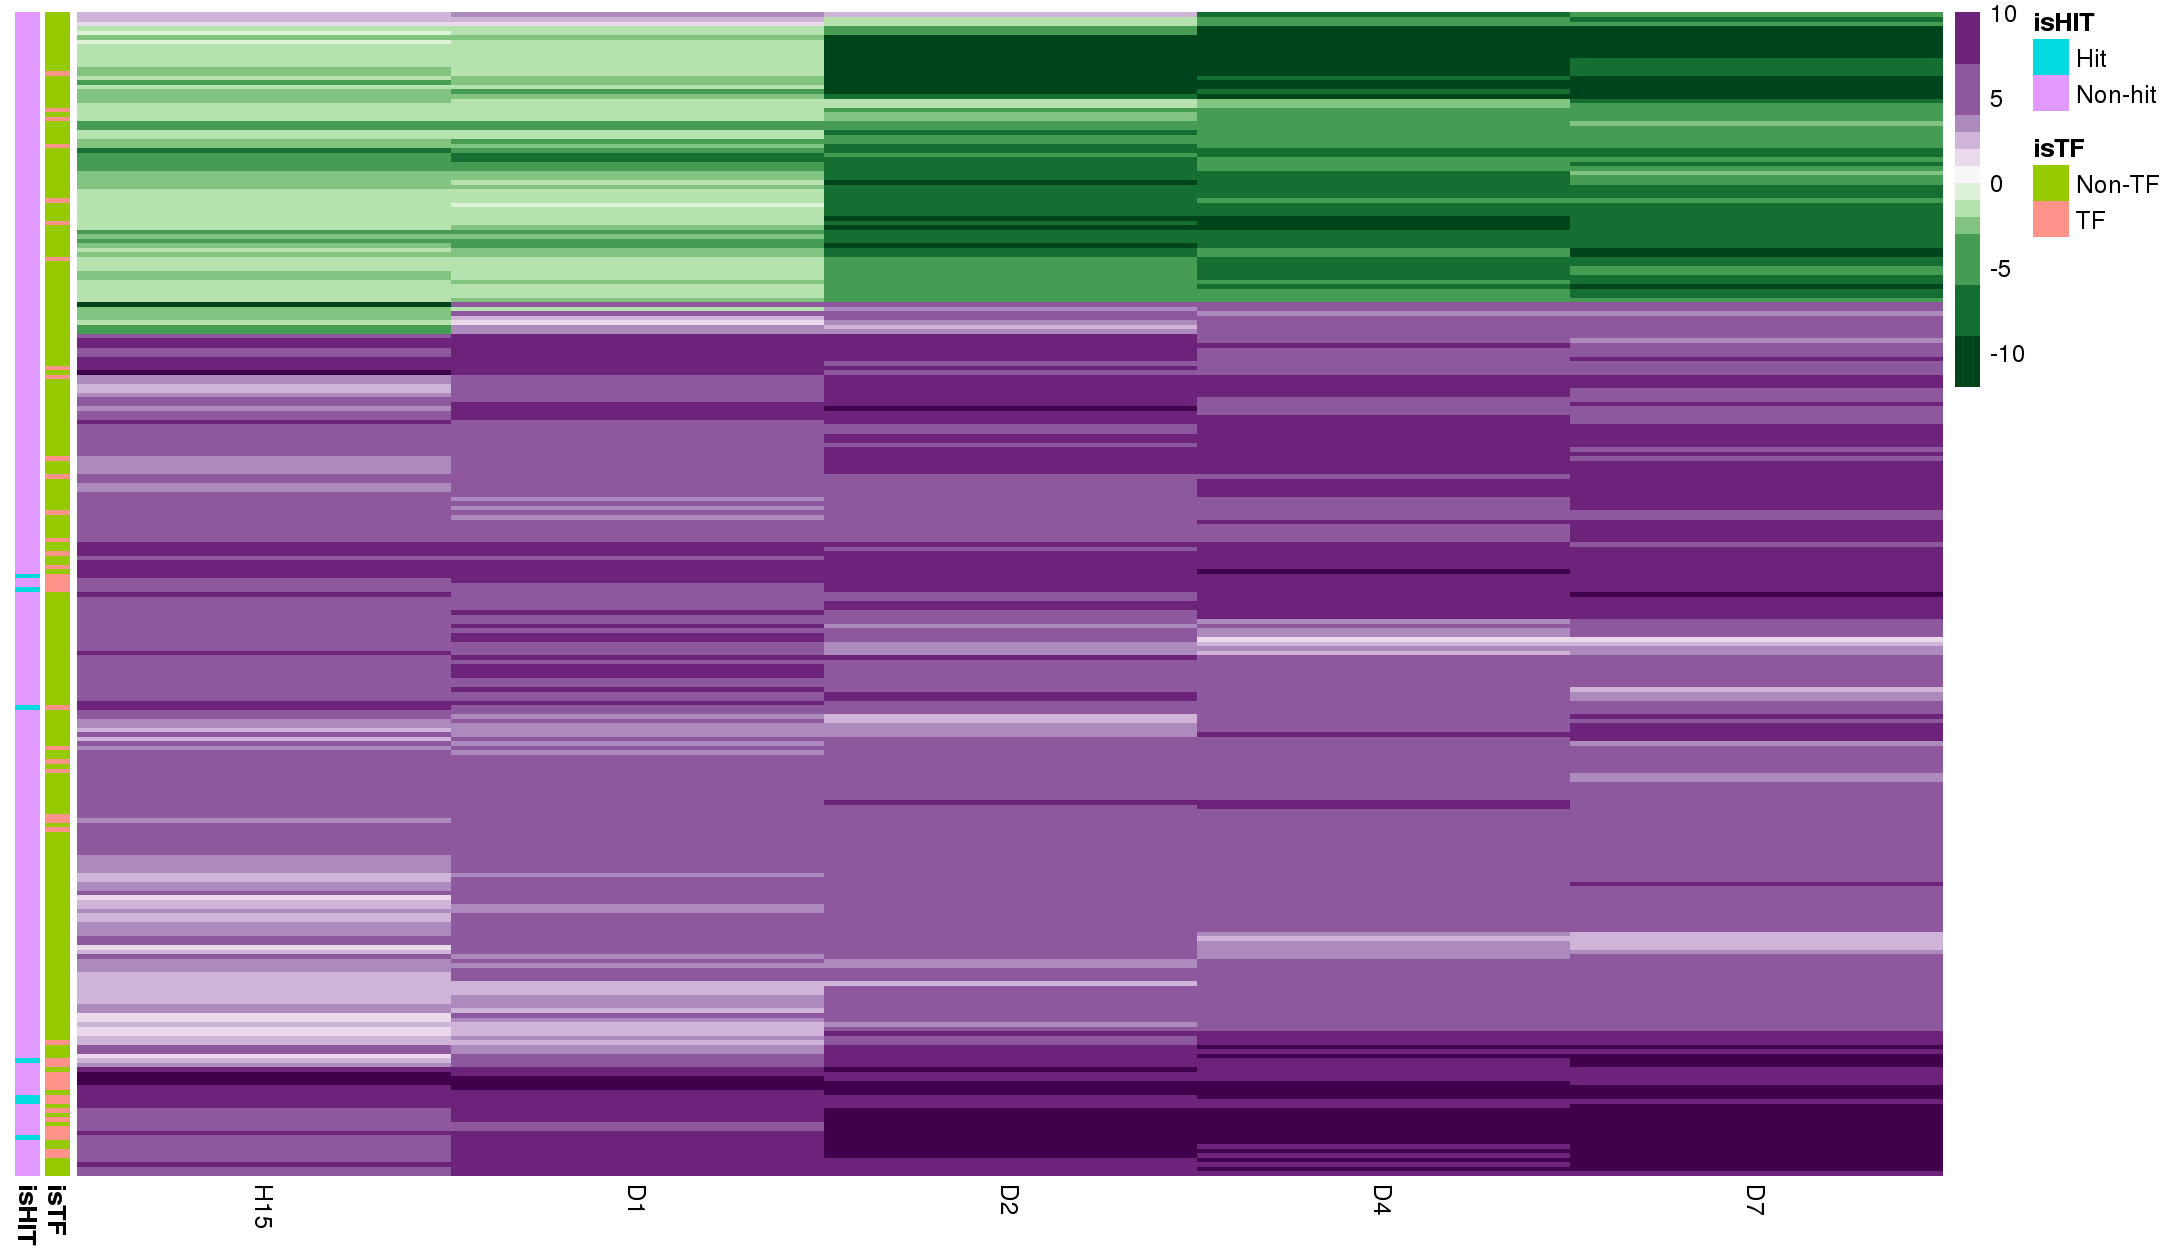

In [160]:
select(df1, gene_name, H15:D7) %>% 
                    column_to_rownames("gene_name") %>%
                    pheatmap(cluster_rows = T, show_rownames = F, cluster_cols = F, show_colnames = T,
                             treeheight_row = 0, clustering_distance_rows = "euclidean", 
                             colorRampPalette(rev(brewer.pal(n = 11, name = "PRGn")))(length(breaksList)), 
                             breaks = breaksList, annotation_row = df1.an[,1:2]
                             )

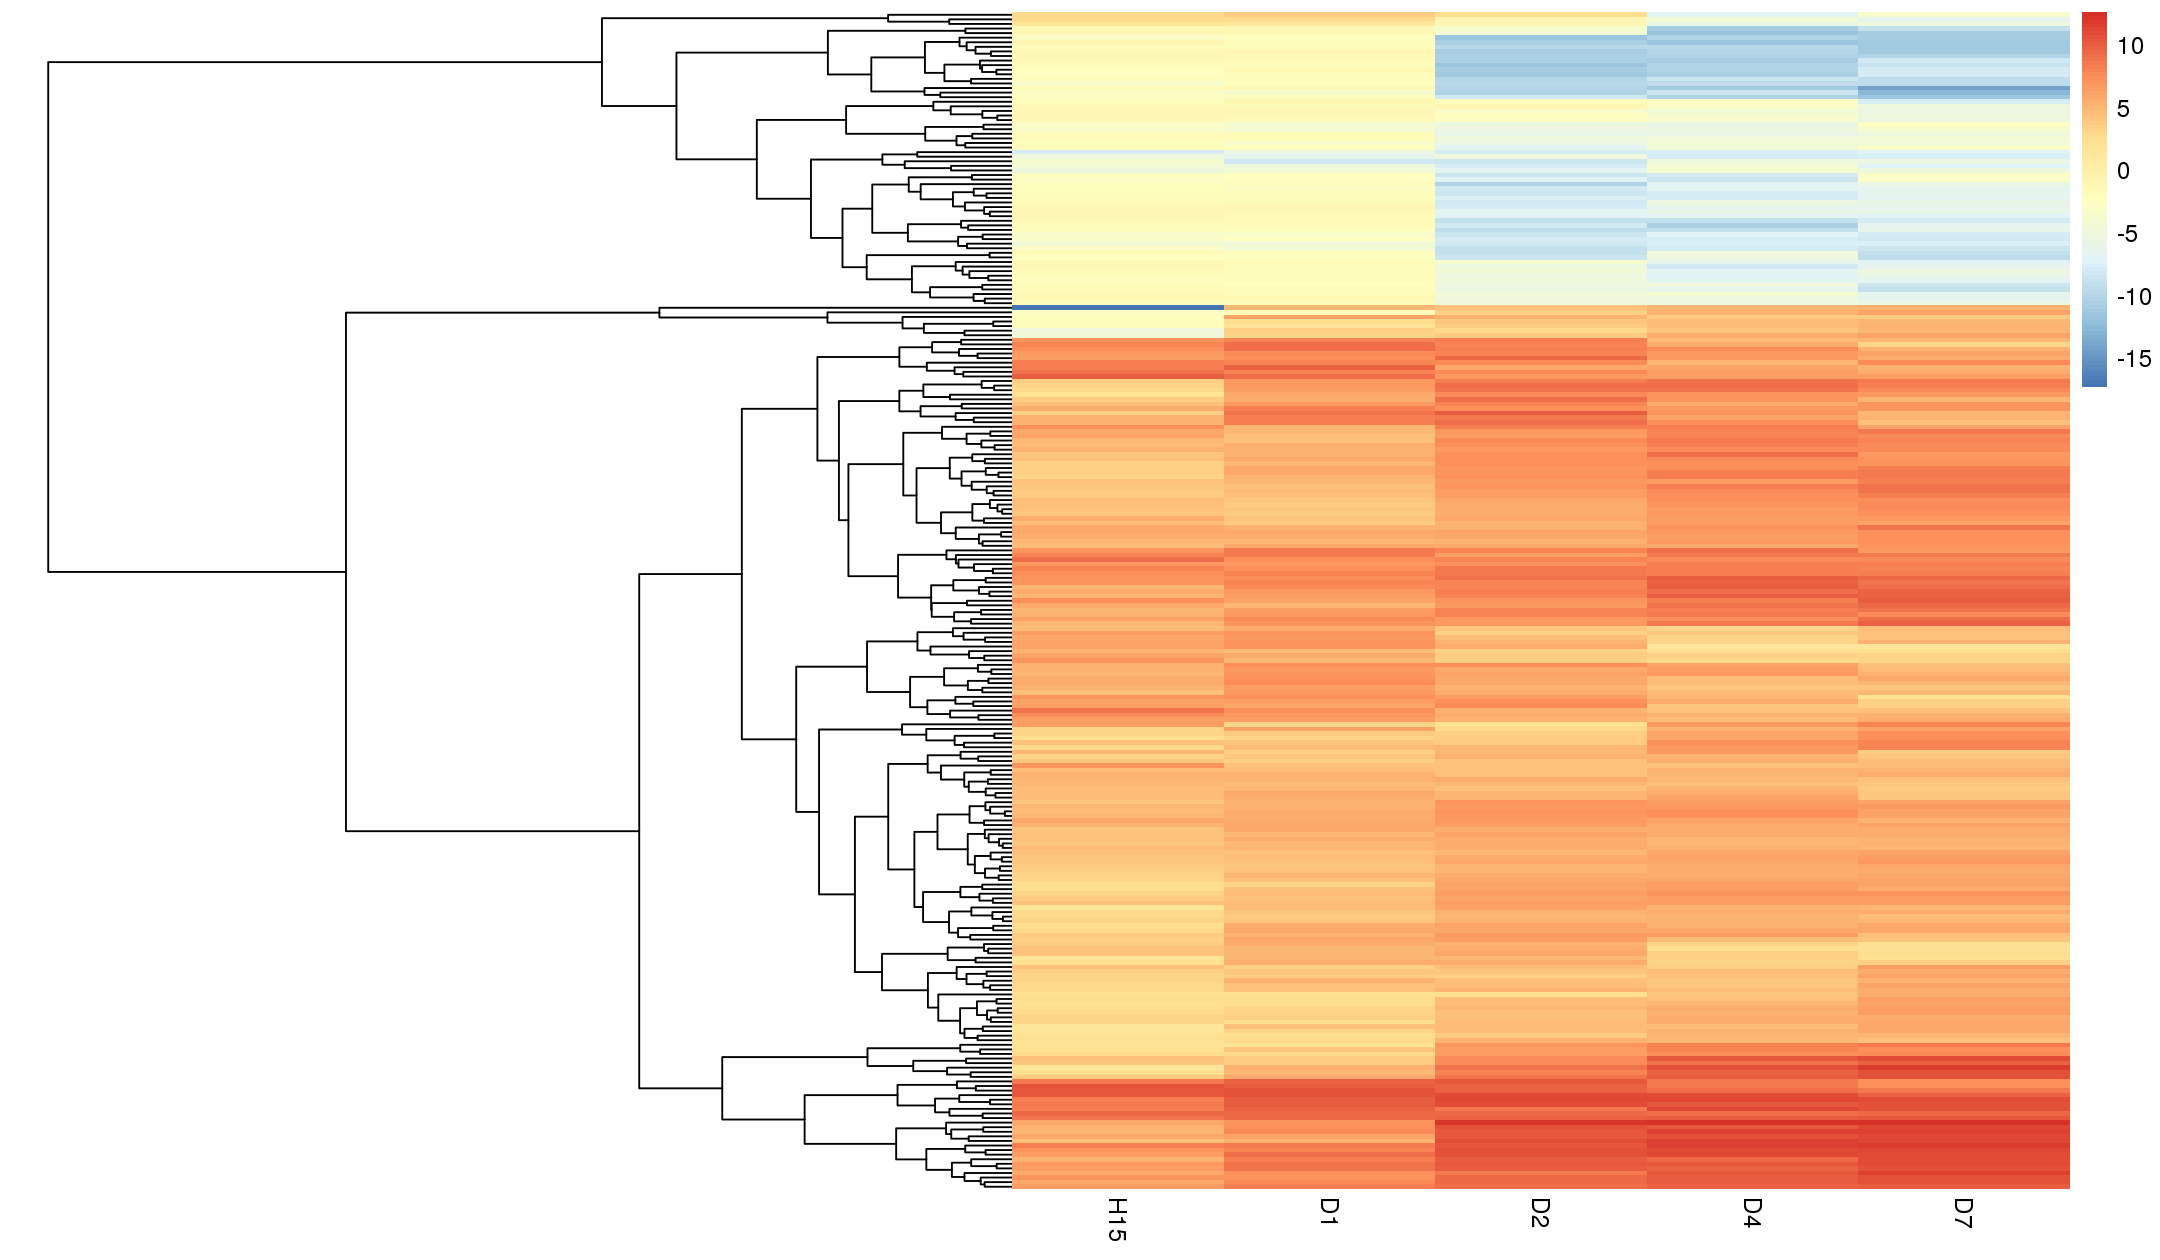

In [161]:
initial_map1 <- select(df1, gene_name, H15:D7) %>% 
                    column_to_rownames("gene_name") %>%
                    pheatmap(cluster_rows = T, show_rownames = F, cluster_cols = F, show_colnames = T,
                         treeheight_row = 400, clustering_distance_rows = "euclidean")

### Plot heatmap by GO groups

### Plot heatmap by cluster

In [438]:
breaksList <- seq(-10,10,1)

In [680]:
# cut tree into 12 clusters
clusters1 <- cutree(initial_map$tree_row, k = 30)

In [683]:
# make sure the dataframe gene names and cluster has the same order
all((filter(heatmap_df, sigCounts > 1 & mean.abs.l2fc > 1) %>% pull(gene_name)) == names(clusters1))
all((filter(heatmap_df, sigCounts > 1 & mean.abs.l2fc > 1) %>% pull(gene_name)) == names(clusters2))

[1] TRUE

[1] TRUE

In [684]:
df1 %>% head

gene_id,gene_name,H15,D1,D2,D4,D7,H15_vs_ES,D1_vs_ES,D2_vs_ES,D4_vs_ES,D7_vs_ES,sigCounts,pattern,mean.abs.l2fc,isTF,isHIT,rank
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<int>
ENSG00000000460.17,C1orf112,0.5850347,-0.1684901,-0.6350139,-2.5606942,-3.0439906,FALSE,FALSE,FALSE,TRUE,TRUE,2,24,2.802342,FALSE,FALSE,1
ENSG00000001461.17,NIPAL3,0.7798943,1.7114340,1.3023046,0.6141820,0.7415282,FALSE,TRUE,TRUE,FALSE,FALSE,2,6,1.506869,FALSE,FALSE,1
ENSG00000001617.12,SEMA3F,-1.8348933,-0.7635346,-6.3123599,-3.9732193,-1.6982634,FALSE,FALSE,TRUE,TRUE,TRUE,3,28,3.994614,FALSE,FALSE,1
ENSG00000001630.17,CYP51A1,1.7327958,1.2488794,0.4263824,0.5360152,1.6020563,TRUE,TRUE,FALSE,FALSE,TRUE,3,19,1.527910,FALSE,FALSE,1
ENSG00000002586.20,CD99,1.2853105,0.9205293,1.1420945,0.9041245,-0.6101863,TRUE,TRUE,TRUE,TRUE,FALSE,4,15,1.063015,FALSE,FALSE,1
ENSG00000002587.10,HS3ST1,-0.1704085,0.8428847,-0.6788173,2.6757314,3.7827695,FALSE,FALSE,FALSE,TRUE,TRUE,2,24,3.229250,FALSE,FALSE,1


In [698]:
dim(df1)
length(clusters1)

[1] 5774   18

[1] 5774

# todos
- replace mean.abs.l2fc to max.abs.l2fc
- try with different max.abs.l2fc cutoffs, and plot distribution of ( number of genes remain vs. cutoff values)
- also % of TFs remain
- cluster 11

### Use `Euclidean` method to cluster

In [708]:
df1 <- add_column(df1, cluster = clusters1)

In [709]:
df1 %>% head

gene_id,gene_name,H15,D1,D2,D4,D7,H15_vs_ES,D1_vs_ES,D2_vs_ES,D4_vs_ES,D7_vs_ES,sigCounts,pattern,mean.abs.l2fc,isTF,isHIT,rank,cluster
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<int>
ENSG00000000460.17,C1orf112,0.5850347,-0.1684901,-0.6350139,-2.5606942,-3.0439906,FALSE,FALSE,FALSE,TRUE,TRUE,2,24,2.802342,FALSE,FALSE,1,1
ENSG00000001461.17,NIPAL3,0.7798943,1.7114340,1.3023046,0.6141820,0.7415282,FALSE,TRUE,TRUE,FALSE,FALSE,2,6,1.506869,FALSE,FALSE,1,2
ENSG00000001617.12,SEMA3F,-1.8348933,-0.7635346,-6.3123599,-3.9732193,-1.6982634,FALSE,FALSE,TRUE,TRUE,TRUE,3,28,3.994614,FALSE,FALSE,1,3
ENSG00000001630.17,CYP51A1,1.7327958,1.2488794,0.4263824,0.5360152,1.6020563,TRUE,TRUE,FALSE,FALSE,TRUE,3,19,1.527910,FALSE,FALSE,1,2
ENSG00000002586.20,CD99,1.2853105,0.9205293,1.1420945,0.9041245,-0.6101863,TRUE,TRUE,TRUE,TRUE,FALSE,4,15,1.063015,FALSE,FALSE,1,2
ENSG00000002587.10,HS3ST1,-0.1704085,0.8428847,-0.6788173,2.6757314,3.7827695,FALSE,FALSE,FALSE,TRUE,TRUE,2,24,3.229250,FALSE,FALSE,1,4


In [738]:
# create a list of matrix for pheatmap
clusters1.mx <- map(1:10, ~ filter(df1, cluster == .x) %>% select(gene_name:D7) %>% column_to_rownames("gene_name"))
# add cluster 12
clusters1.mx <- c(clusters1.mx, list(filter(df1, cluster == 12) %>% select(gene_name:D7) %>% column_to_rownames("gene_name")))
# add clusters 11, 13:30
clusters1.mx <- c(clusters1.mx, list(filter(df1, cluster %in% c(11,13:30)) %>% select(gene_name:D7) %>% column_to_rownames("gene_name")))

In [820]:
# similarly create the corresponding annotations for each cluster
clusters1.an <- map(1:10, ~ filter(df1, cluster == .x) %>% select(gene_name, isTF, isHIT) %>% mutate_at(c("isTF", "isHIT"), as.integer) %>% column_to_rownames("gene_name"))

In [822]:
clusters1.an <- c(clusters1.an, list(filter(df1, cluster == 12) %>% select(gene_name, isTF, isHIT) %>% mutate_at(c("isTF", "isHIT"), as.integer) %>% column_to_rownames("gene_name")))
clusters1.an <- c(clusters1.an, list(filter(df1, cluster %in% c(11, 13:30)) %>% select(gene_name, isTF, isHIT) %>% mutate_at(c("isTF", "isHIT"), as.integer) %>% column_to_rownames("gene_name")))

In [823]:
cluster1.tf.ratio <- map_int(clusters1.an, ~ filter(.x, isTF == 1) %>% nrow) / map_int(clusters1.an, ~ nrow(.x))

In [824]:
cluster1.hit.ratio <- map_int(clusters1.an, ~ filter(.x, isHIT == 1) %>% nrow) / map_int(clusters1.an, ~ nrow(.x))

In [825]:
cluster1.names <- factor(paste0(rep("C", 12), 1:12), levels = paste0(rep("C", 12), 1:12) )

In [826]:
cluster1.stats <- data.frame("cluster"=cluster1.names, "tf.ratio" = cluster1.tf.ratio, "hit.ratio" = cluster1.hit.ratio)

In [887]:
g1 <- cluster1.stats %>% pivot_longer(cols = c("tf.ratio", "hit.ratio"), names_to = "ratio.type", values_to = "ratio") %>%
ggplot() + geom_bar(aes(x=cluster, y=ratio, fill=ratio.type), stat = "identity", position = "dodge") +
            theme_classic() + 
            theme(axis.text=element_text(size=16), axis.title=element_text(size=16,face="bold"),
                  legend.text=element_text(size=16),legend.title=element_text(size=16), strip.text = element_text(size = 16)) + 
            xlab("Cluster") + ylab("Proportion")

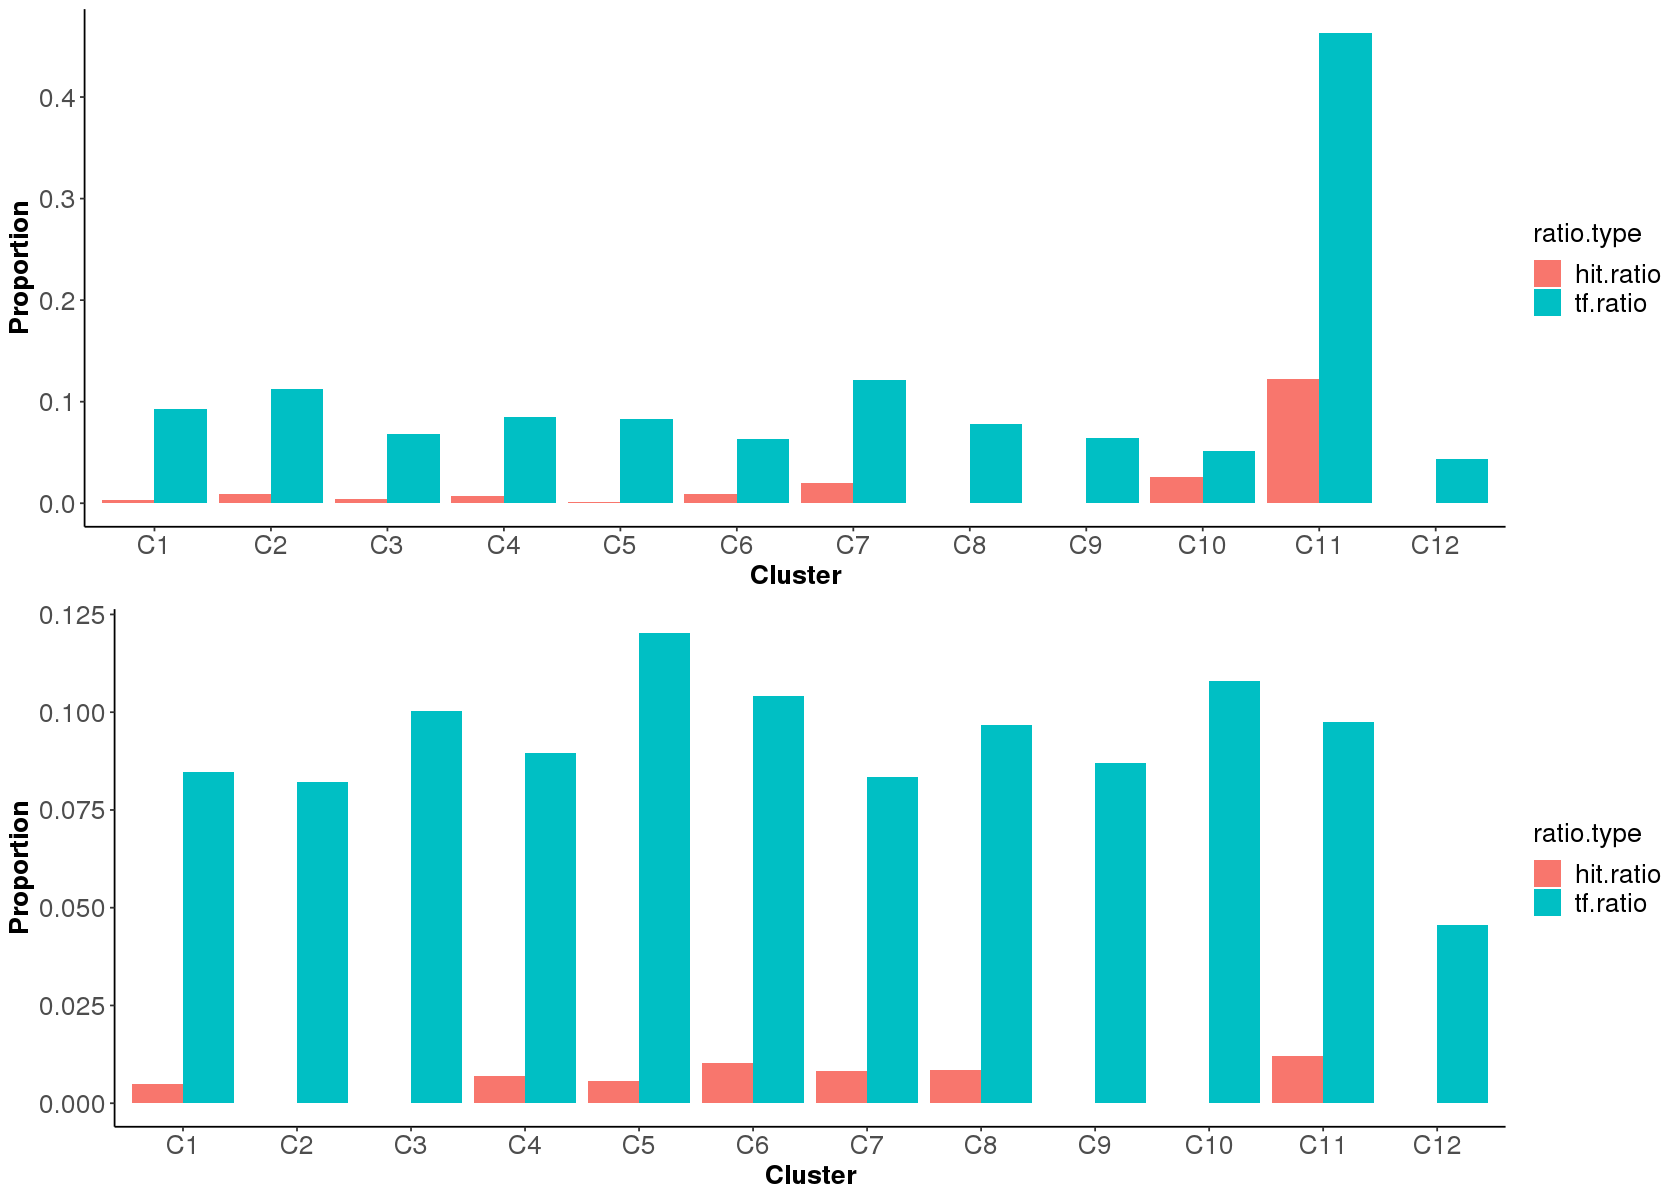

In [890]:
gridExtra::grid.arrange(g1, g2, nrow = 2)

In [878]:
my.pheatmap <- function(mx, an) {
    show.rows = F
    if (nrow(an) > 1000) {
        cell.height = NA 
    } else if (nrow(an) > 60 ) {
        cell.height = 1
    } else {
        cell.height = 10
        show.rows = T
        
    }
    
    pheatmap(mx, cluster_rows = T, show_rownames = show.rows, cluster_cols = F, show_colnames = T,treeheight_row = 0,
        cellheight = cell.height, cellwidth = 100, fontsize=9, fontsize_col = 12, angle_col = 0, annotation_row = an, 
        colorRampPalette(rev(brewer.pal(n = 7, name = "PRGn")))(length(breaksList)), breaks = breaksList,
        main = "TF gene expression change over ES")
}

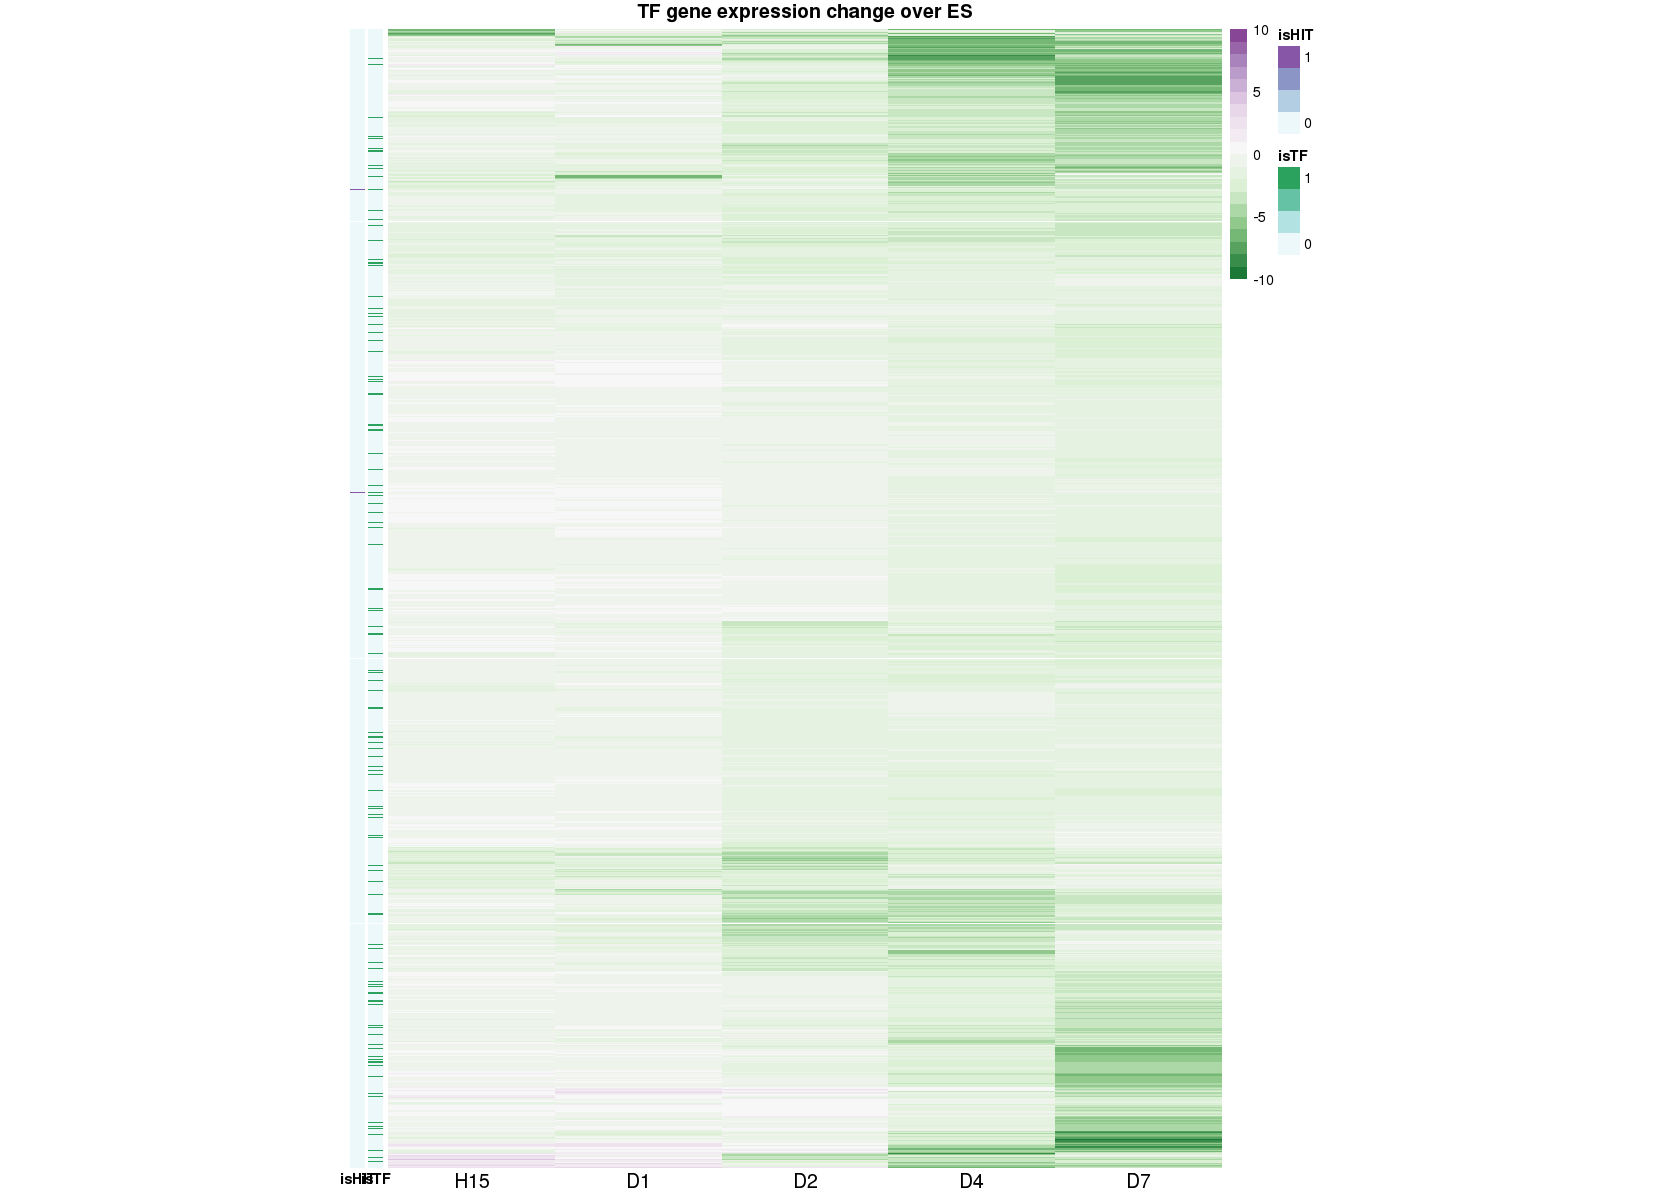

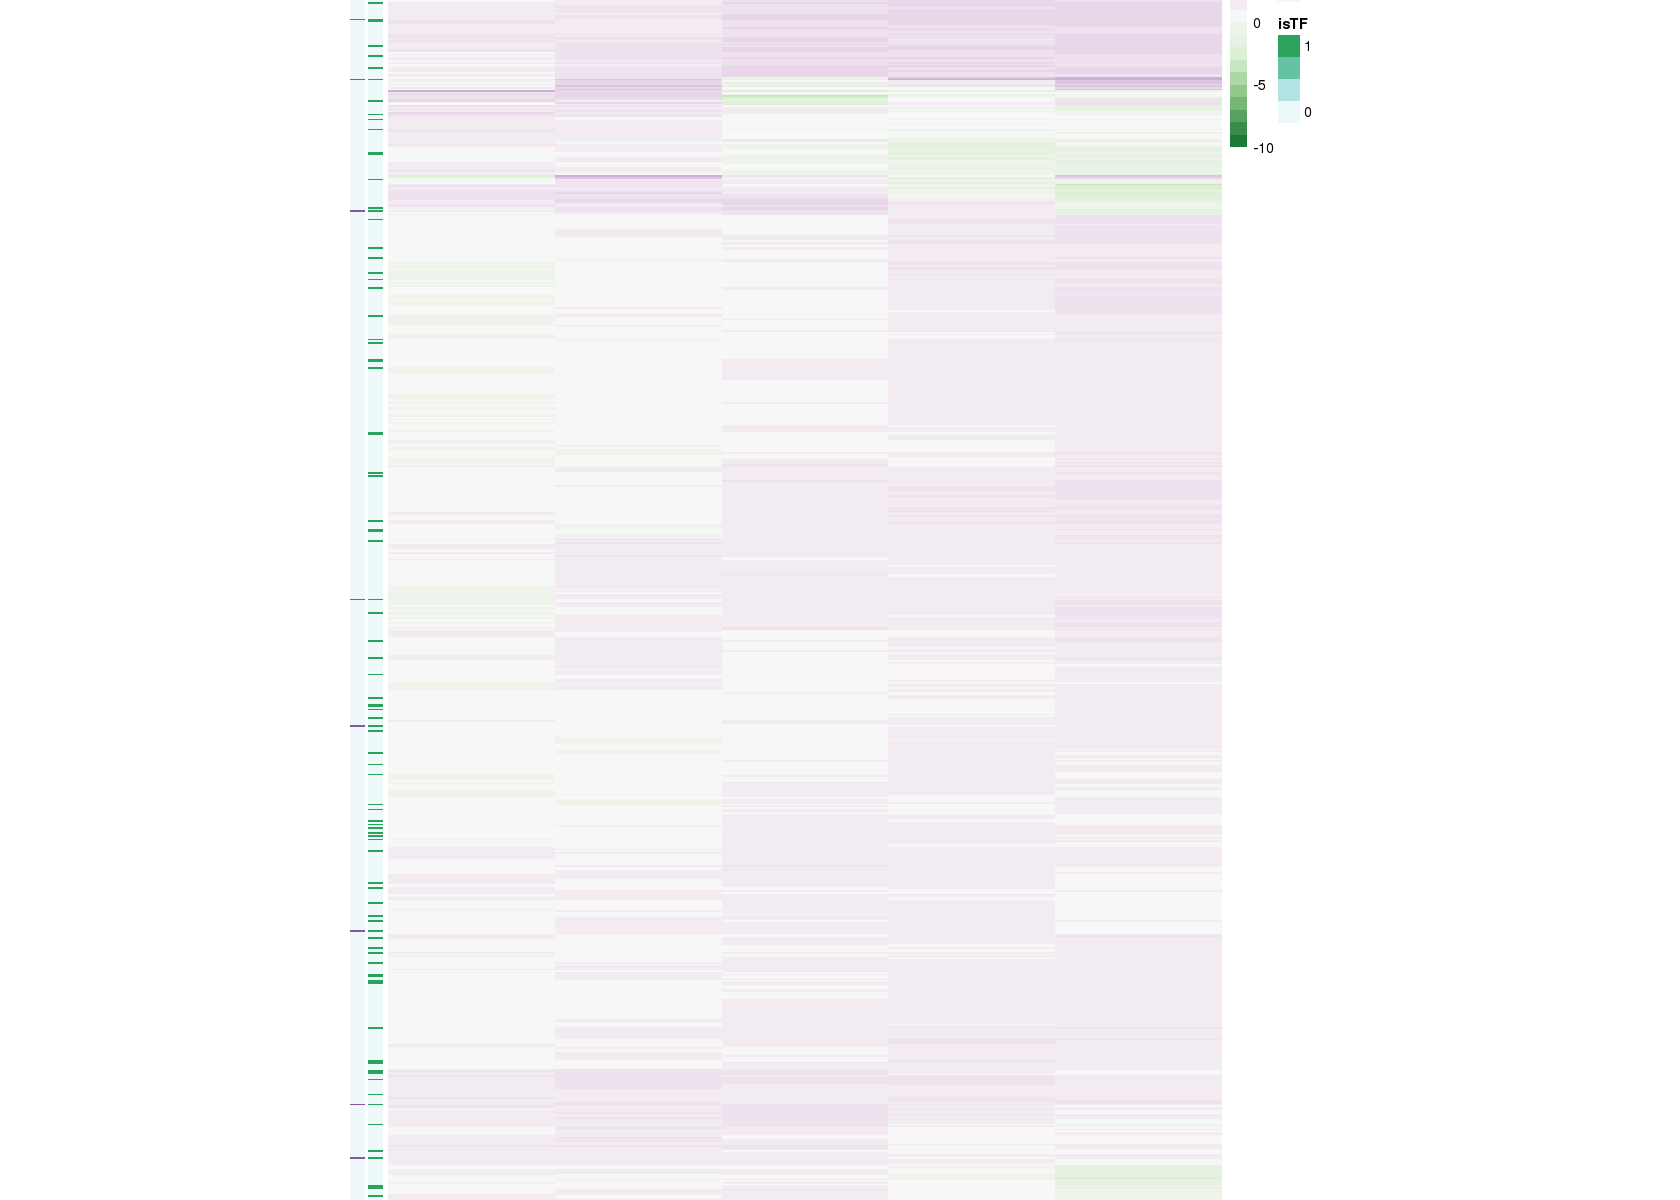

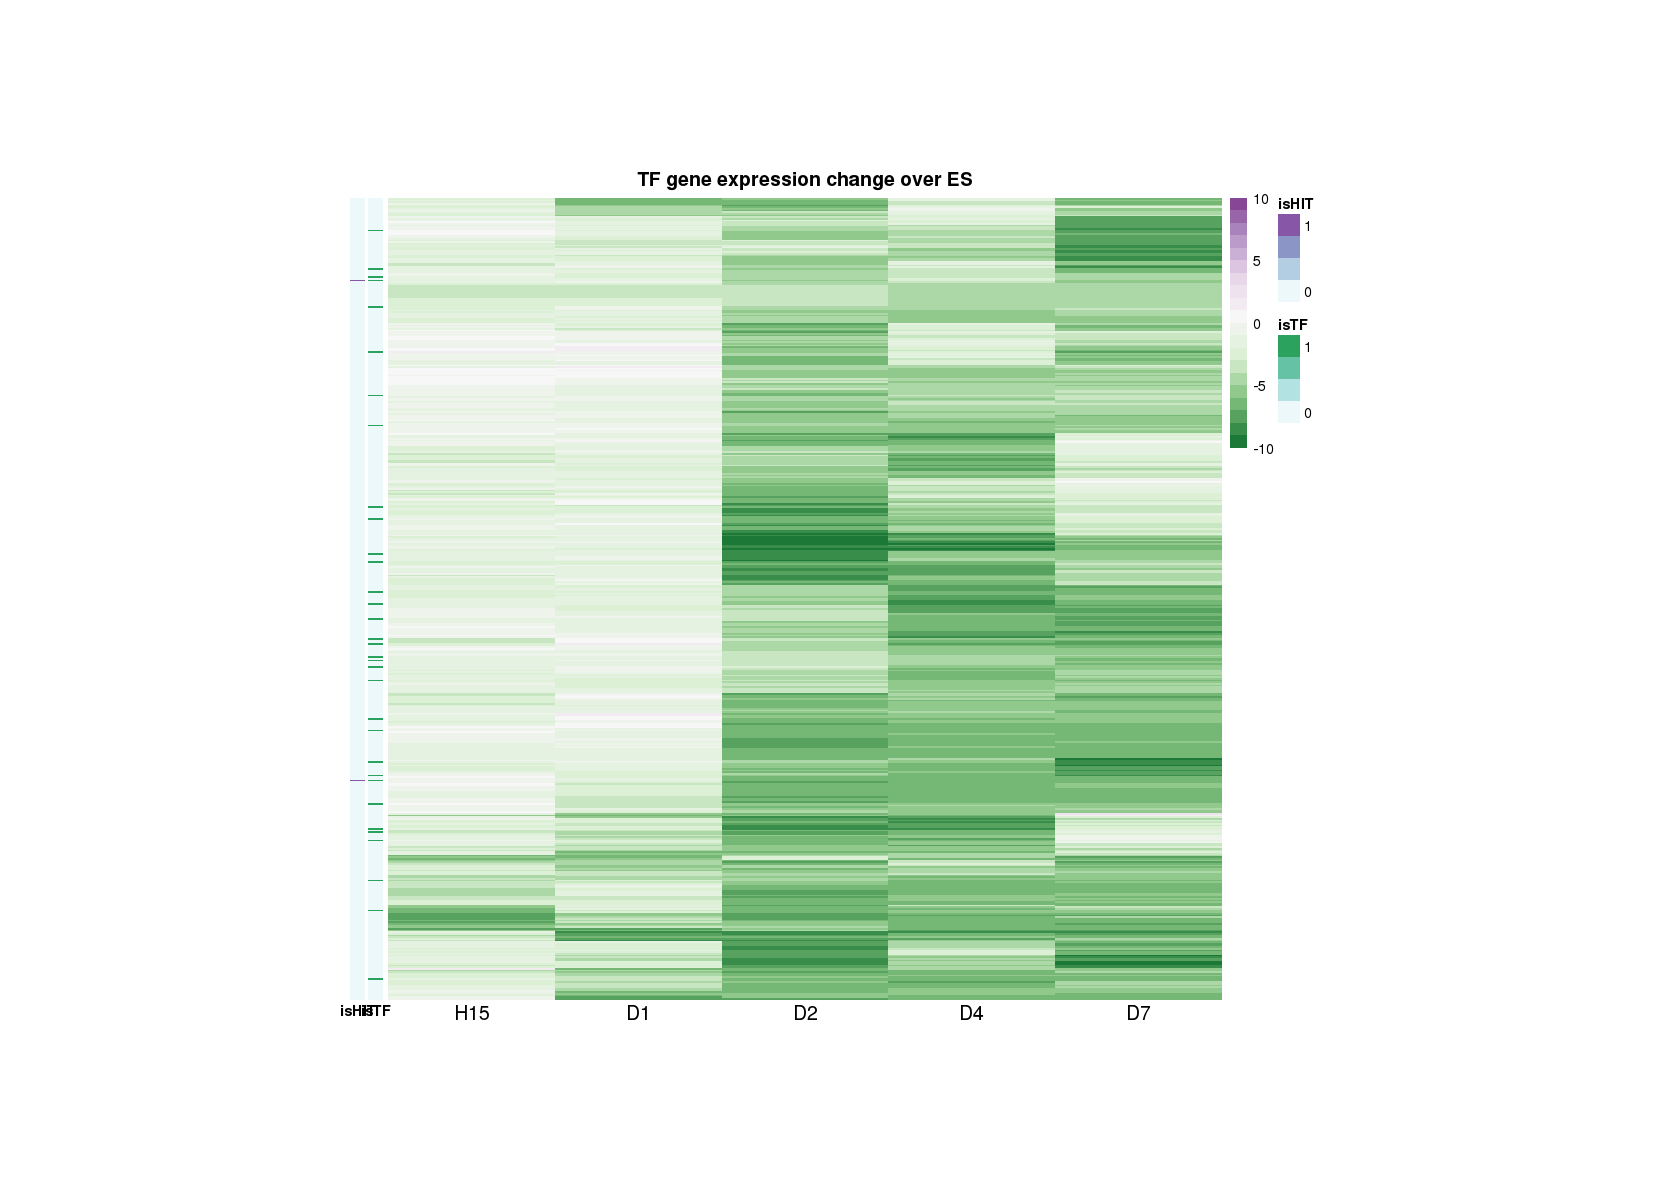

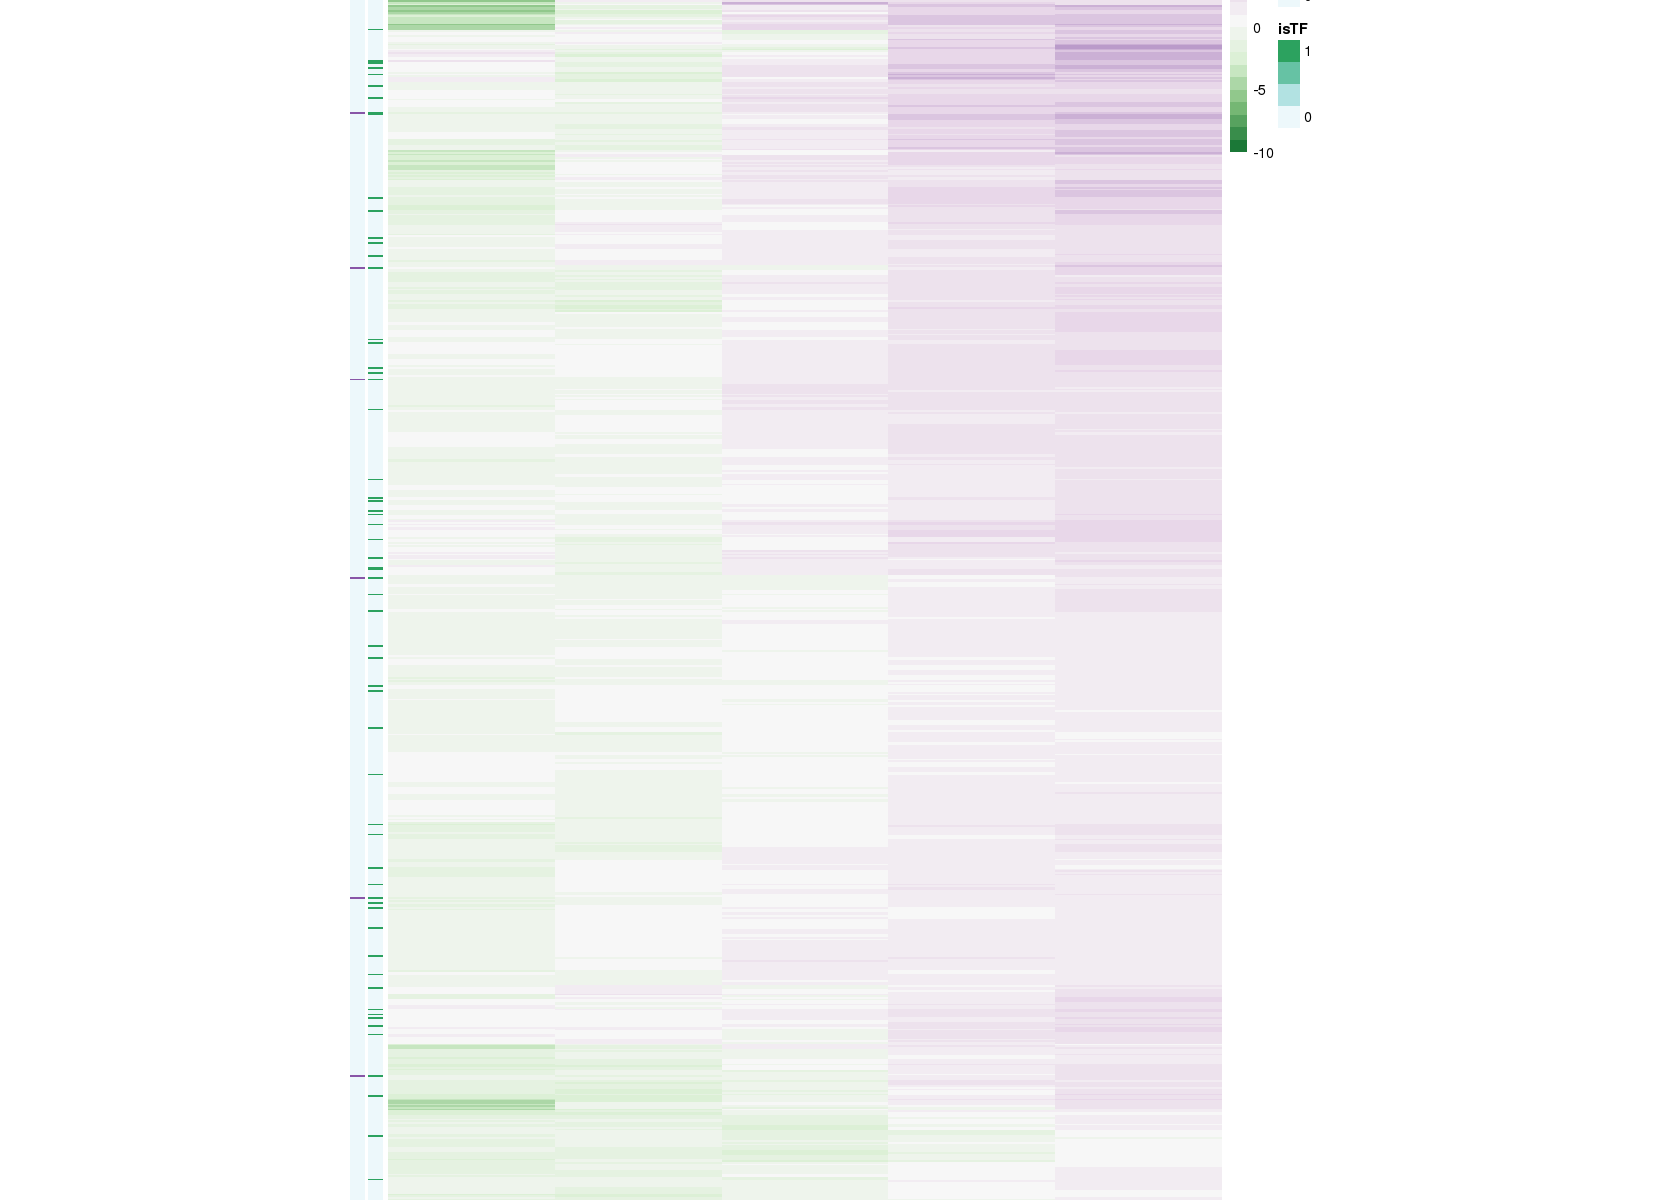

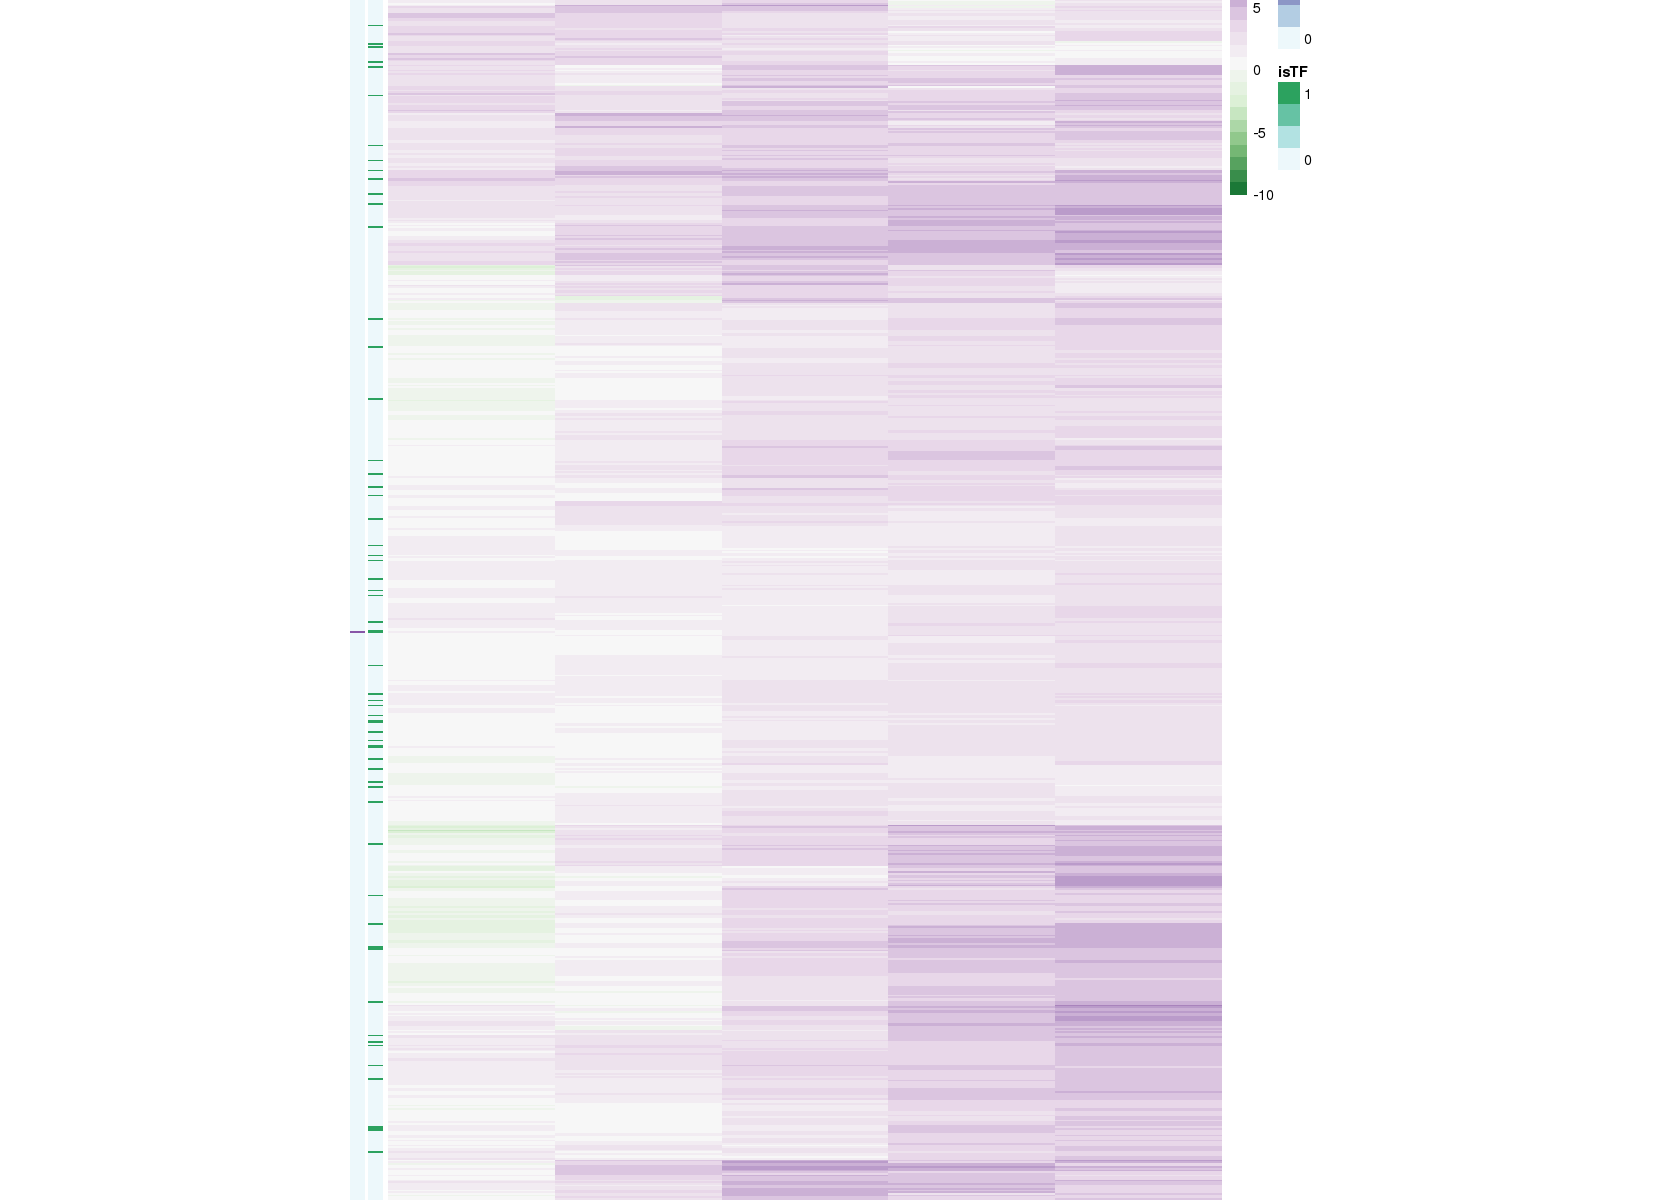

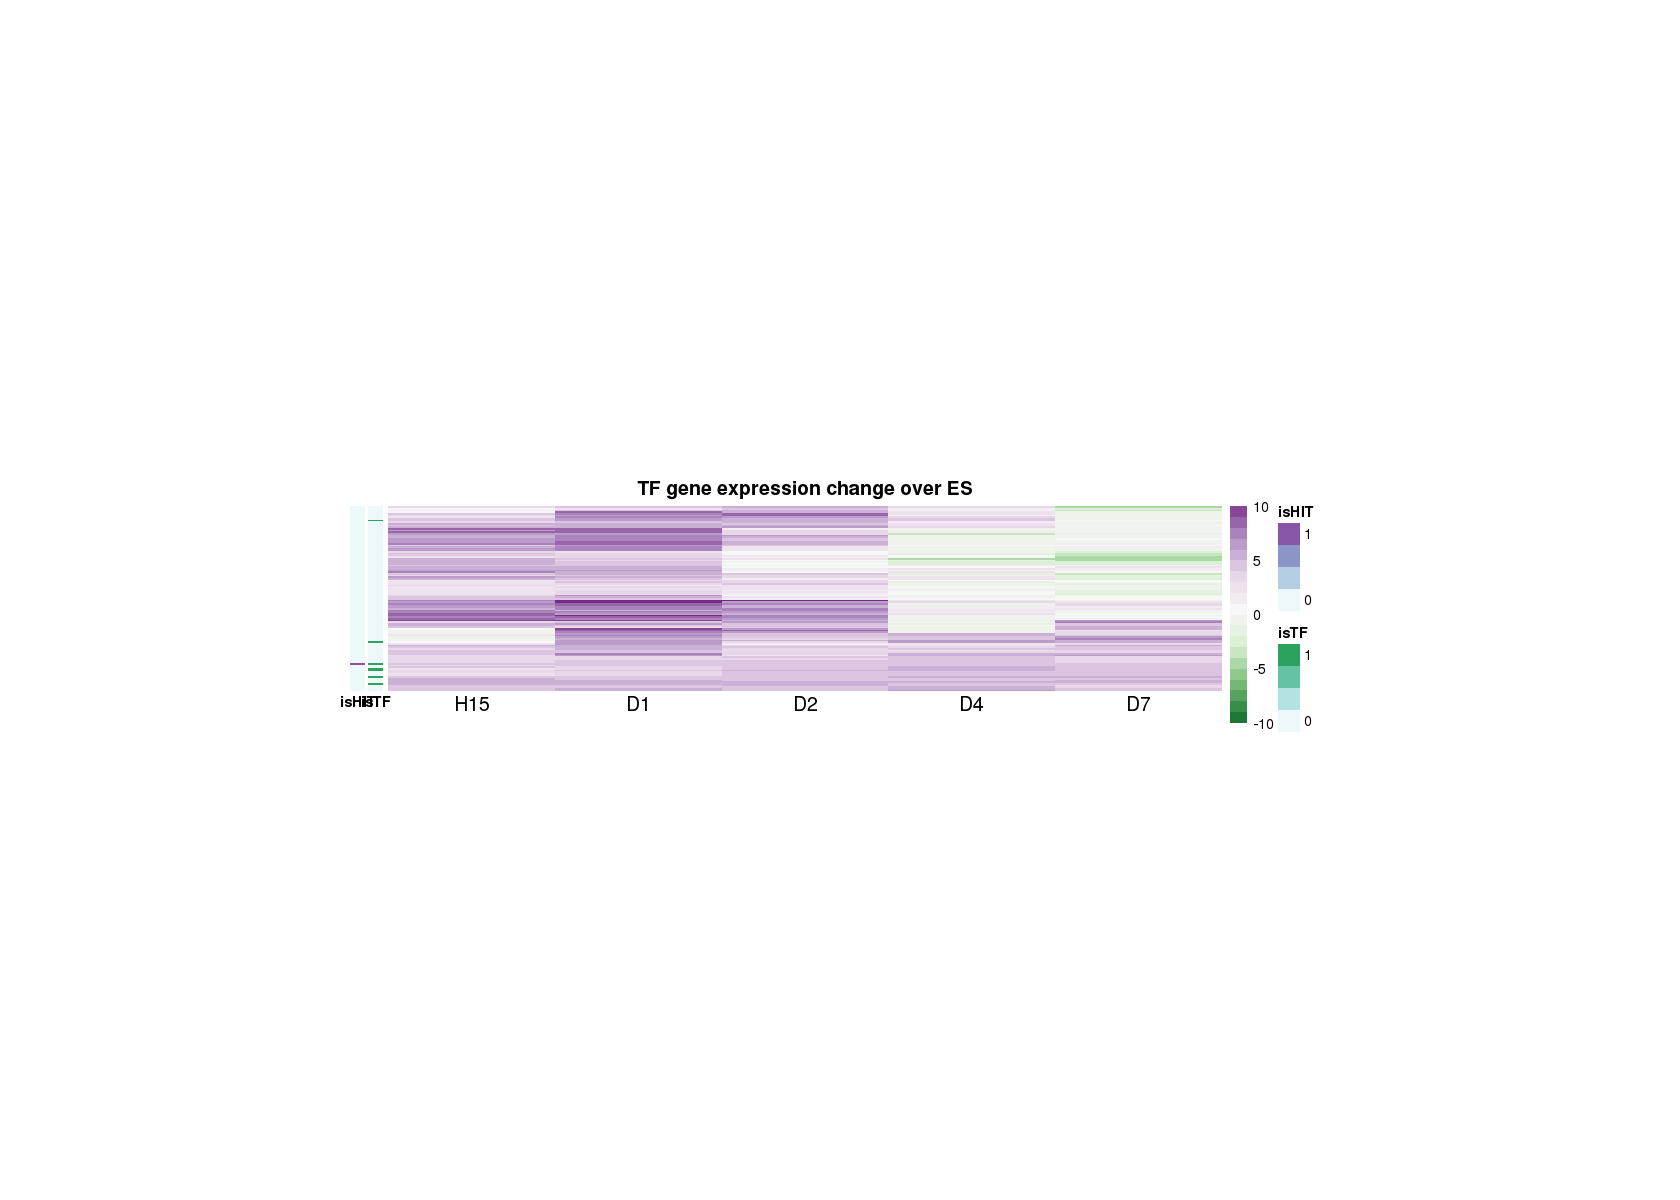

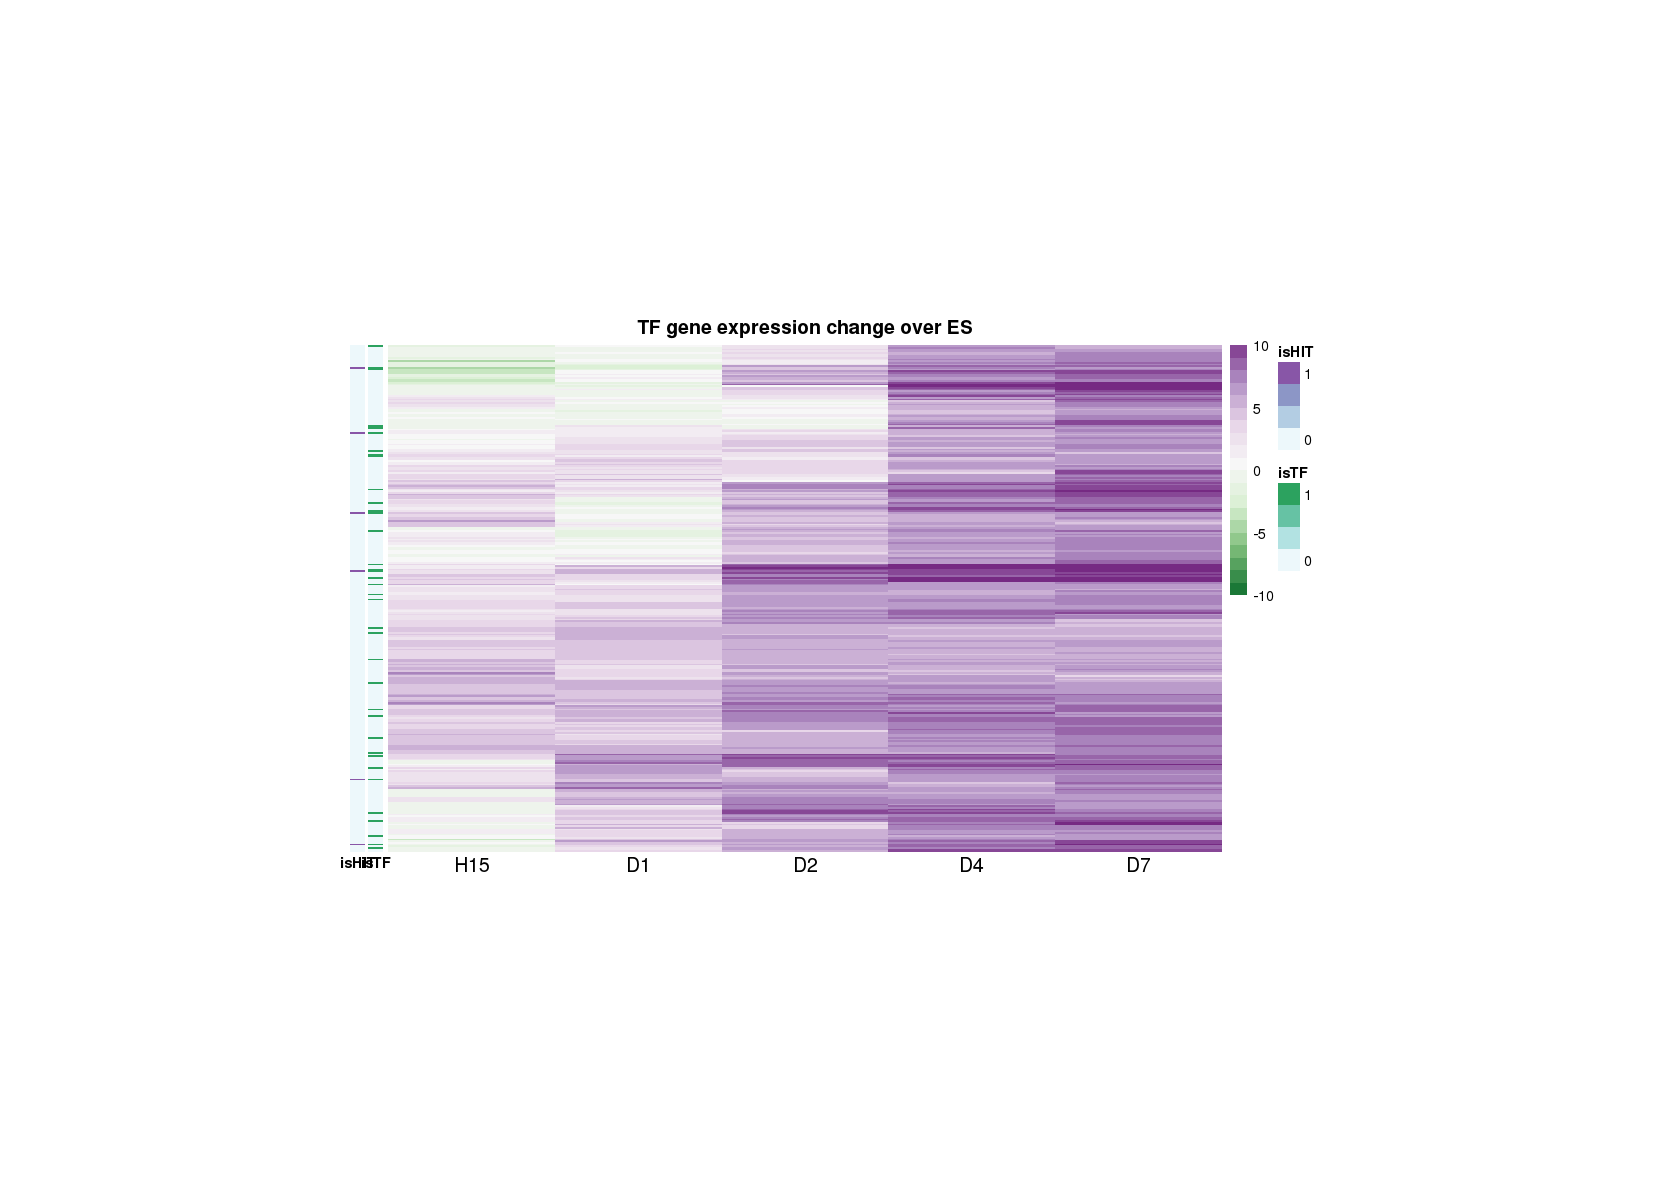

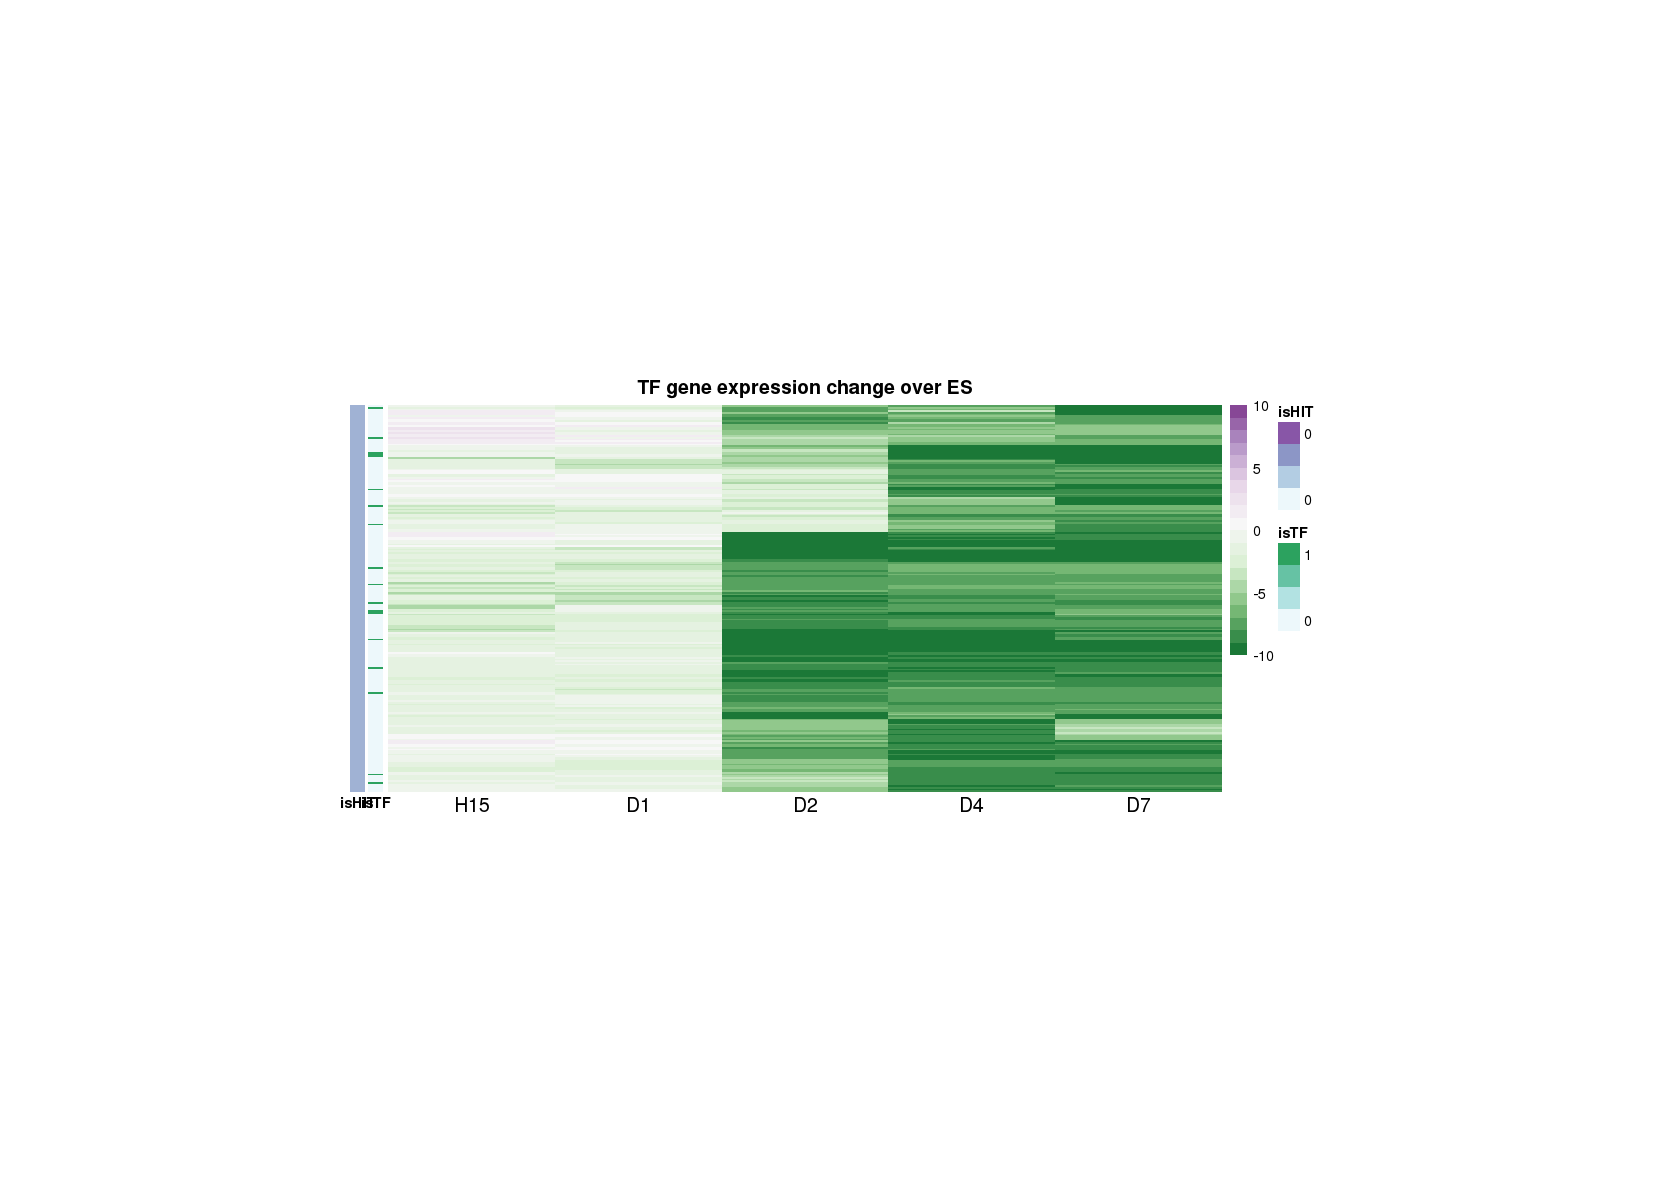

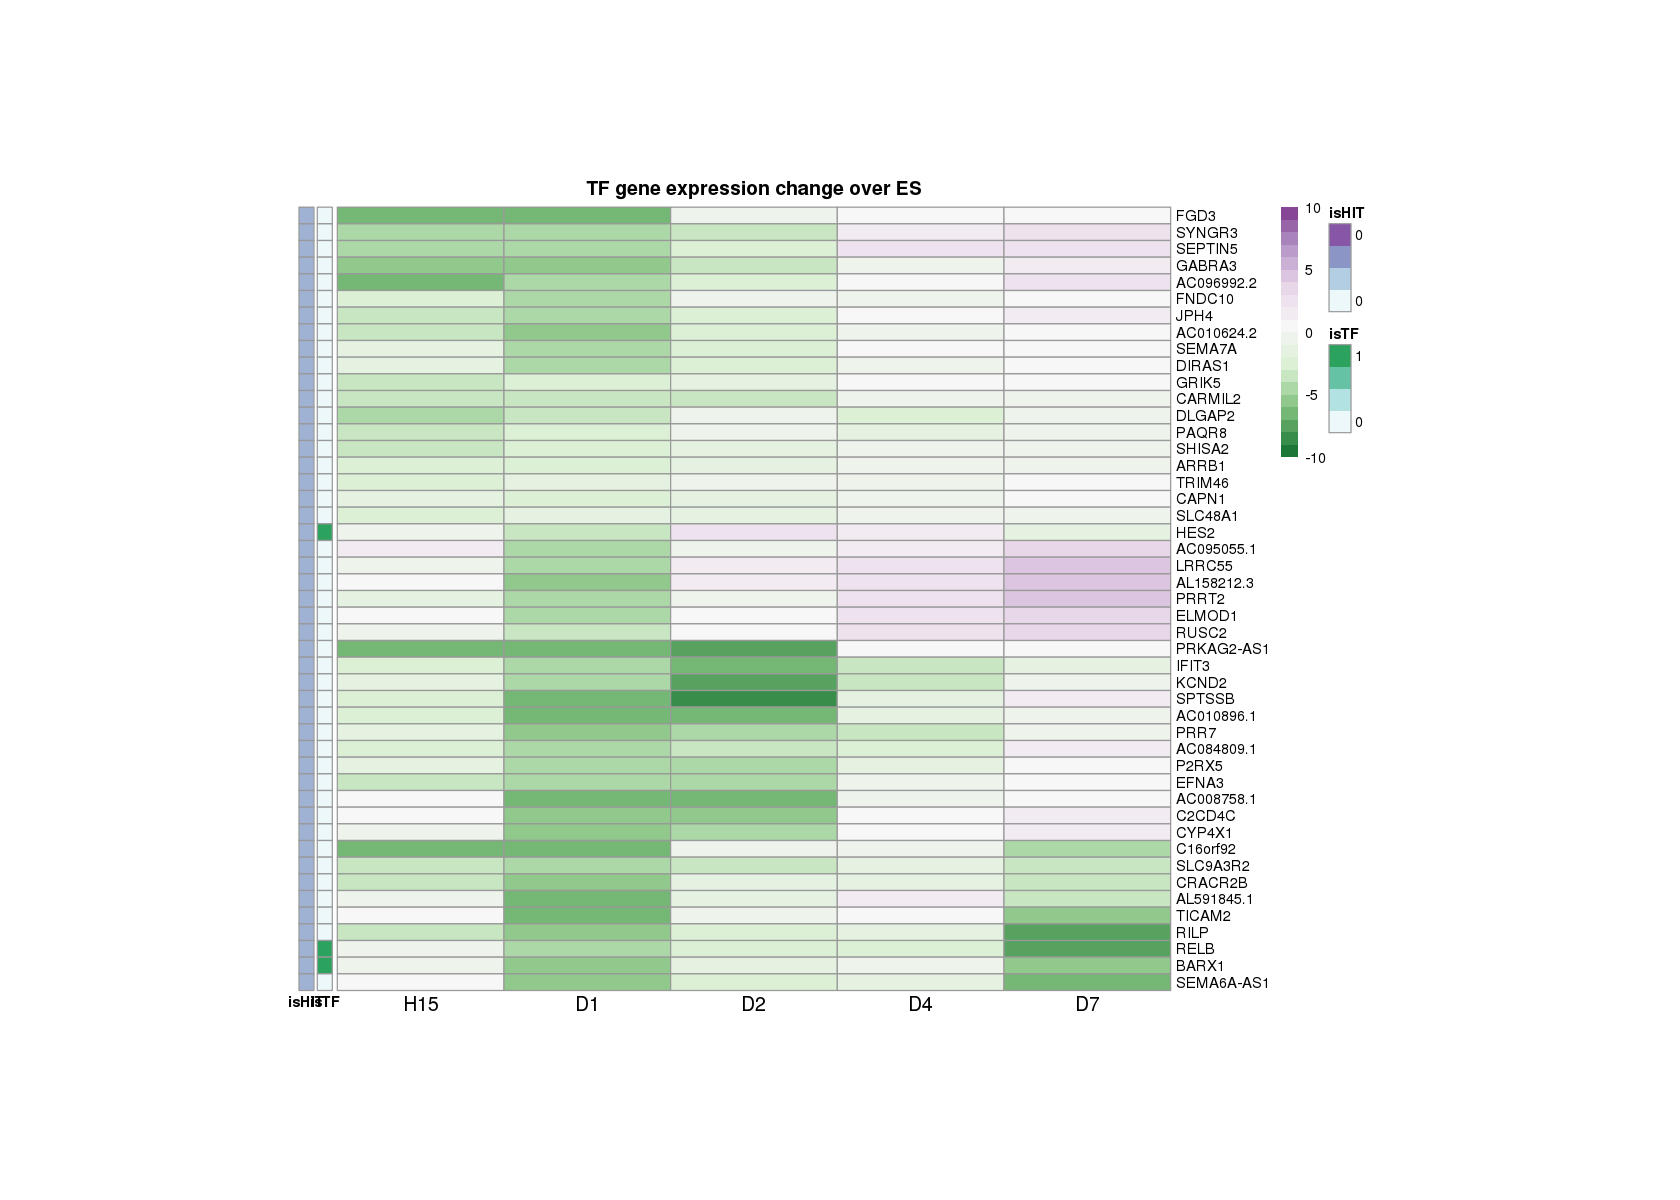

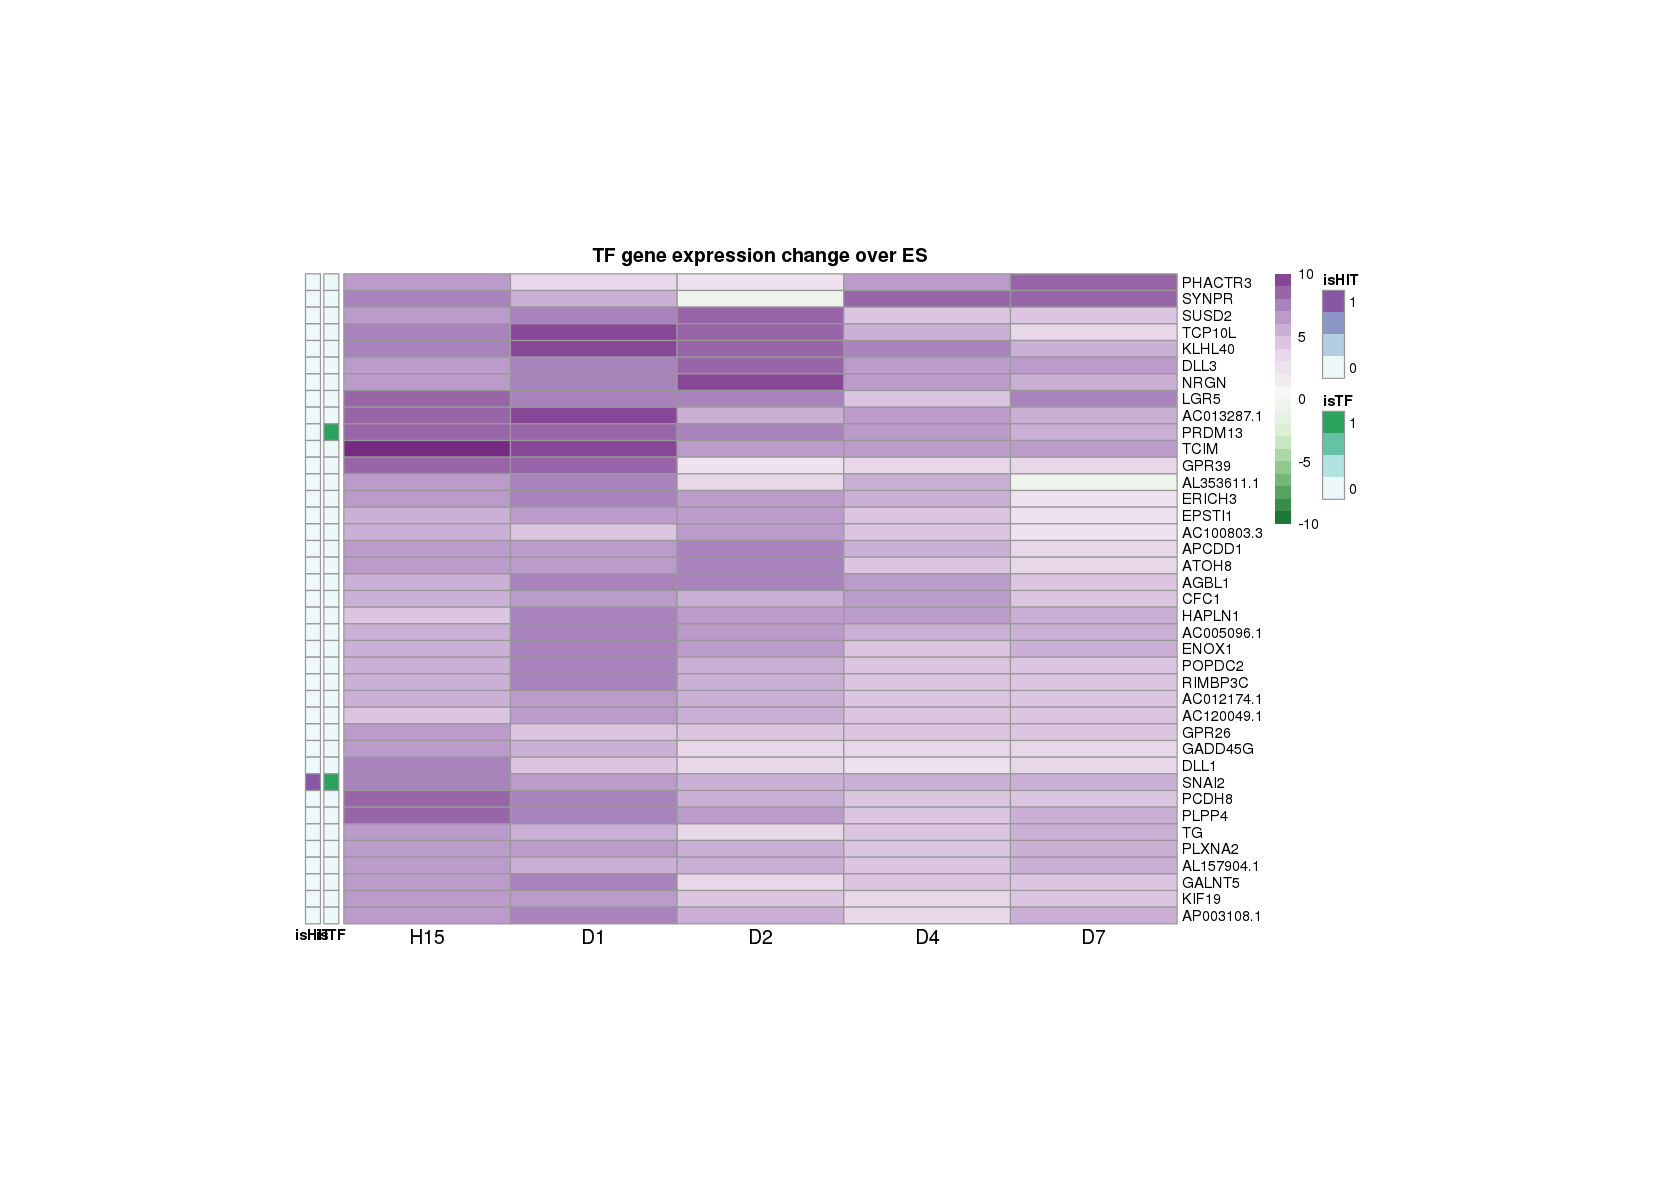

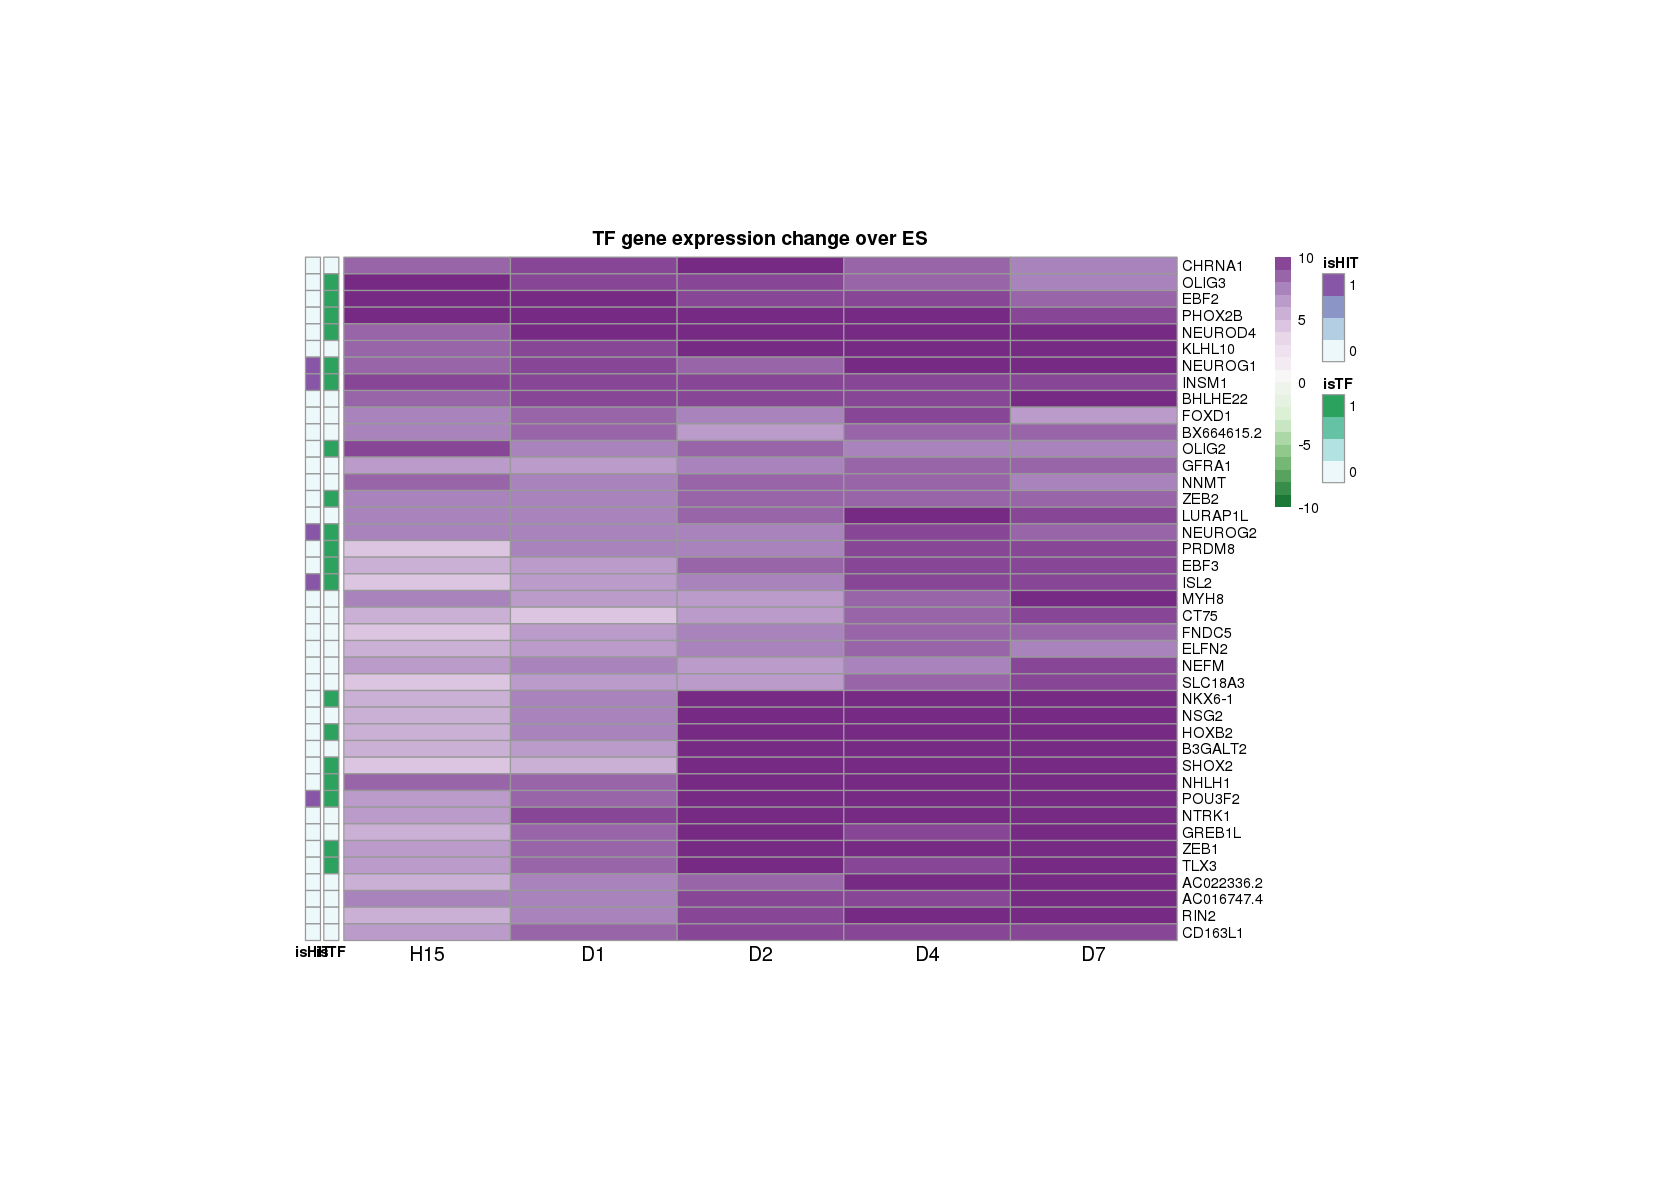

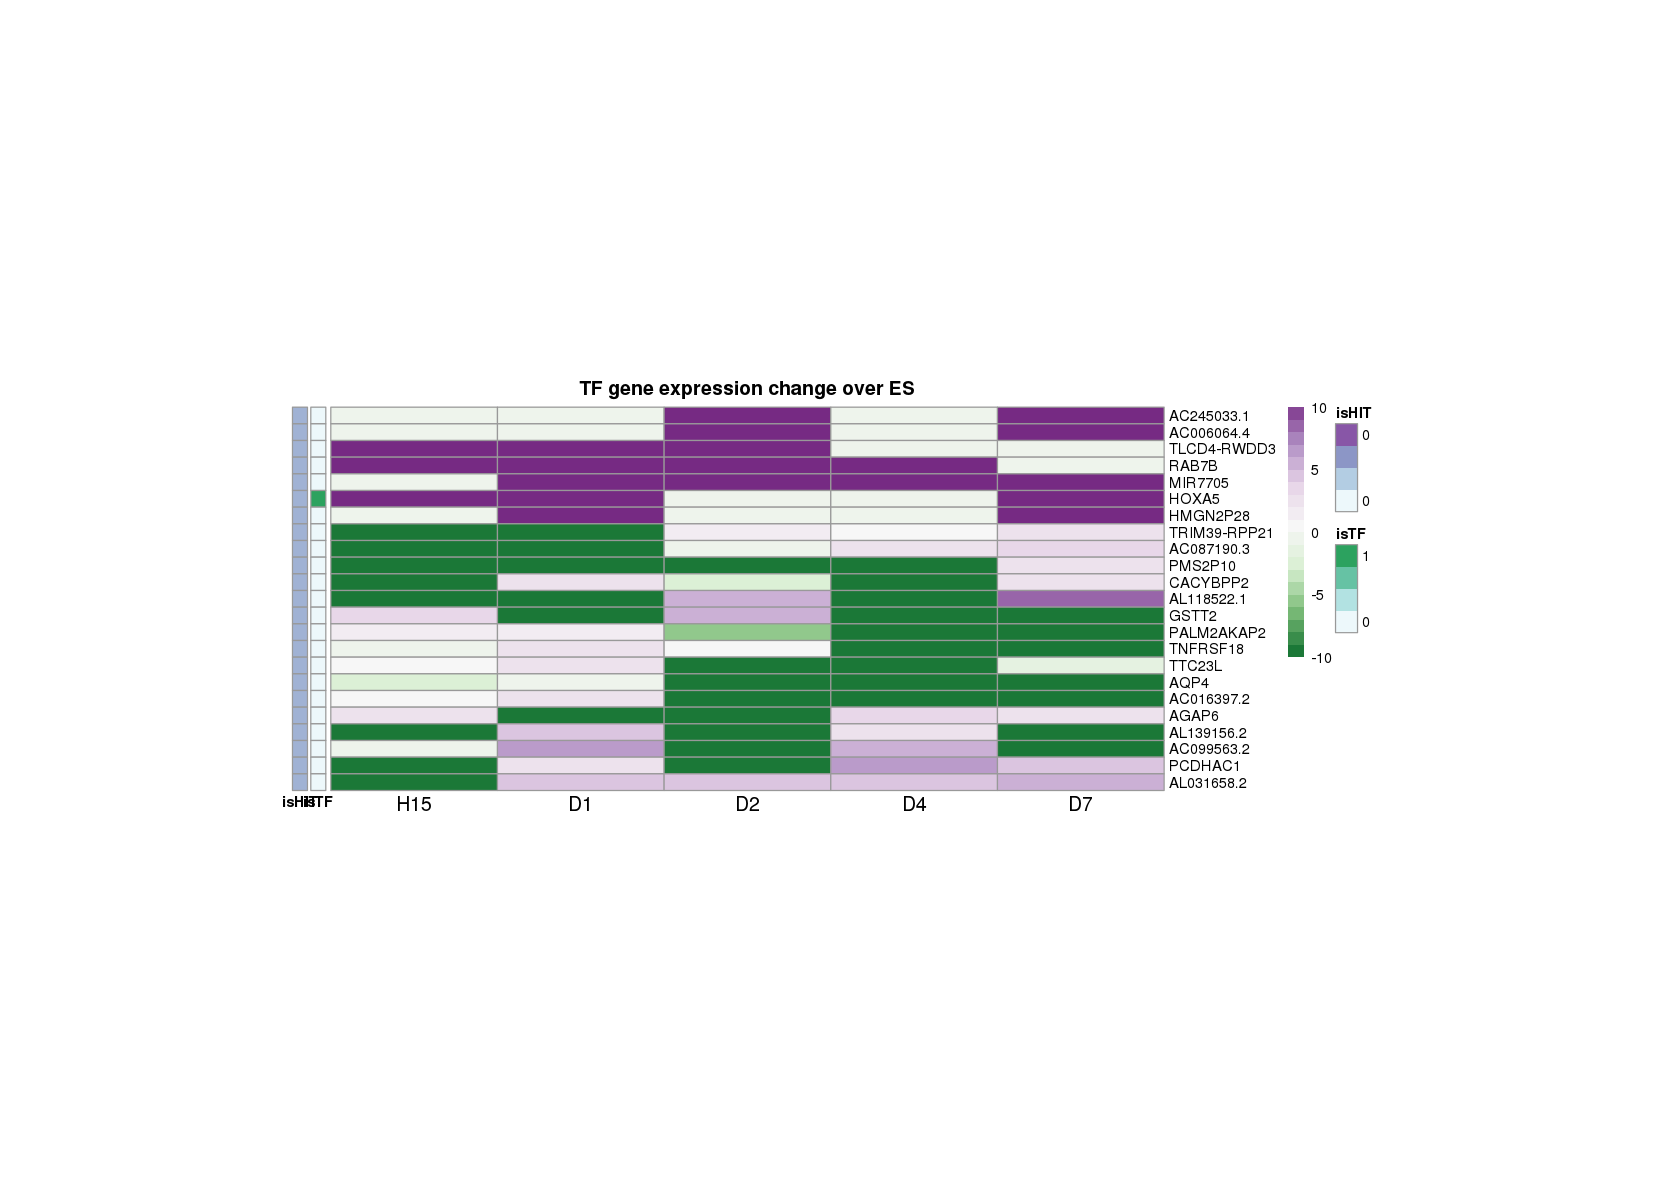

In [880]:
for (i in 1:12) {
    my.pheatmap(clusters1.mx[[i]], clusters1.an[[i]])
}

In [549]:
clusters.mx <- paste0("cluster", 1:10, ".mx")
clusters.mx <- c(clusters.mx, "cluster11plus.mx")
rna.sig.genes.by.cluster <- paste0("cluster", 1:10, "sigft_genes.txt")
rna.sig.genes.by.cluster <- c(rna.sig.genes.by.cluster, "cluster11psigft_genes.txt")

In [569]:
rna.sig.genes.by.cluster %>% t
clusters.mx %>% t

cluster1sigft_genes.txt,cluster2sigft_genes.txt,cluster3sigft_genes.txt,cluster4sigft_genes.txt,cluster5sigft_genes.txt,cluster6sigft_genes.txt,cluster7sigft_genes.txt,cluster8sigft_genes.txt,cluster9sigft_genes.txt,cluster10sigft_genes.txt,cluster11psigft_genes.txt


cluster1.mx,cluster2.mx,cluster3.mx,cluster4.mx,cluster5.mx,cluster6.mx,cluster7.mx,cluster8.mx,cluster9.mx,cluster10.mx,cluster11plus.mx


### Using `Correlation` as clustering method

In [843]:
df2 <- filter(heatmap_df, sigCounts > 1 & mean.abs.l2fc > 1)

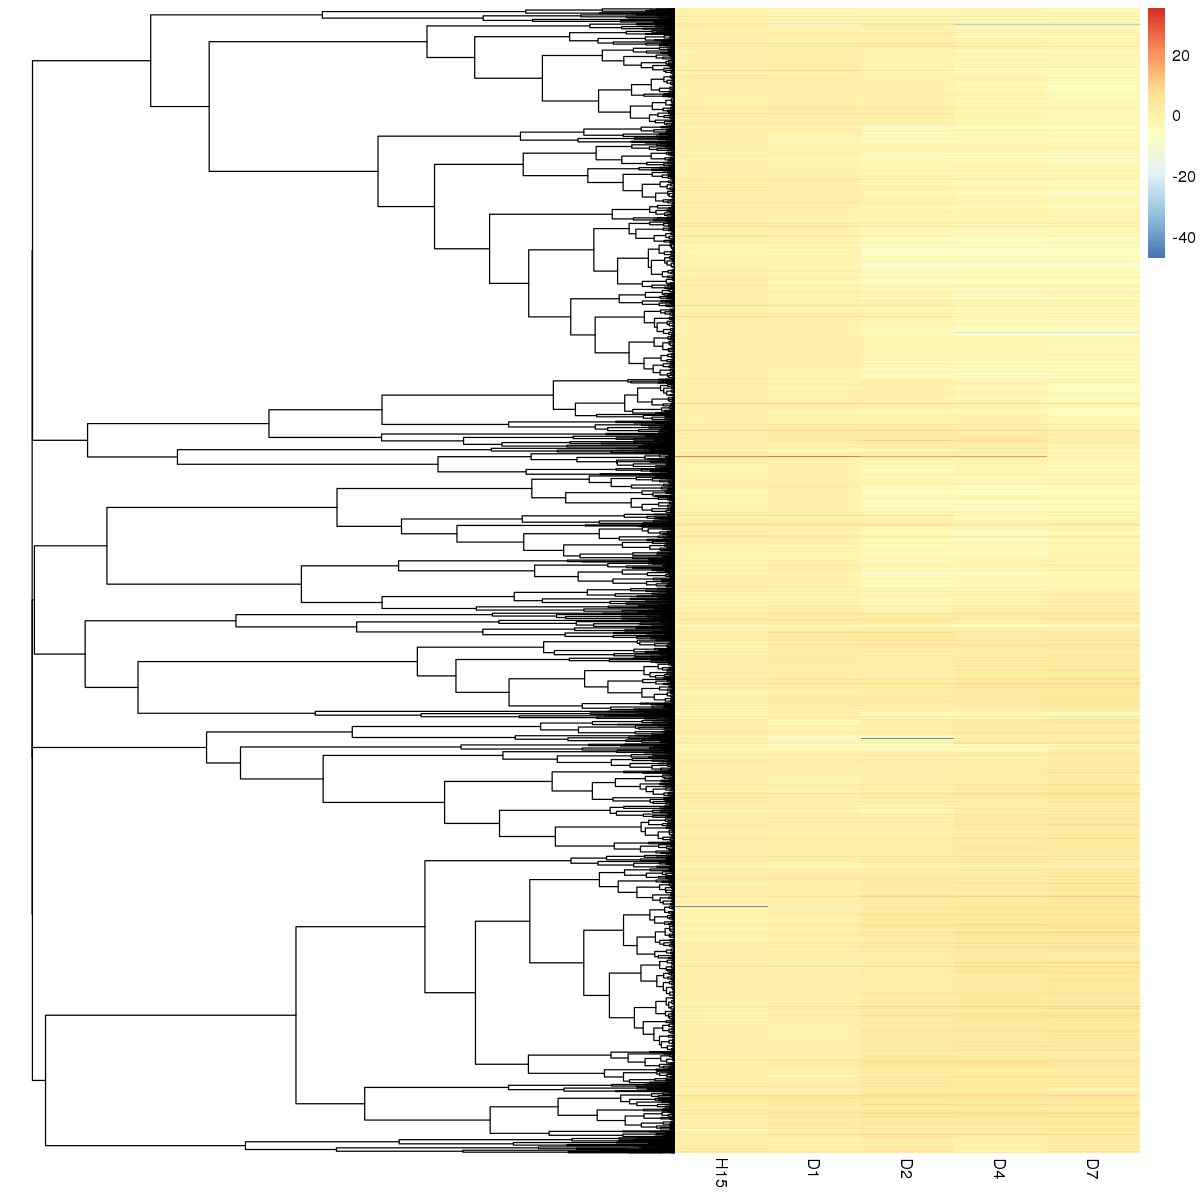

In [845]:
initial_map2 <- select(df2, gene_name, H15:D7) %>% 
                    column_to_rownames("gene_name") %>%
                    pheatmap(cluster_rows = T, show_rownames = F, cluster_cols = F, show_colnames = T,
                         treeheight_row = 400, clustering_distance_rows = "correlation")

In [852]:
clusters2 <- cutree(initial_map2$tree_row, k = 12)

In [853]:
map(1:12, ~ length(which(clusters2 == .x))) %>% t

1794,134,269,424,349,681,360,1425,138,74,82,44


In [854]:
df2 <- add_column(df2, cluster = clusters2)

In [855]:
df2 %>% head

gene_id,gene_name,H15,D1,D2,D4,D7,H15_vs_ES,D1_vs_ES,D2_vs_ES,D4_vs_ES,D7_vs_ES,sigCounts,pattern,mean.abs.l2fc,isTF,isHIT,rank,cluster
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<int>
ENSG00000000460.17,C1orf112,0.5850347,-0.1684901,-0.6350139,-2.5606942,-3.0439906,FALSE,FALSE,FALSE,TRUE,TRUE,2,24,2.802342,FALSE,FALSE,1,1
ENSG00000001461.17,NIPAL3,0.7798943,1.7114340,1.3023046,0.6141820,0.7415282,FALSE,TRUE,TRUE,FALSE,FALSE,2,6,1.506869,FALSE,FALSE,1,2
ENSG00000001617.12,SEMA3F,-1.8348933,-0.7635346,-6.3123599,-3.9732193,-1.6982634,FALSE,FALSE,TRUE,TRUE,TRUE,3,28,3.994614,FALSE,FALSE,1,3
ENSG00000001630.17,CYP51A1,1.7327958,1.2488794,0.4263824,0.5360152,1.6020563,TRUE,TRUE,FALSE,FALSE,TRUE,3,19,1.527910,FALSE,FALSE,1,4
ENSG00000002586.20,CD99,1.2853105,0.9205293,1.1420945,0.9041245,-0.6101863,TRUE,TRUE,TRUE,TRUE,FALSE,4,15,1.063015,FALSE,FALSE,1,5
ENSG00000002587.10,HS3ST1,-0.1704085,0.8428847,-0.6788173,2.6757314,3.7827695,FALSE,FALSE,FALSE,TRUE,TRUE,2,24,3.229250,FALSE,FALSE,1,6


In [860]:
# create a list of matrix for pheatmap
clusters2.mx <- map(1:12, ~ filter(df2, cluster == .x) %>% select(gene_name:D7) %>% column_to_rownames("gene_name"))

In [861]:
# similarly create the corresponding annotations for each cluster
clusters2.an <- map(1:12, ~ filter(df2, cluster == .x) %>% select(gene_name, isTF, isHIT) %>% mutate_at(c("isTF", "isHIT"), as.integer) %>% column_to_rownames("gene_name"))

In [863]:
cluster2.tf.ratio <- map_int(clusters2.an, ~ filter(.x, isTF == 1) %>% nrow) / map_int(clusters2.an, ~ nrow(.x))

In [864]:
cluster2.hit.ratio <- map_int(clusters2.an, ~ filter(.x, isHIT == 1) %>% nrow) / map_int(clusters2.an, ~ nrow(.x))

In [865]:
cluster2.names <- factor(paste0(rep("C", 12), 1:12), levels = paste0(rep("C", 12), 1:12) )

In [866]:
cluster2.stats <- data.frame("cluster"=cluster2.names, "tf.ratio" = cluster2.tf.ratio, "hit.ratio" = cluster2.hit.ratio)

In [885]:
g2 <- cluster2.stats %>% pivot_longer(cols = c("tf.ratio", "hit.ratio"), names_to = "ratio.type", values_to = "ratio") %>%
ggplot() + geom_bar(aes(x=cluster, y=ratio, fill=ratio.type), stat = "identity", position = "dodge") +
            theme_classic() + 
            theme(axis.text=element_text(size=16), axis.title=element_text(size=16,face="bold"),
                  legend.text=element_text(size=16),legend.title=element_text(size=16), strip.text = element_text(size = 16)) + 
            xlab("Cluster") + ylab("Proportion")

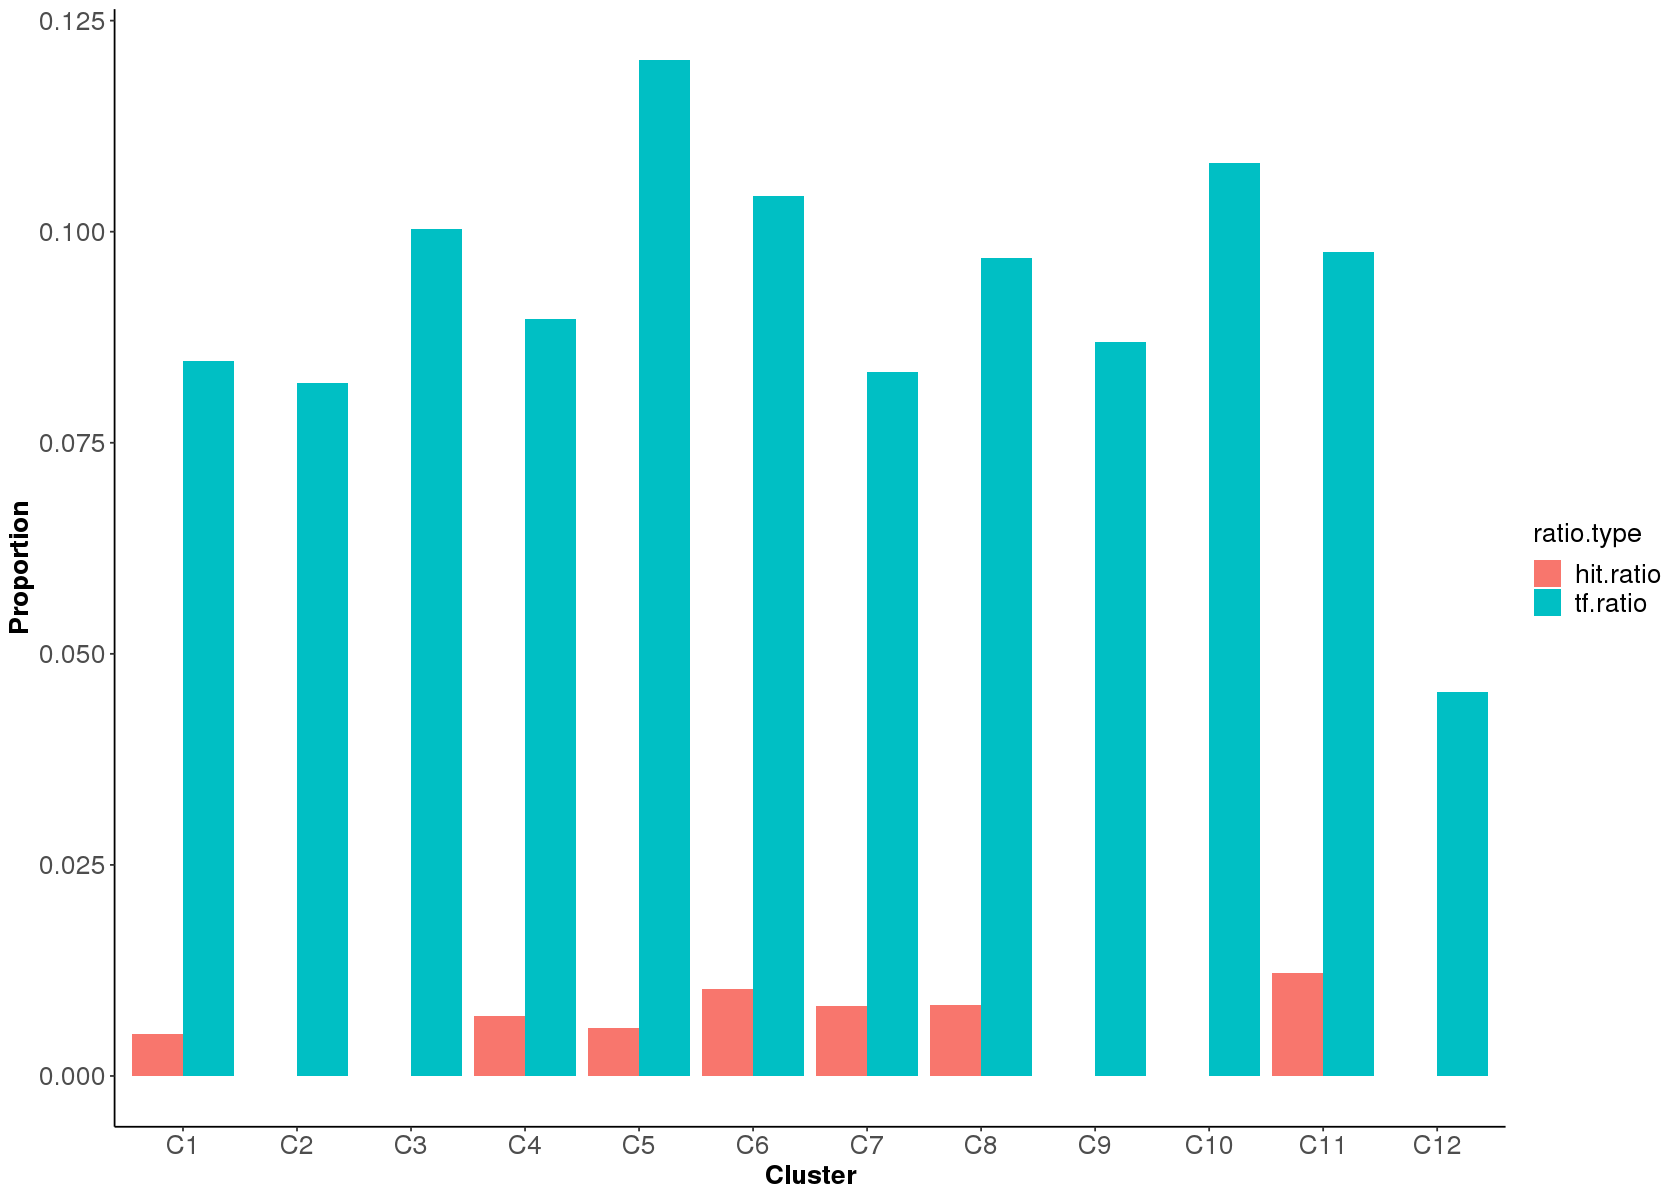

In [886]:
g2

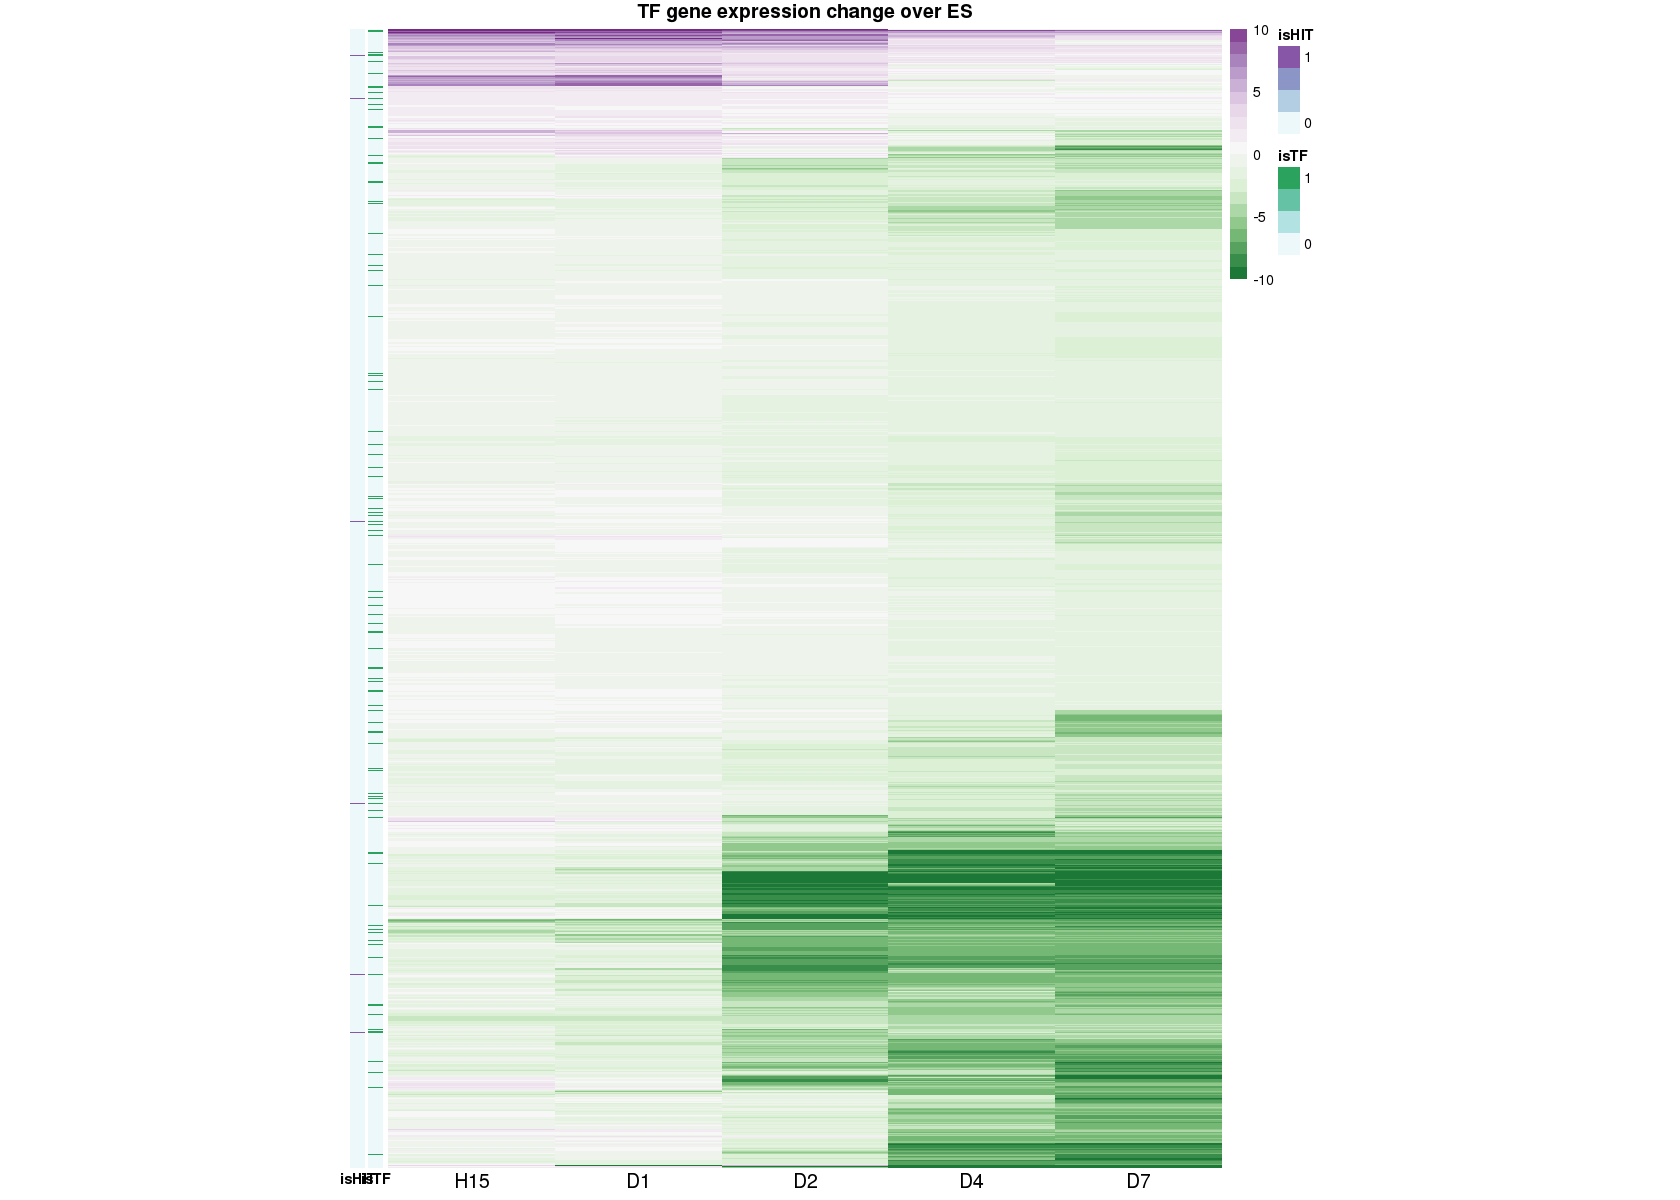

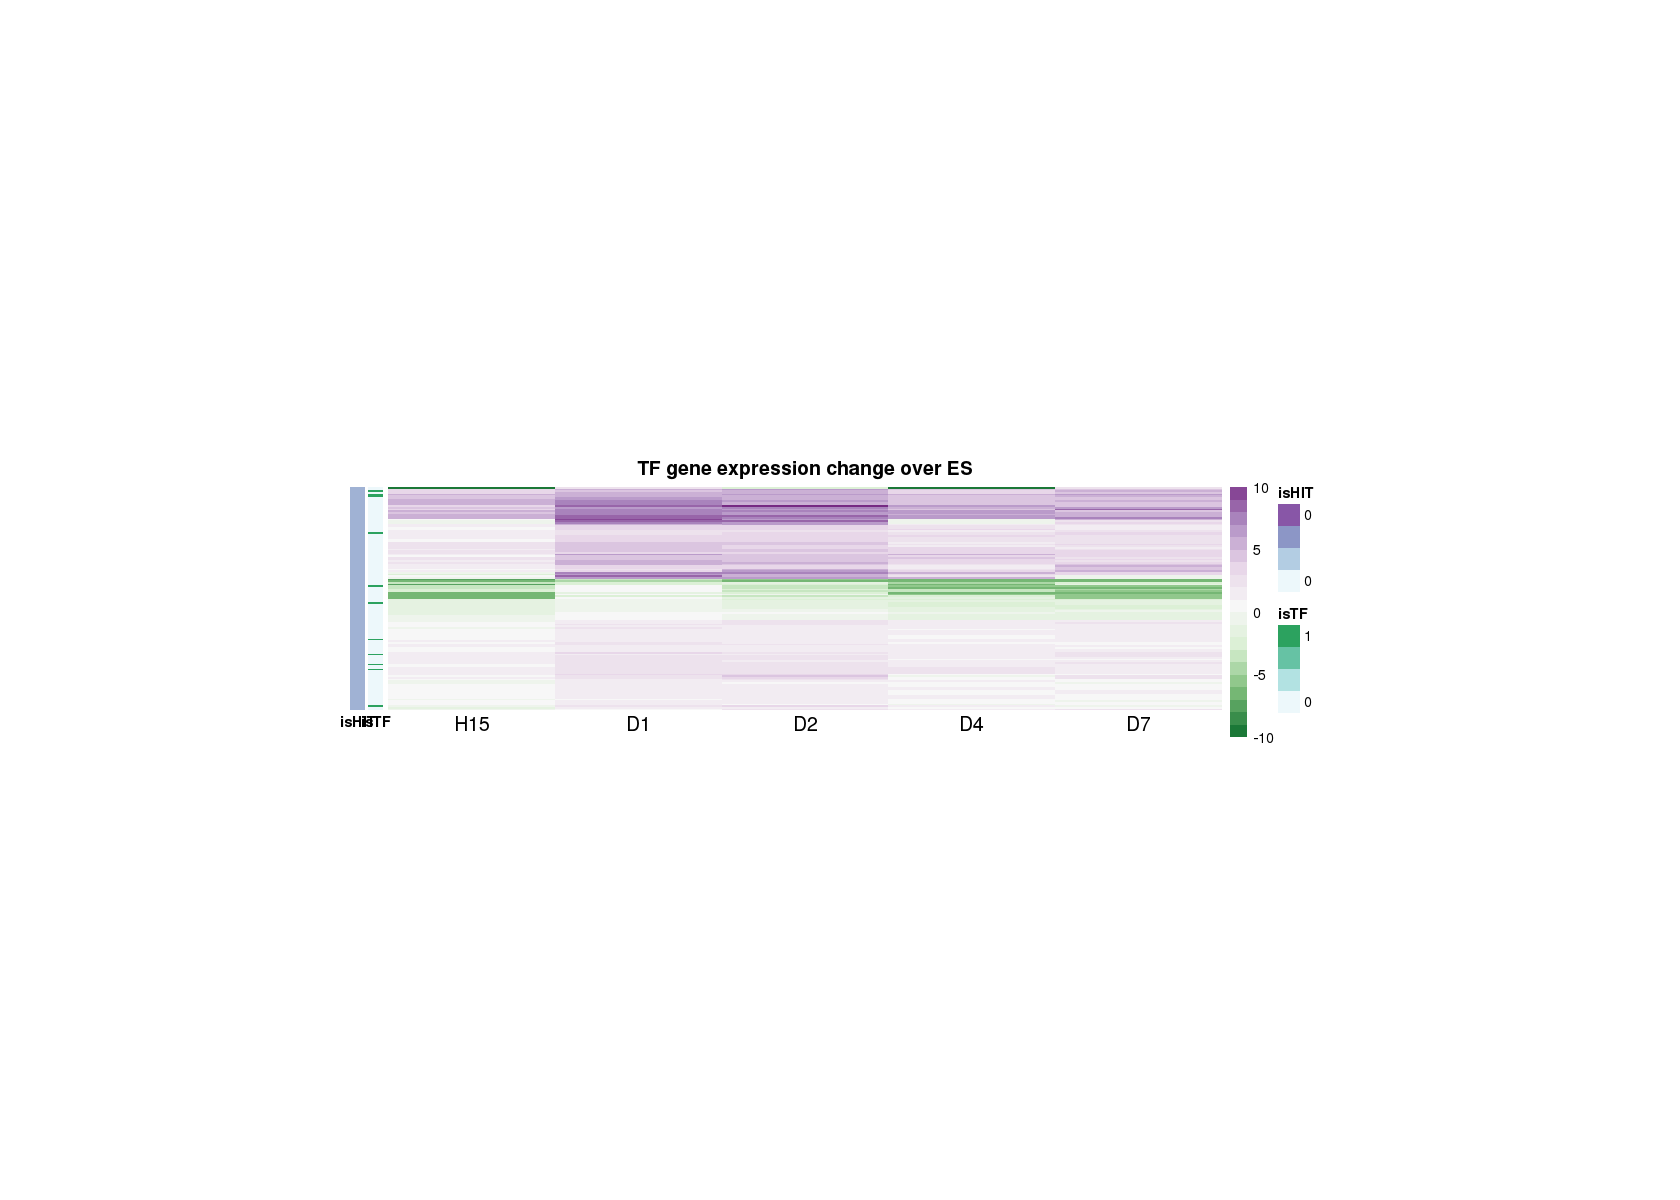

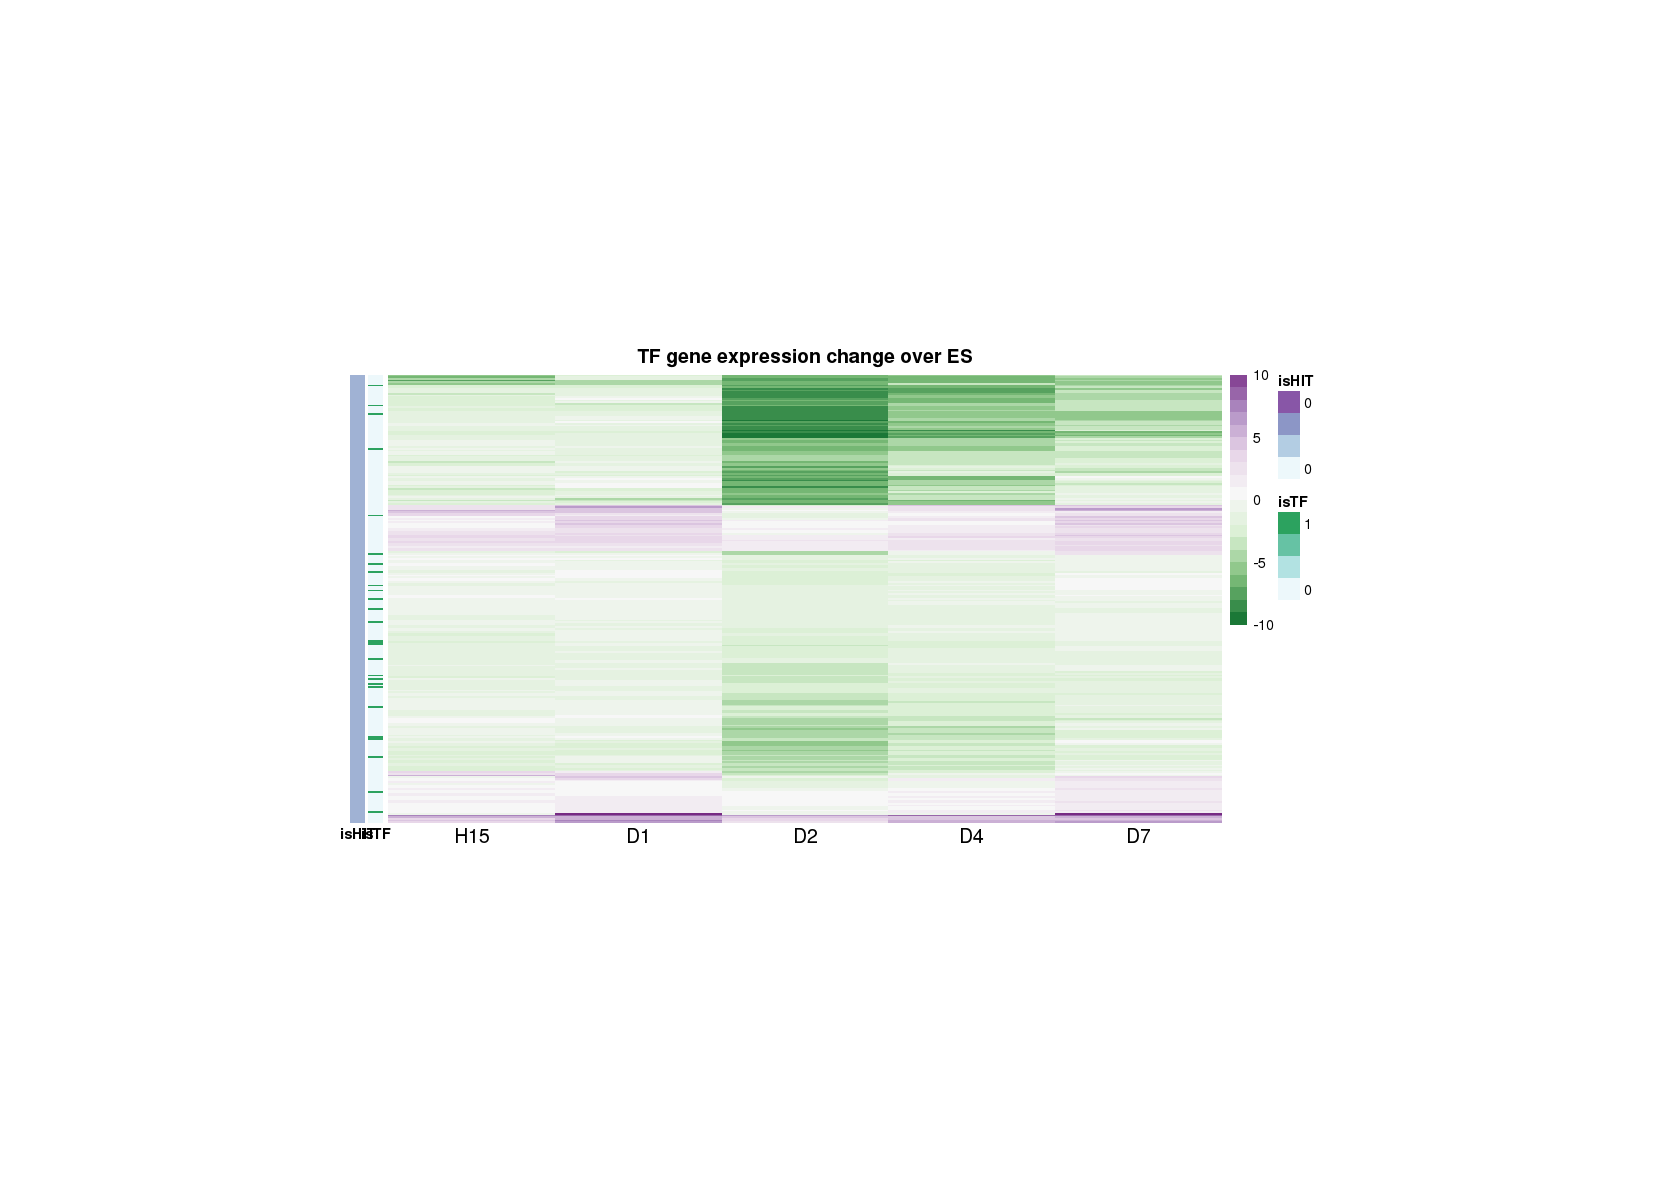

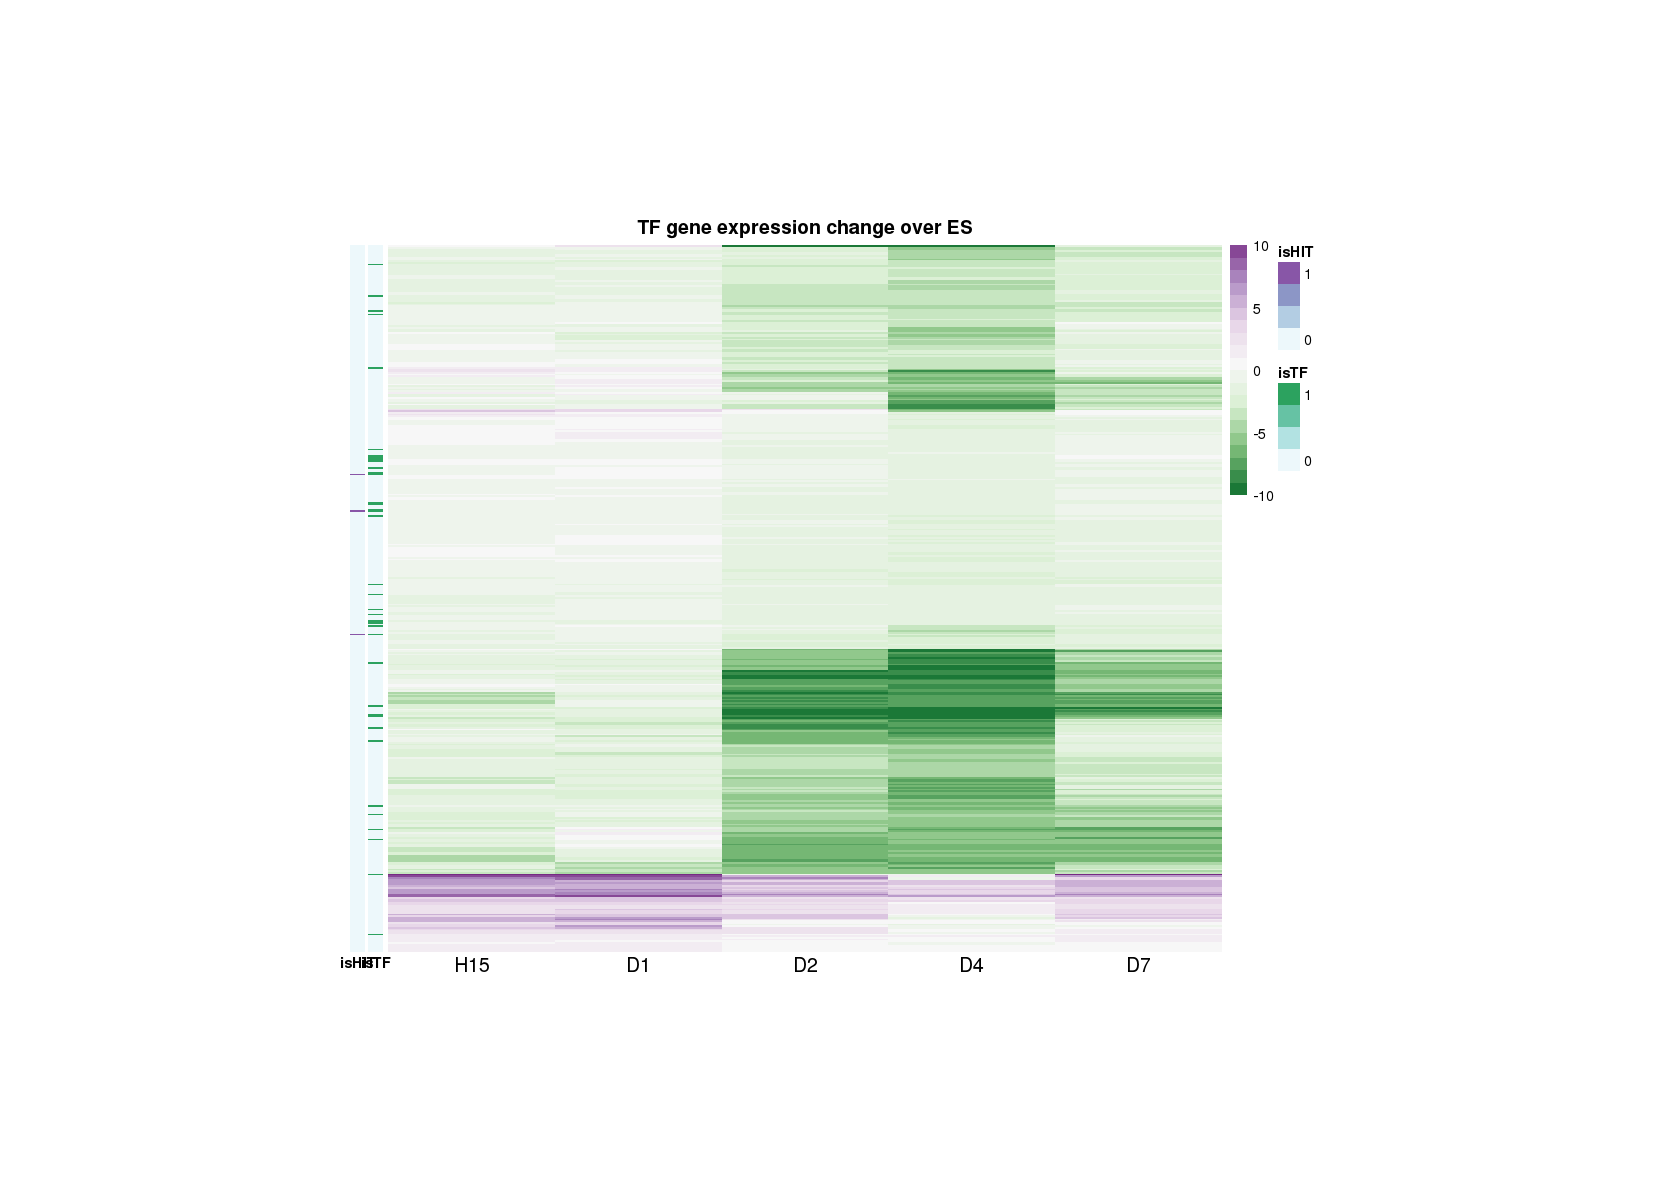

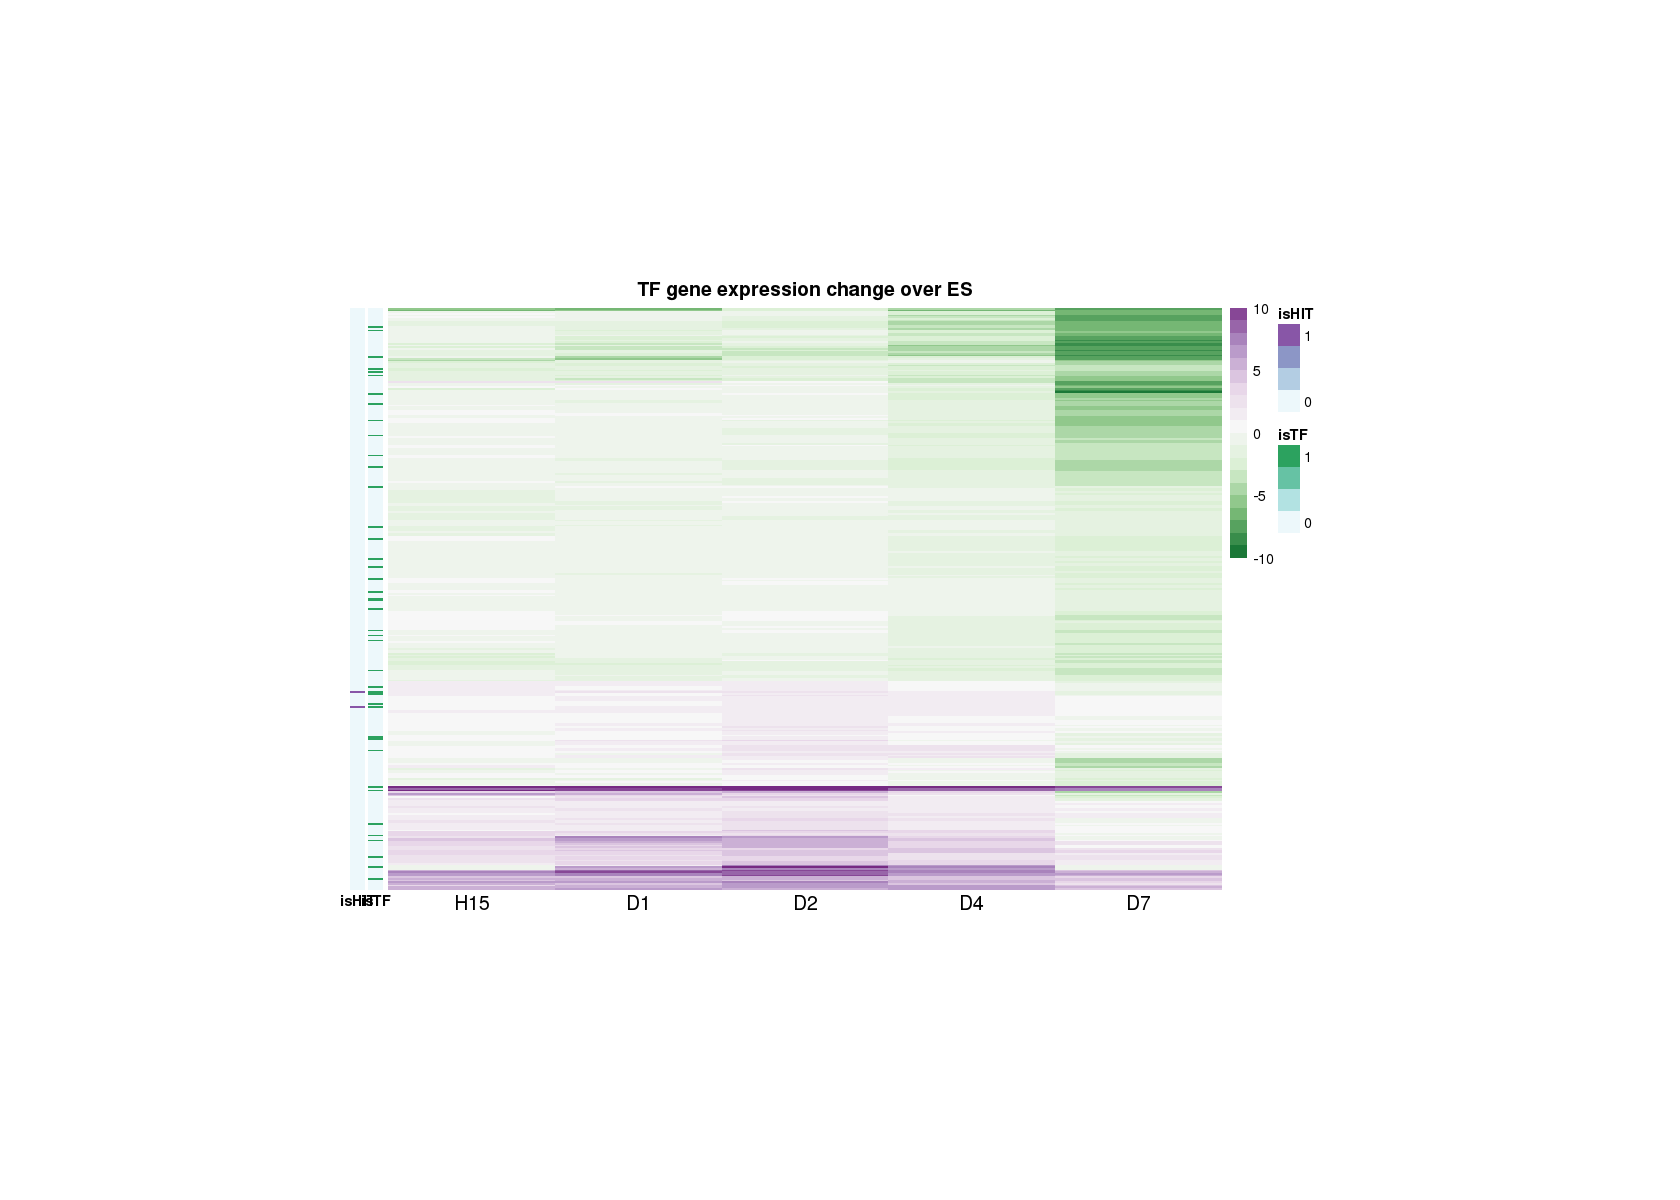

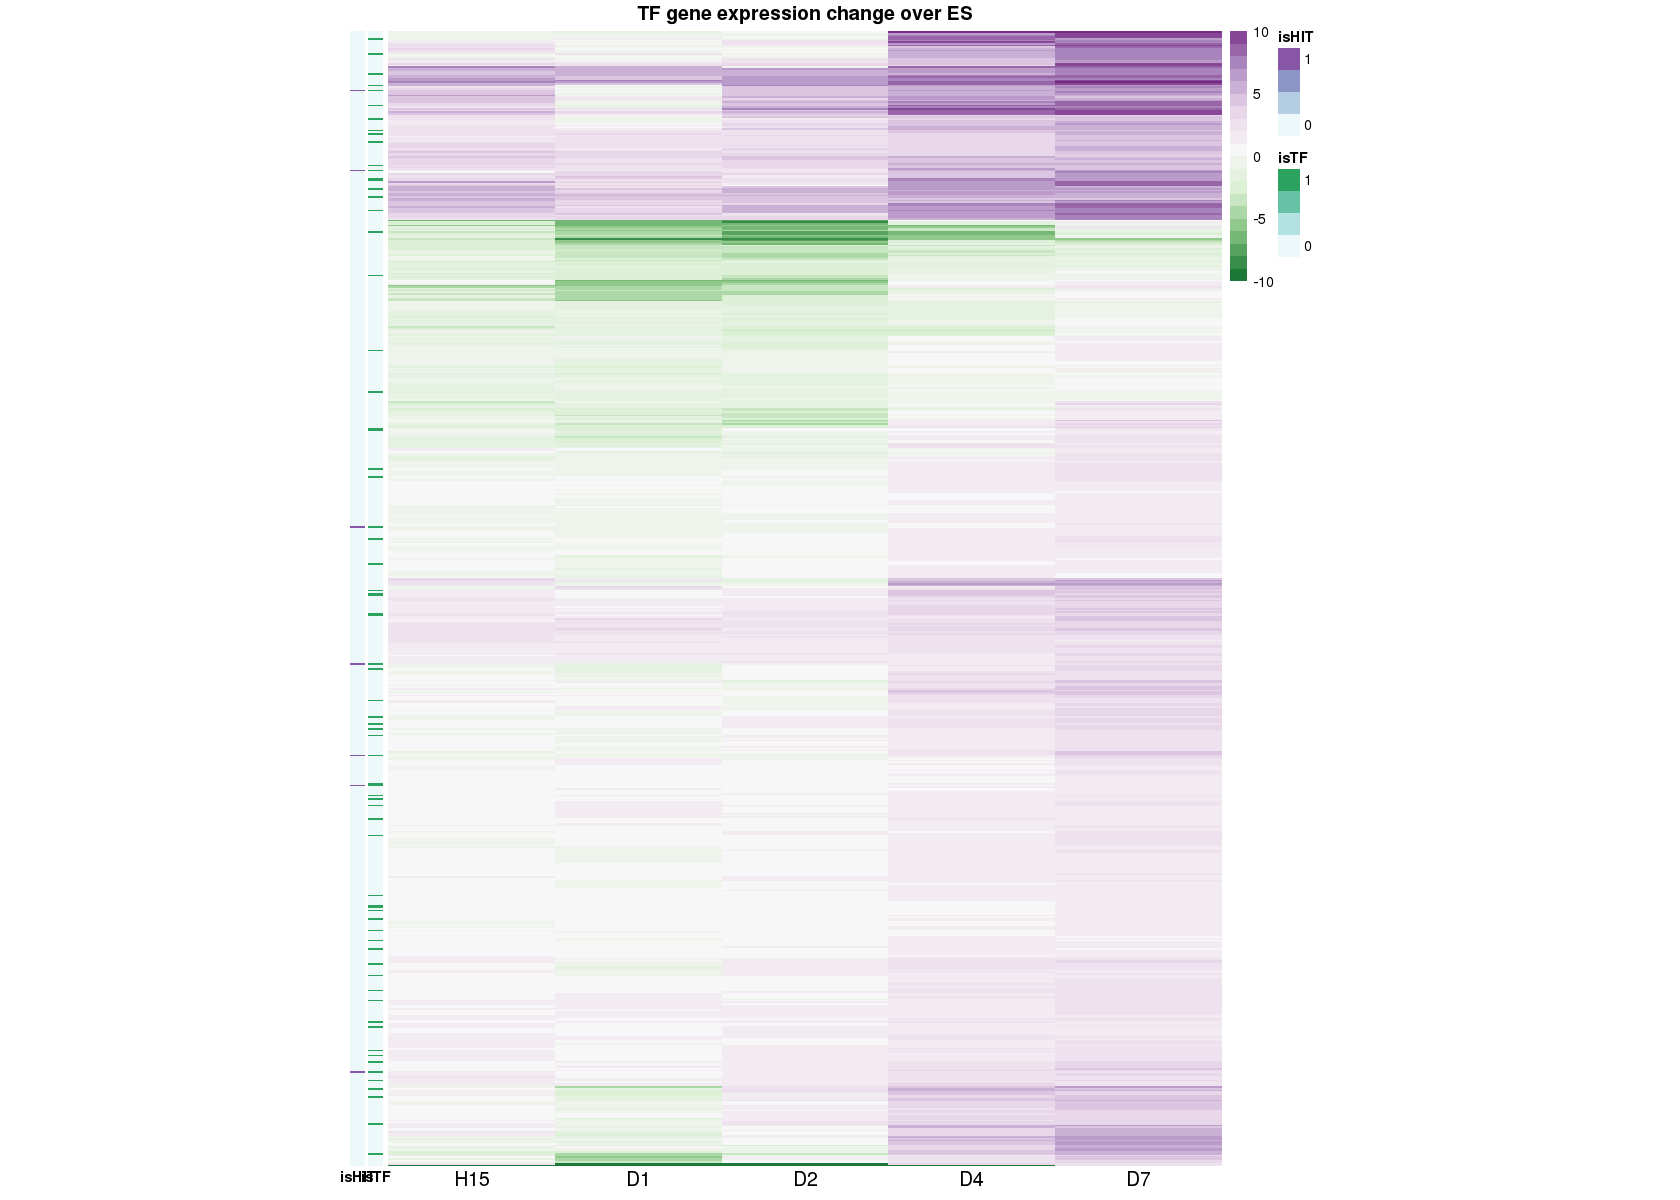

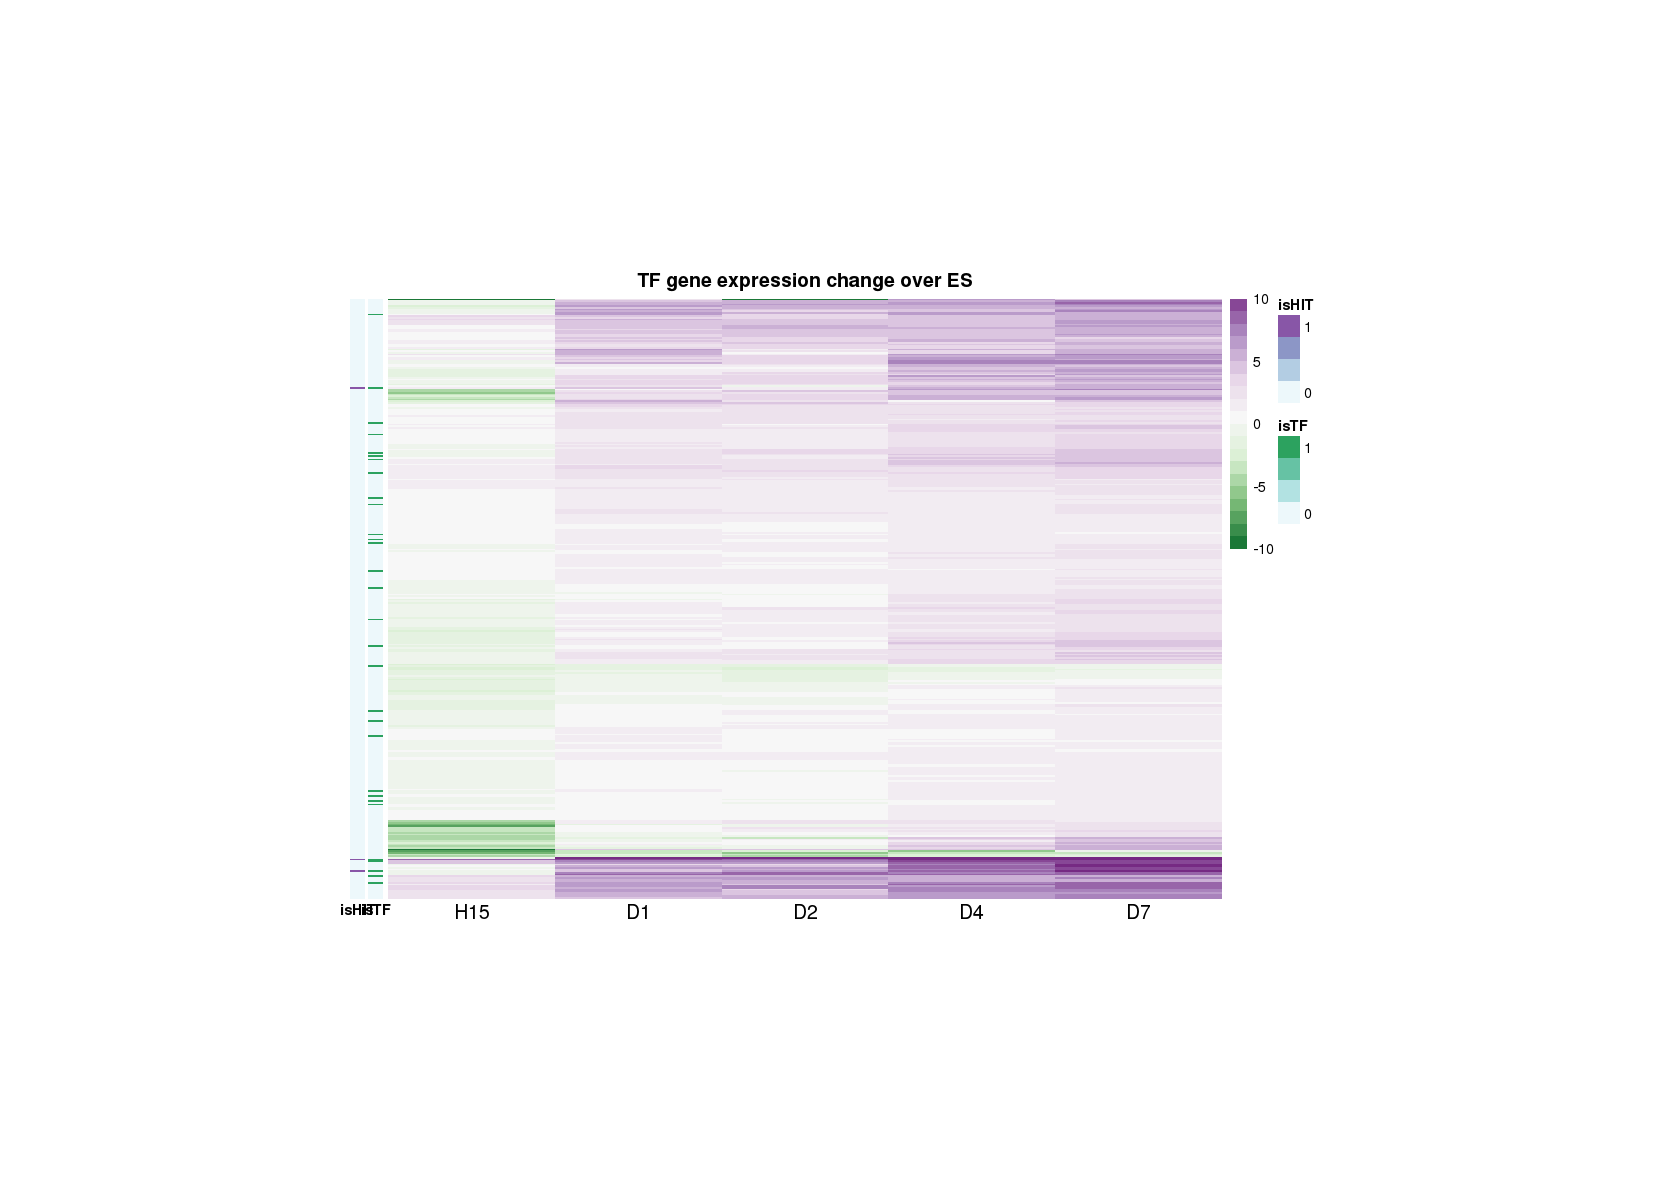

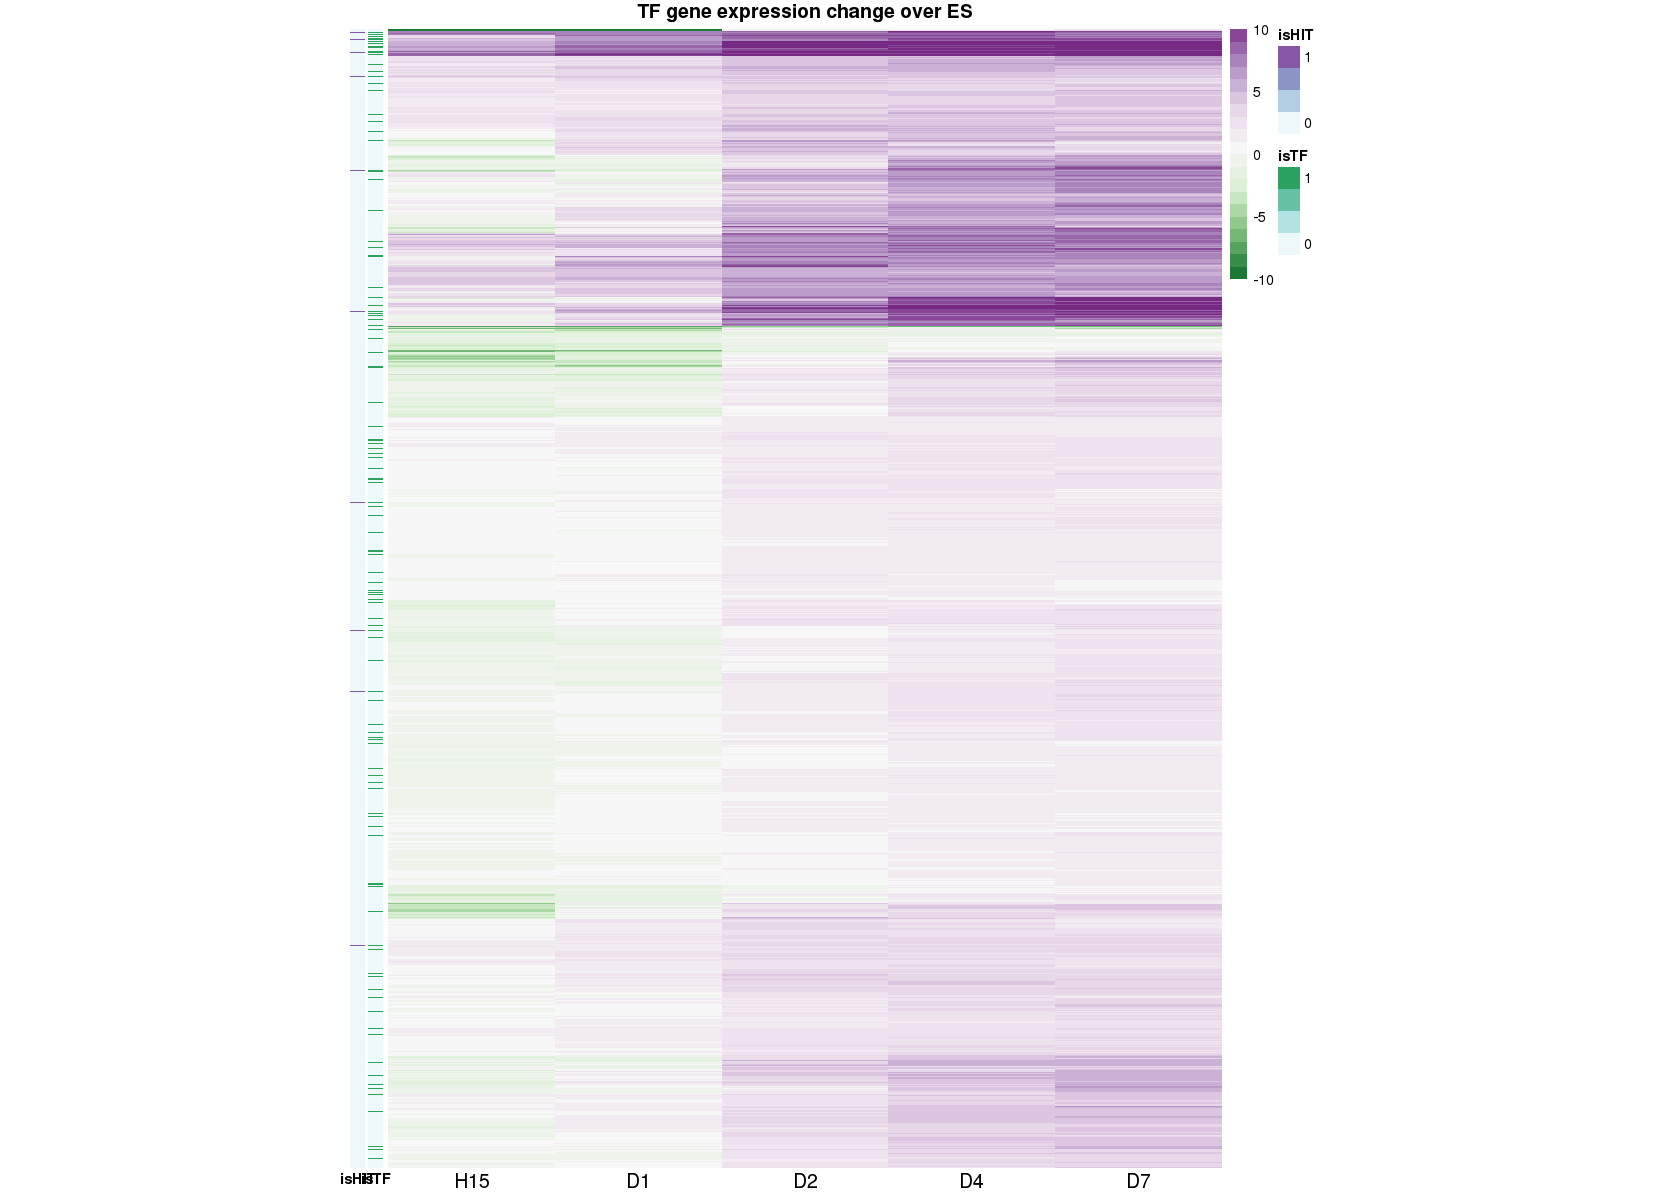

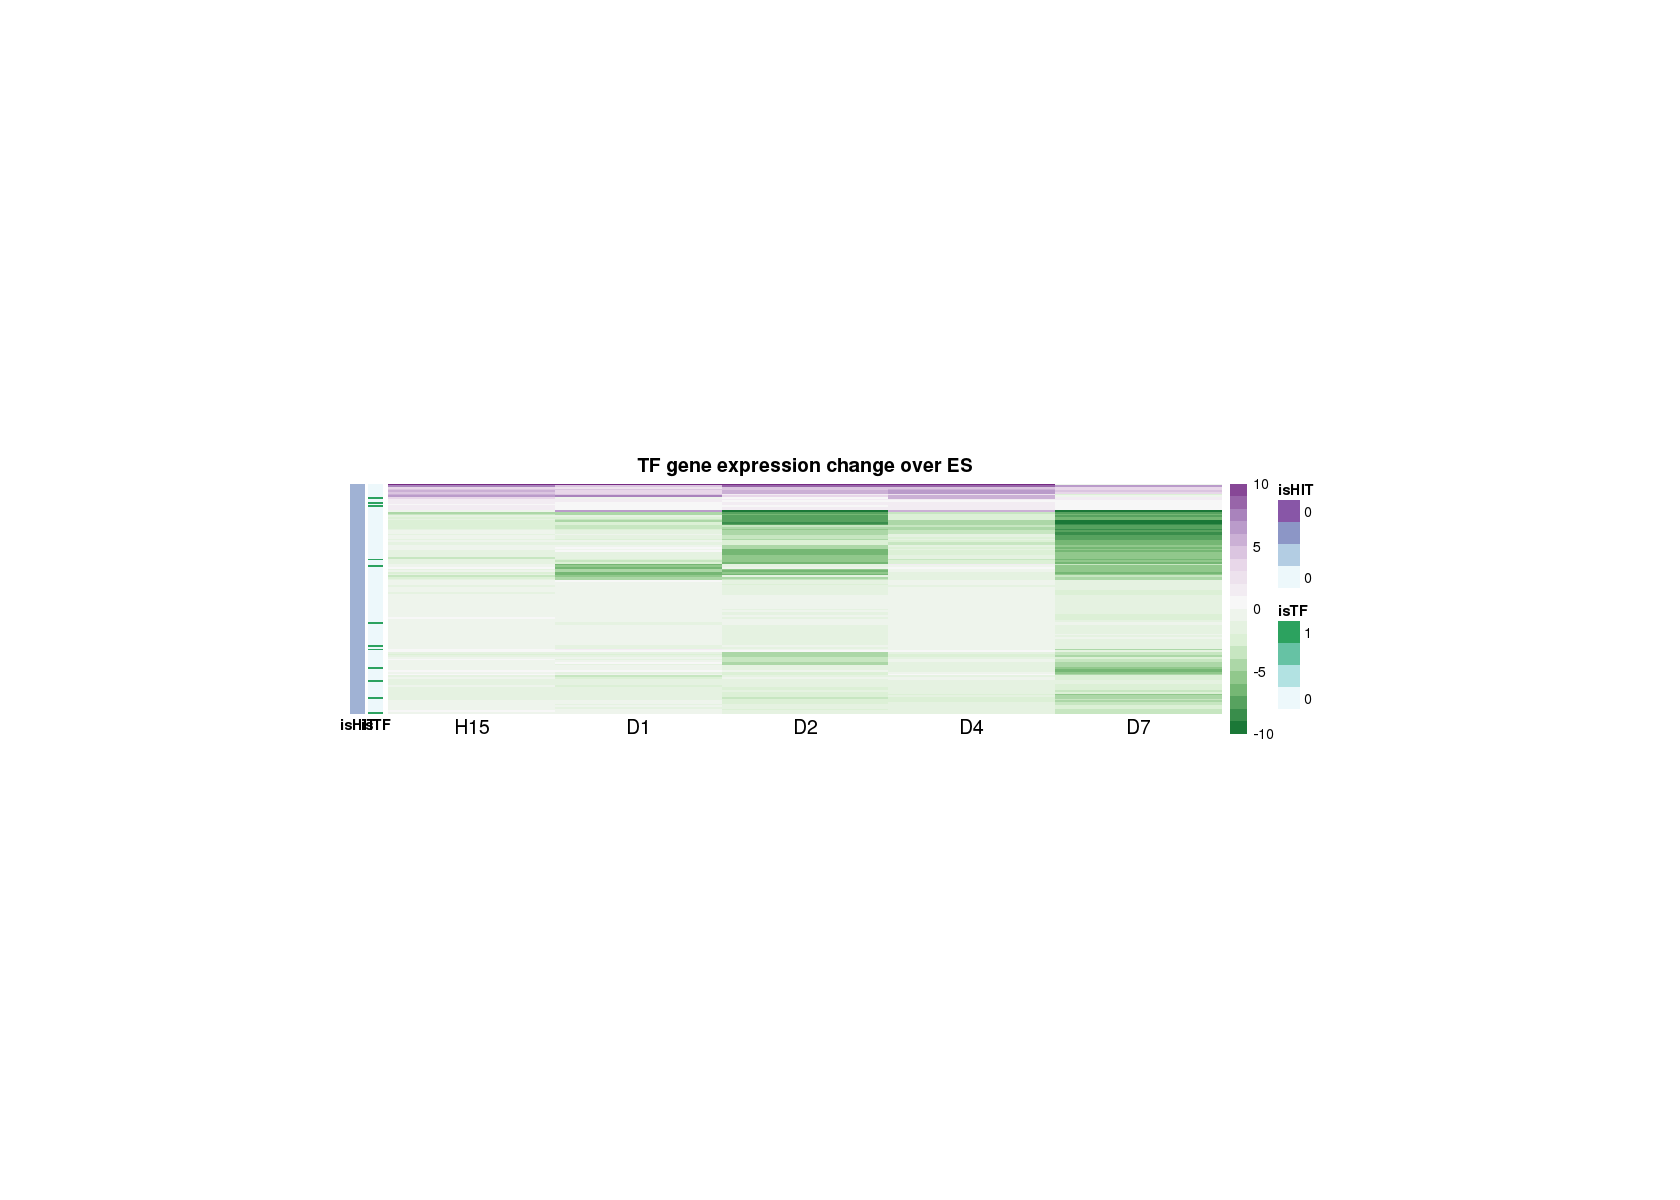

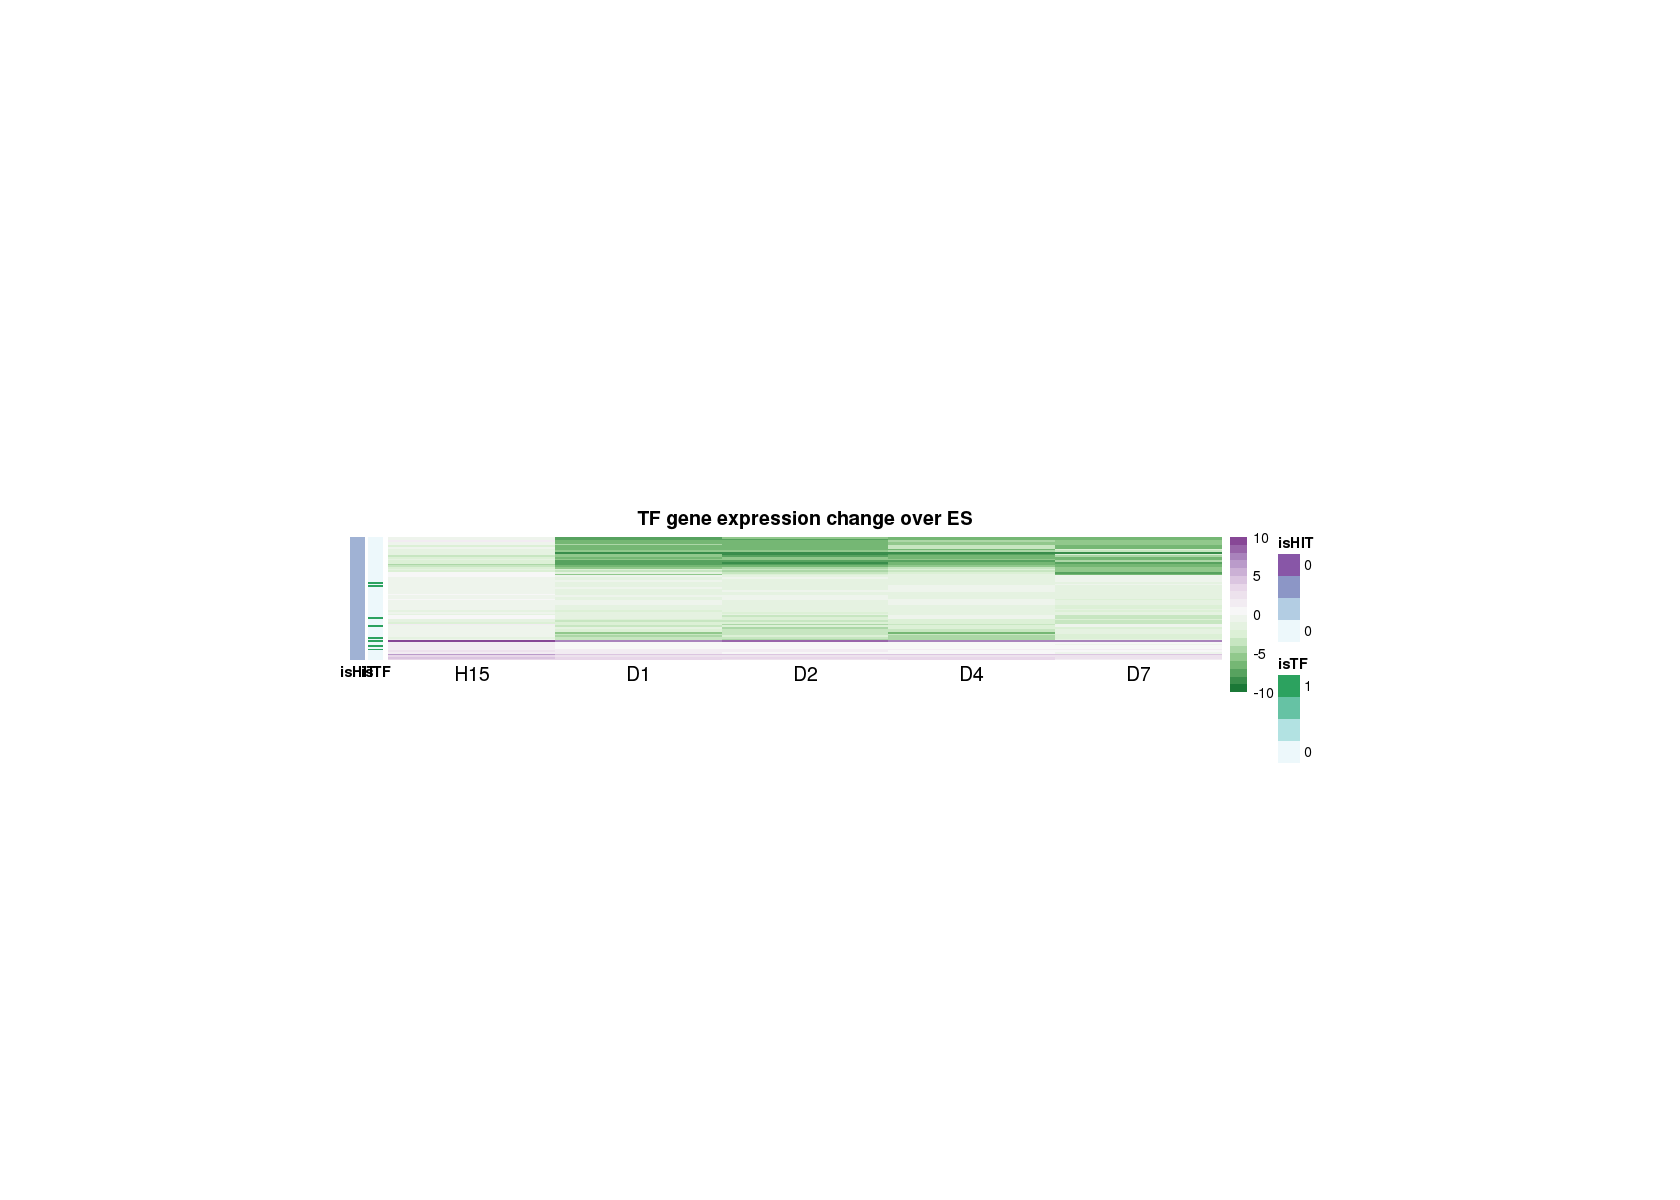

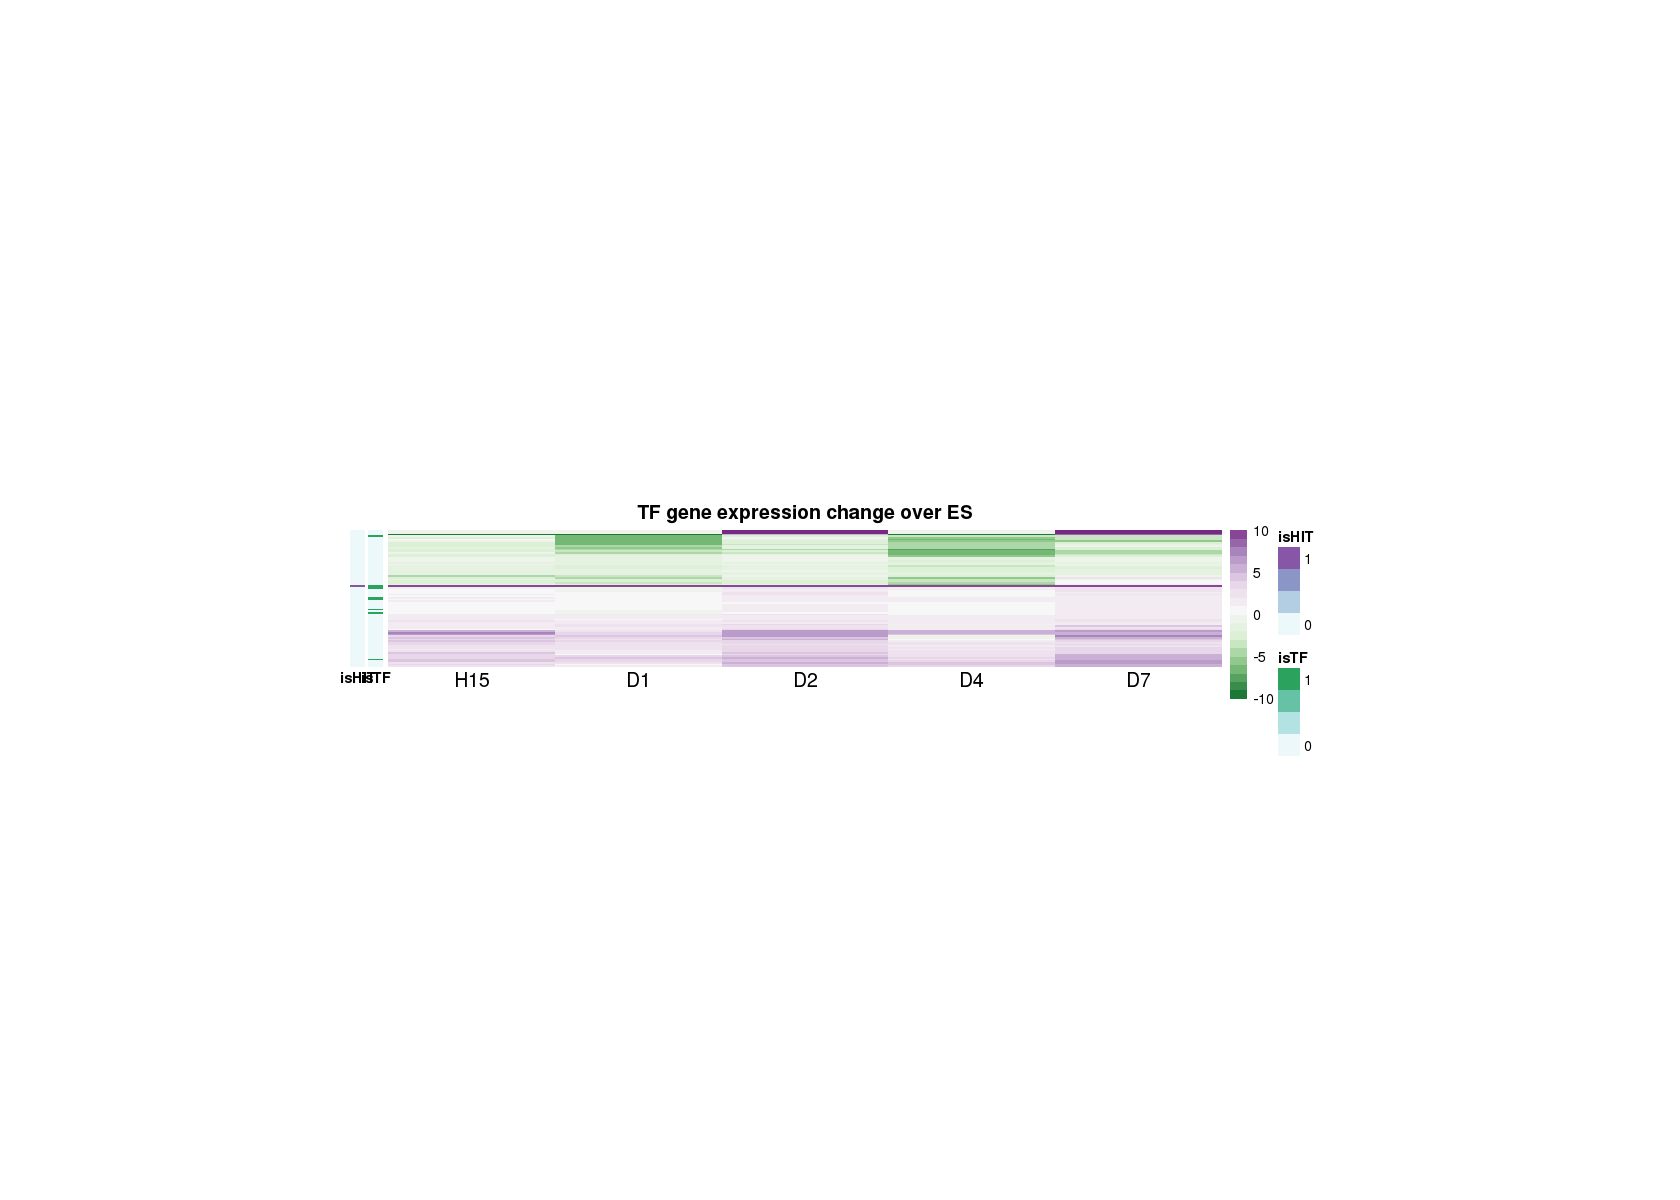

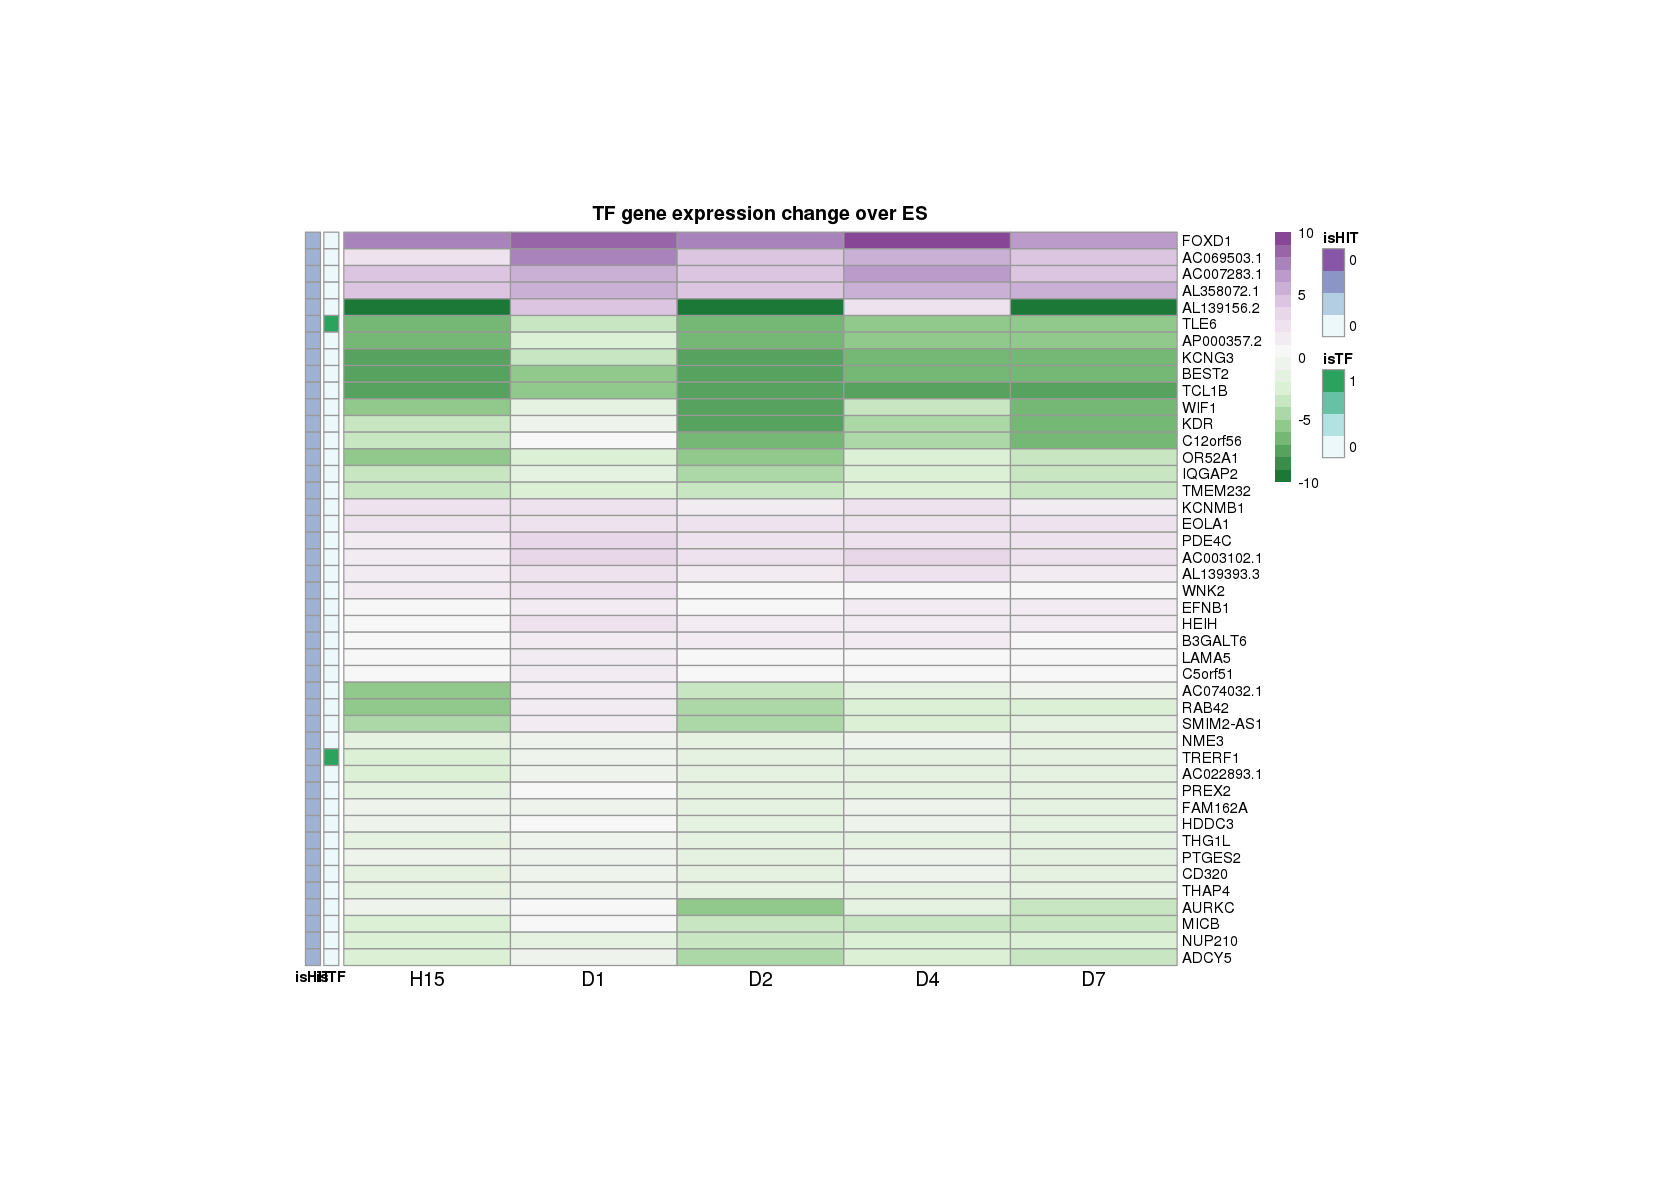

In [882]:
for (i in 1:12) {
    my.pheatmap(clusters2.mx[[i]], clusters2.an[[i]])
}

In [575]:
getwd()

[1] "/gpfs/commons/groups/sanjana_lab/cdai/TFscreen"

In [578]:
BiocManager::install("clusterProfiler")

Bioconductor version 3.9 (BiocManager 1.30.4), R 3.6.1 (2019-07-05)

Installing package(s) 'clusterProfiler'

also installing the dependencies ‘triebeard’, ‘tweenr’, ‘polyclip’, ‘fastmatch’, ‘urltools’, ‘gridGraphics’, ‘ggforce’, ‘tidygraph’, ‘graphlayouts’, ‘DO.db’, ‘fgsea’, ‘europepmc’, ‘ggplotify’, ‘ggraph’, ‘UpSetR’, ‘DOSE’, ‘enrichplot’, ‘GOSemSim’, ‘rvcheck’


installation path not writeable, unable to update packages: AnnotationDbi,
  backports, BH, bibtex, BiocManager, BiocParallel, biomaRt, bit, blob, boot,
  callr, caTools, class, cli, covr, crosstalk, curl, DBI, deldir, devtools,
  e1071, fansi, foreach, foreign, fs, future, future.apply, GenomeInfoDb,
  GenomicRanges, ggrepel, ggridges, gh, globals, glue, gmp, gplots, gtools,
  hexbin, htmltools, htmlwidgets, httpuv, httr, igraph, jsonlite, KernSmooth,
  lambda.r, later, lattice, listenv, lpSolve, MASS, Matrix, Matrix.utils,
  memuse, metap, mgcv, mime, nlme, nloptr, NMF, nnet, pbapply, pillar,
  pkgbuild, pkgconfig, pkgmak

In [579]:
BiocManager::install("AnnotationHub")

Bioconductor version 3.9 (BiocManager 1.30.4), R 3.6.1 (2019-07-05)

Installing package(s) 'AnnotationHub'

also installing the dependencies ‘BiocFileCache’, ‘interactiveDisplayBase’


installation path not writeable, unable to update packages: AnnotationDbi,
  backports, BH, bibtex, BiocManager, BiocParallel, biomaRt, bit, blob, boot,
  callr, caTools, class, cli, covr, crosstalk, curl, DBI, deldir, devtools,
  e1071, fansi, foreach, foreign, fs, future, future.apply, GenomeInfoDb,
  GenomicRanges, ggrepel, ggridges, gh, globals, glue, gmp, gplots, gtools,
  hexbin, htmltools, htmlwidgets, httpuv, httr, igraph, jsonlite, KernSmooth,
  lambda.r, later, lattice, listenv, lpSolve, MASS, Matrix, Matrix.utils,
  memuse, metap, mgcv, mime, nlme, nloptr, NMF, nnet, pbapply, pillar,
  pkgbuild, pkgconfig, pkgmaker, plotly, plyr, prettyunits, processx, promises,
  ps, pscl, purrr, R.methodsS3, R.oo, R.utils, R6, RcppAnnoy, RcppEigen,
  RcppParallel, RcppProgress, RCurl, Rdpack, remotes, reticu

In [518]:
heatmap_df %>%  
    add_column("type"=heatmap_anno$type) %>%
    filter(gene_name %in% incl_genes)

gene_id,gene_name,H15,D1,D2,D4,D7,type
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000019549.13,SNAI2,7.723959,6.6174871,5.6458590,5.3030251,5.292902,TF
ENSG00000116035.4,VAX2,2.487386,4.6928596,5.2901692,6.8284723,7.718415,TF
ENSG00000130522.5,JUND,-1.205397,-0.4729756,0.8879407,1.3987611,1.751619,TF
ENSG00000157514.16,TSC22D3,1.761741,1.0873609,3.0110771,3.5658963,3.561977,TF
ENSG00000164330.17,EBF1,2.514547,5.0491582,8.0646953,9.7264083,10.653690,TF
ENSG00000167771.6,RCOR2,1.977117,2.1994868,2.4449907,1.7224559,1.432271,TF
ENSG00000170802.16,FOXN2,1.527369,1.2930116,1.5759035,0.9735236,1.171793,TF
ENSG00000173404.5,INSM1,9.497597,9.4664587,9.5982663,9.1685219,9.388061,TF
ENSG00000178403.4,NEUROG2,7.088920,7.9901132,7.9442629,9.8939306,8.939847,TF


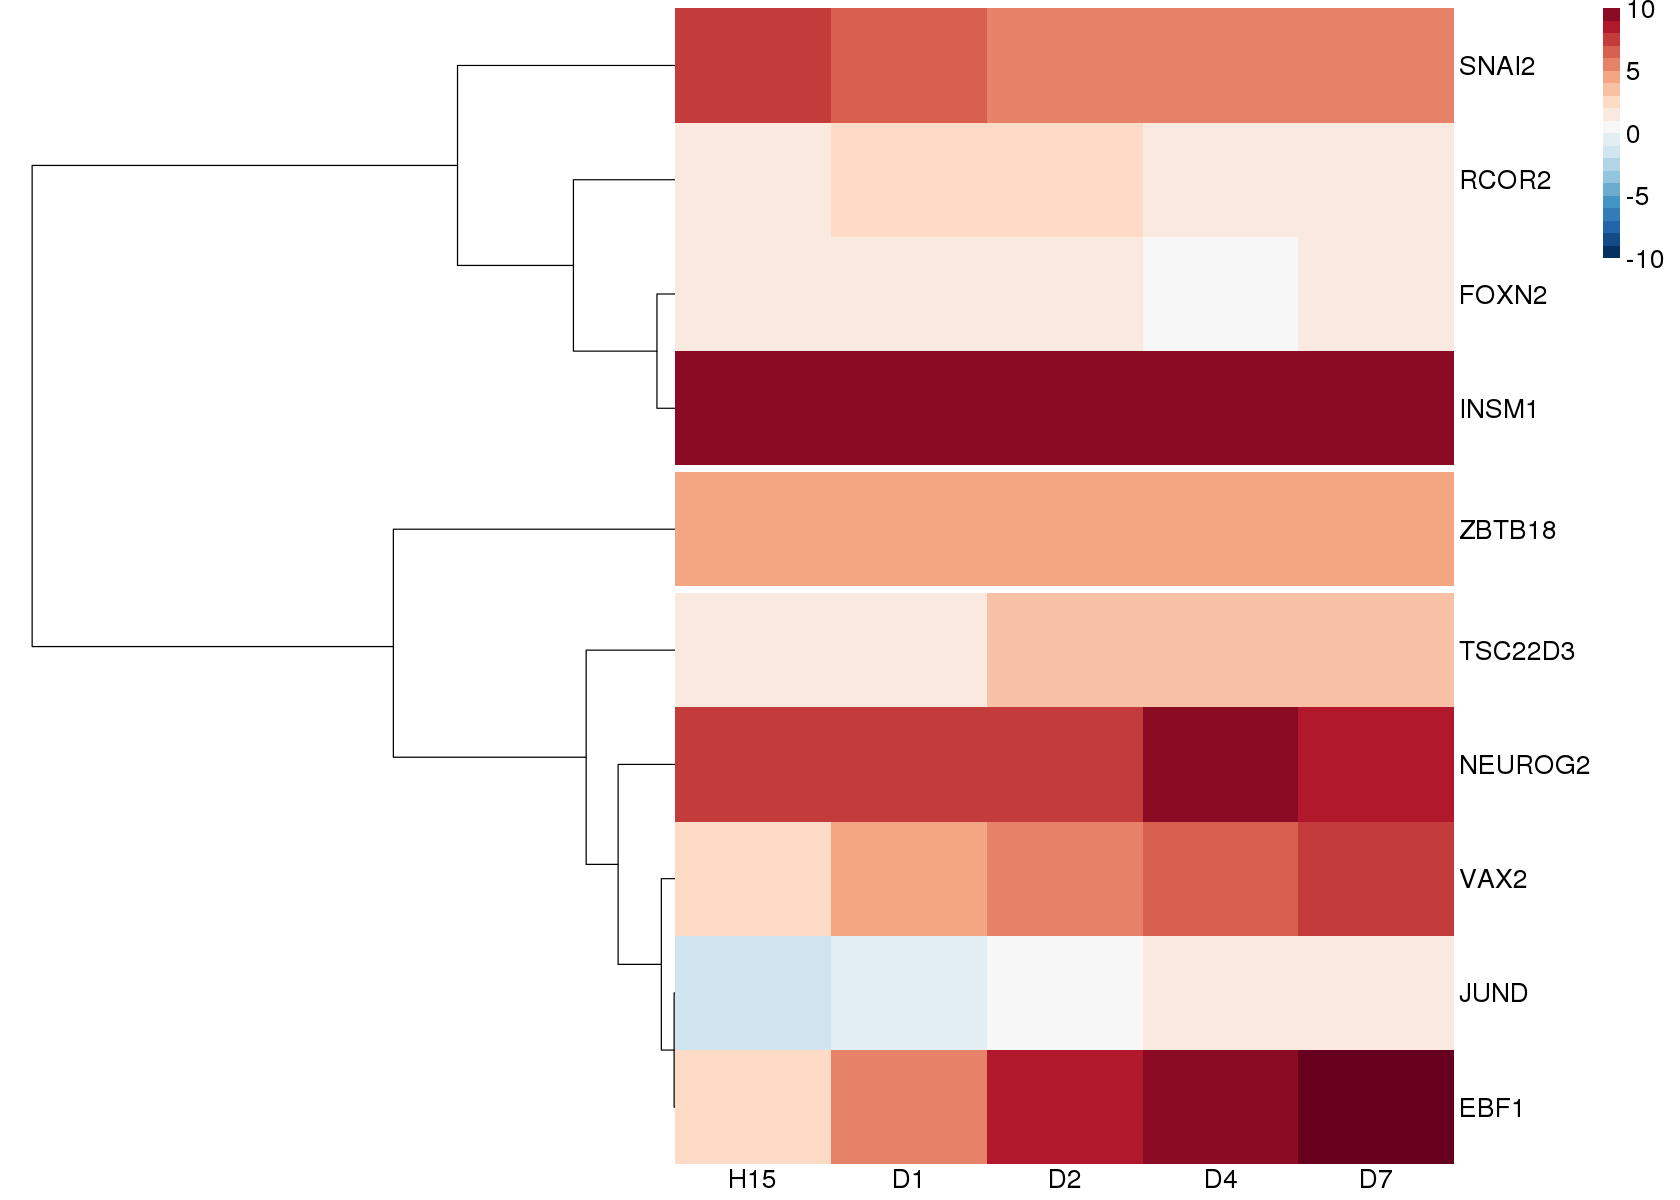

In [276]:
 heatmap_df %>%  
    add_column("type"=heatmap_anno$type) %>%
    filter(gene_name %in% incl_genes) %>%
    select(-gene_id, -type) %>%
    column_to_rownames("gene_name") %>%
    pheatmap(cluster_rows = T, show_rownames = T, cluster_cols = F, show_colnames = T,treeheight_row = 400,
            cutree_rows = 3,clustering_distance_rows = "correlation",
            fontsize=16, fontsize_col = 16, angle_col = 0,
            colorRampPalette(rev(brewer.pal(n = 11, name = "RdBu")))(length(breaksList)), breaks = breaksList)

In [272]:
cutree(x$tree_row, k = 2)

SNAI2    VAX2    JUND TSC22D3    EBF1   RCOR2   FOXN2   INSM1 NEUROG2  ZBTB18 
      1       1       2       2       1       2       2       1       1       1

### WT RNAseq time course pattern

In [234]:
ge$D7_vs_ES %>% head

gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name,sig,isTF
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>
ENSG00000000003.14,1093.2455416,-1.2998652,0.1841414,-7.059060,1.676324e-12,2.500888e-11,TSPAN6,TRUE,FALSE
ENSG00000000005.6,4.2712569,-5.4619627,2.2687624,-2.407464,1.606377e-02,4.193408e-02,TNMD,TRUE,FALSE
ENSG00000000419.12,562.8246277,-0.4335166,0.3066240,-1.413838,1.574096e-01,2.662829e-01,DPM1,FALSE,FALSE
ENSG00000000457.14,66.6639588,0.9733724,0.8216719,1.184624,2.361660e-01,3.629106e-01,SCYL3,FALSE,FALSE
ENSG00000000460.17,134.9026604,-3.0439906,0.7900719,-3.852802,1.167738e-04,5.509179e-04,C1orf112,TRUE,FALSE
ENSG00000000938.13,0.3862281,0.0000000,4.8388833,0.000000,1.000000e+00,NA,FGR,FALSE,FALSE


In [238]:
log2FCs <- map(ge, ~ pull(.x, log2FoldChange))
sigs <- map(ge, ~ pull(.x, sig))

In [239]:
sig_genes_all_times <- map(ge, ~ filter(.x, sig & !gene_id %in% remove_gene_ids) %>%
                                 pull(gene_id)) %>%
                            reduce(union)

In [240]:
sig_genes_all_times_index <- which(ge$H15_vs_ES$gene_id %in% sig_genes_all_times)

In [243]:
log2FCs_sig <- do.call(cbind, log2FCs) %>% as.data.frame %>% add_column("gene_id" = ge$H15_vs_ES$gene_id, .before = 1)

In [502]:
suppressMessages(inter_matrix_unnested <- read_csv("Interaction_matrix_nofilter_AllTF_20200107.csv"))

In [503]:
head(inter_matrix_unnested)

regulator_gene,target_gene,atac.ES,atac.H16,atac.D1,atac.D4,tar.ge.ES,tar.ge.H16,tar.ge.D1,tar.ge.D4,⋯,tar.cnt.D1,tar.cnt.D4,reg.l2fc.H16,reg.l2fc.D1,reg.l2fc.D4,reg.fdr.H16,reg.fdr.D1,reg.fdr.D4,reg.isHit,tar.isHit
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
AR,ABTB1,6.585393,6.045427,6.030358,6.084846,1.5938046,1.140030,0.9142180,2.2346859,⋯,10,27,-0.507919,-0.4858691,-3.236964,0.7647186,0.6979496,3.529782e-05,FALSE,FALSE
AR,ADNP2,3.945854,3.821774,3.677170,4.218503,9.0984955,9.291882,11.2987994,5.9482094,⋯,805,180,-0.507919,-0.4858691,-3.236964,0.7647186,0.6979496,3.529782e-05,FALSE,FALSE
AR,AEBP2,3.677928,3.229206,3.158372,2.531105,8.1074589,6.034633,5.2540640,4.7743804,⋯,204,120,-0.507919,-0.4858691,-3.236964,0.7647186,0.6979496,3.529782e-05,FALSE,FALSE
AR,AFF3,6.944645,7.350014,6.438632,7.494586,0.8340168,2.101545,2.5902853,8.4704284,⋯,60,391,-0.507919,-0.4858691,-3.236964,0.7647186,0.6979496,3.529782e-05,FALSE,FALSE
AR,AHR,2.143387,2.824849,2.431383,1.406017,1.7661186,1.901913,1.3321688,0.8802291,⋯,20,4,-0.507919,-0.4858691,-3.236964,0.7647186,0.6979496,3.529782e-05,FALSE,TRUE
AR,ALX1,6.624906,7.051463,7.140238,5.533048,0.9768808,1.167612,0.3451996,1.0828398,⋯,2,11,-0.507919,-0.4858691,-3.236964,0.7647186,0.6979496,3.529782e-05,FALSE,FALSE


---

In [121]:
?pheatmap

pheatmap {pheatmap},R Documentation
mat,numeric matrix of the values to be plotted.
color,vector of colors used in heatmap.
kmeans_k,"the number of kmeans clusters to make, if we want to aggregate the rows before drawing heatmap. If NA then the rows are not aggregated."
breaks,"a sequence of numbers that covers the range of values in mat and is one element longer than color vector. Used for mapping values to colors. Useful, if needed to map certain values to certain colors, to certain values. If value is NA then the breaks are calculated automatically. When breaks do not cover the range of values, then any value larger than max(breaks) will have the largest color and any value lower than min(breaks) will get the lowest color."
border_color,"color of cell borders on heatmap, use NA if no border should be drawn."
cellwidth,"individual cell width in points. If left as NA, then the values depend on the size of plotting window."
cellheight,"individual cell height in points. If left as NA, then the values depend on the size of plotting window."
scale,"character indicating if the values should be centered and scaled in either the row direction or the column direction, or none. Corresponding values are ""row"", ""column"" and ""none"""
cluster_rows,"boolean values determining if rows should be clustered or hclust object,"
cluster_cols,boolean values determining if columns should be clustered or hclust object.


In [302]:
rank(-c(1,5,5,9,1), ties.method = "first")

[1] 4 2 3 1 5

In [411]:
?cutree

cutree {stats},R Documentation
tree,"a tree as produced by hclust. cutree() only expects a list with components merge, height, and labels, of appropriate content each."
k,an integer scalar or vector with the desired number of groups
h,numeric scalar or vector with heights where the tree should be cut.
